In [1]:
!pip install pmdarima

In [2]:
%load_ext google.colab.data_table
import pandas as pd
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import math

import scipy
import statsmodels

In [3]:
!pip install statsmodels

In [4]:
import statsmodels

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
!ls "/content/gdrive/My Drive/m5-forecasting-accuracy/"

calendar.csv		    sales_train_validation.csv	sell_prices.csv
sales_train_evaluation.csv  sample_submission.csv	splitted-data


In [7]:
data_dir="/content/gdrive/My Drive/m5-forecasting-accuracy/"

In [8]:
df_train = pd.read_csv(data_dir+"sales_train_evaluation.csv")
df_train.head()

id        item_id  ... d_1940 d_1941
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  ...      0      1
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  ...      0      0
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  ...      0      1
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  ...      2      6
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  ...      1      0

[5 rows x 1947 columns]

In [9]:
df_train.shape

(30490, 1947)

In [10]:
df_calendar = pd.read_csv(data_dir+"calendar.csv")
df_calendar.head()

date  wm_yr_wk    weekday  ...  snap_CA  snap_TX  snap_WI
0  2011-01-29     11101   Saturday  ...        0        0        0
1  2011-01-30     11101     Sunday  ...        0        0        0
2  2011-01-31     11101     Monday  ...        0        0        0
3  2011-02-01     11101    Tuesday  ...        1        1        0
4  2011-02-02     11101  Wednesday  ...        1        0        1

[5 rows x 14 columns]

In [11]:
df_sell_prices = pd.read_csv(data_dir+'sell_prices.csv')
df_sales_train_validation = pd.read_csv(data_dir+'sales_train_validation.csv')

In [12]:
df_sell_prices

store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]

In [13]:
df_sales_train_validation.head()

id        item_id  ... d_1912 d_1913
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  ...      1      1
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  ...      0      0
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  ...      1      1
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  ...      7      2
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  ...      2      4

[5 rows x 1919 columns]

### Looking if data has Trend and Seasonality

In [14]:
#Picking ids to plot
ids = sorted(list(df_train['id']))
ids[:10]

['FOODS_1_001_CA_1_evaluation',
 'FOODS_1_001_CA_2_evaluation',
 'FOODS_1_001_CA_3_evaluation',
 'FOODS_1_001_CA_4_evaluation',
 'FOODS_1_001_TX_1_evaluation',
 'FOODS_1_001_TX_2_evaluation',
 'FOODS_1_001_TX_3_evaluation',
 'FOODS_1_001_WI_1_evaluation',
 'FOODS_1_001_WI_2_evaluation',
 'FOODS_1_001_WI_3_evaluation']

In [15]:
#getting sample data to plot
date_cols = [col for col in df_train.columns if 'd_' in col]
sample_1 = df_train.loc[df_train['id'] == ids[2]].set_index('id')[date_cols].values[0]
sample_2 = df_train.loc[df_train['id'] == ids[1]].set_index('id')[date_cols].values[0]
sample_3 = df_train.loc[df_train['id'] == ids[17]].set_index('id')[date_cols].values[0]


In [16]:
sample_1 = df_train.loc[df_train['id'] == ids[0]].set_index('id')[date_cols].values[0][:90]
sample_2 = df_train.loc[df_train['id'] == ids[4]].set_index('id')[date_cols].values[0][1300:1400]
sample_3 = df_train.loc[df_train['id'] == ids[65]].set_index('id')[date_cols].values[0][350:450]

In [17]:
def mean_abs_dev(x, axis=None):
  '''
  gives the mean absolute deviation
  '''
    return np.mean(np.absolute(x - np.mean(x, axis)), axis)

def sig_denoise(x, wavelet='db4', level=1):
  '''
  denoises the signal
  '''
    c = pywt.wavedec(x, wavelet, mode="per")
    sig = (1/0.6745) * mean_abs_dev(c[-level])

    u_t = sig * np.sqrt(2*np.log(len(x)))
    c[1:] = (pywt.threshold(i, value=u_t, mode='hard') for i in c[1:])

    return pywt.waverec(c, wavelet, mode='per')

In [18]:
def plot_denoise(sample,wavelet,r,c):
  '''
  plots the denoised signal
  '''
  fig = make_subplots(rows=1, cols=1)
  fig.add_trace(
    go.Scatter(x=np.arange(len(sample)), mode='lines+markers', y=sample, marker=dict(color="blue"), showlegend=False,
               name="Before Denoising"),row=r,col=c
  )
  fig.add_trace(
    go.Scatter(x=np.arange(len(sample)), y=wavelet, mode='lines', marker=dict(color="red"), showlegend=False,
               name="After Denoising"),row=r,col=c
  )
  fig.update_layout(height=500, width=1000, title_text="Before vs. After Denoising sales")
  fig.show()

In [19]:
#denoising and plotting the resulted signal data
wavelet1 = sig_denoise(sample_1)
wavelet2 = sig_denoise(sample_2)
wavelet3 = sig_denoise(sample_3)

plot_denoise(sample_1,wavelet1,1,1)
plot_denoise(sample_2,wavelet2,1,1)
plot_denoise(sample_3,wavelet3,1,1)


### Aggregating sales for predictions

In [20]:
#Aggregating sales by store level
store_level = df_train.groupby(df_train['store_id']).sum()
store_level['d'] = store_level.index
store_levelt = store_level.transpose() 
store_levelt['d'] = store_levelt.index
store_levelt

store_id  CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3       d
d_1       4337  3494  4739  1625  2556  3852  3030  2704  2256  4038     d_1
d_2       4155  3046  4827  1777  2687  3937  3006  2194  1922  4198     d_2
d_3       2816  2121  3785  1386  1822  2731  2225  1562  2018  3317     d_3
d_4       3051  2324  4232  1440  2258  2954  2169  1251  2522  3211     d_4
d_5       2630  1942  3817  1536  1694  2492  1726     2  1175  2132     d_5
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...     ...
d_1938    4136  4037  5580  2544  2748  3126  3288  3478  4628  3398  d_1938
d_1939    4433  4751  5542  2704  3664  4249  4390  3813  4880  4126  d_1939
d_1940    5764  7120  7073  3146  4167  4802  4712  5002  5213  4519  d_1940
d_1941    6289  6614  8144  3597  4624  5217  4974  5054  5068  4757  d_1941
d         CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3       d

[1942 rows x 11 columns]

In [21]:
#Merge this with the calendar data set to look at trends
store_level_final = store_levelt.merge(df_calendar, on='d')
store_level_final['date'] = store_level_final['date'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d'))
store_level_final

CA_1  CA_2  CA_3  CA_4  ... event_type_2 snap_CA snap_TX snap_WI
0     4337  3494  4739  1625  ...          NaN       0       0       0
1     4155  3046  4827  1777  ...          NaN       0       0       0
2     2816  2121  3785  1386  ...          NaN       0       0       0
3     3051  2324  4232  1440  ...          NaN       1       1       0
4     2630  1942  3817  1536  ...          NaN       1       0       1
...    ...   ...   ...   ...  ...          ...     ...     ...     ...
1936  3995  3789  5375  2519  ...          NaN       0       0       0
1937  4136  4037  5580  2544  ...          NaN       0       0       0
1938  4433  4751  5542  2704  ...          NaN       0       0       0
1939  5764  7120  7073  3146  ...          NaN       0       0       0
1940  6289  6614  8144  3597  ...          NaN       0       0       0

[1941 rows x 24 columns]

In [22]:
#getting unique weekdays in dataset
store_level_final['weekday'].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [23]:
#plotting aggregating sales per store for all week days
cols=['CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3','weekday']
plot_df=store_level_final[cols]
plot_df=plot_df.groupby(plot_df['weekday']).sum().reset_index()
plot_df

weekday     CA_1     CA_2     CA_3  ...     TX_3     WI_1     WI_2     WI_3
0     Friday  1116926   833641  1544641  ...   866332   797214   993778   973555
1     Monday  1070720   731884  1631892  ...   885904   644374   903697   870899
2   Saturday  1411710  1117417  1870569  ...  1025777  1019235  1113780  1152194
3     Sunday  1430155  1068331  1959372  ...  1055223   879398  1014039  1081057
4   Thursday   932910   700006  1424235  ...   787705   650684   895773   824051
5    Tuesday   947531   684140  1491761  ...   800944   625983   882900   830180
6  Wednesday   922296   682976  1441070  ...   784055   644618   894021   810621

[7 rows x 11 columns]

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

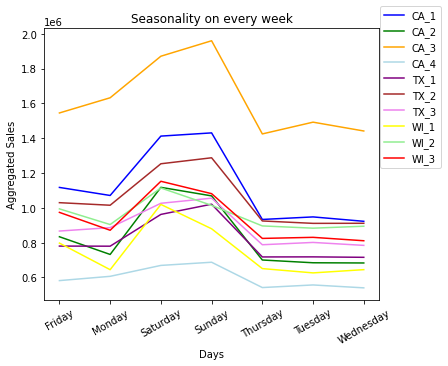

In [24]:
#plotting seasonality in the data
plt.figure(figsize=(6,5))
plt.plot(plot_df['weekday'],plot_df['CA_1'],'b',label='CA_1')
plt.plot(plot_df['weekday'],plot_df['CA_2'],'g',label='CA_2')
plt.plot(plot_df['weekday'],plot_df['CA_3'],'orange',label='CA_3')
plt.plot(plot_df['weekday'],plot_df['CA_4'],'lightblue',label='CA_4')
plt.plot(plot_df['weekday'],plot_df['TX_1'],'purple',label='TX_1')
plt.plot(plot_df['weekday'],plot_df['TX_2'],'brown',label='TX_2')
plt.plot(plot_df['weekday'],plot_df['TX_3'],'violet',label='TX_3')
plt.plot(plot_df['weekday'],plot_df['WI_1'],'yellow',label='WI_1')
plt.plot(plot_df['weekday'],plot_df['WI_2'],'lightgreen',label='WI_2')
plt.plot(plot_df['weekday'],plot_df['WI_3'],'red',label='WI_3')
plt.legend(bbox_to_anchor=[1.2, 1.1])
plt.savefig('week_days_seasonality.png',bbox_inches='tight')
plt.xlabel('Days')
plt.ylabel('Aggregated Sales')
plt.title('Seasonality on every week')
# plt.plot()
plt.xticks(rotation=30)

### Plottig seasonality for every year

In [25]:
store_level_final['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [26]:
#plotting seasonality every month by aggreagting sales per state on every month
cols=['CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3','month']
plot_df=store_level_final[cols]
plot_df=plot_df.groupby(plot_df['month']).sum().reset_index()
plot_df

month    CA_1    CA_2     CA_3  ...    TX_3    WI_1    WI_2    WI_3
0       1  612684  462367   897004  ...  480635  449168  562106  537402
1       2  663155  496826   971206  ...  542197  471352  625269  620340
2       3  732819  554375  1072785  ...  589905  510957  633278  652695
3       4  734350  542546  1042266  ...  574253  490615  609181  601087
4       5  721068  523341  1009813  ...  567499  479743  584855  578487
5       6  625257  450116   916812  ...  492078  400164  500020  492861
6       7  648071  477257   949142  ...  509056  410127  524180  516675
7       8  665090  490003   978528  ...  529836  404954  546193  515687
8       9  620576  471995   933203  ...  495058  385590  536039  507561
9      10  628877  472934   926900  ...  503098  398035  548210  520471
10     11  583035  429101   836671  ...  458188  416330  507307  495467
11     12  597266  447534   829210  ...  464137  444471  521350  503824

[12 rows x 11 columns]

Text(0.5, 1.0, 'Seasonality on every month')

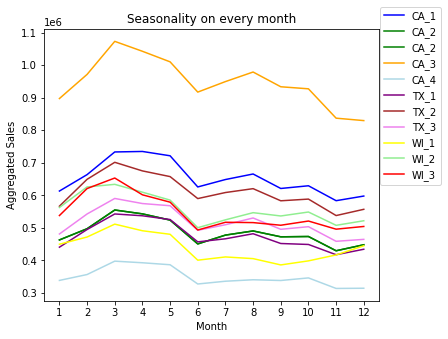

In [27]:
#plotting seasonality per store on every month
plt.figure(figsize=(6,5))
plt.plot(plot_df['month'],plot_df['CA_1'],'b',label='CA_1')
plt.plot(plot_df['month'],plot_df['CA_2'],'g',label='CA_2')
plt.plot(plot_df['month'],plot_df['CA_2'],'g',label='CA_2')
plt.plot(plot_df['month'],plot_df['CA_3'],'orange',label='CA_3')
plt.plot(plot_df['month'],plot_df['CA_4'],'lightblue',label='CA_4')
plt.plot(plot_df['month'],plot_df['TX_1'],'purple',label='TX_1')
plt.plot(plot_df['month'],plot_df['TX_2'],'brown',label='TX_2')
plt.plot(plot_df['month'],plot_df['TX_3'],'violet',label='TX_3')
plt.plot(plot_df['month'],plot_df['WI_1'],'yellow',label='WI_1')
plt.plot(plot_df['month'],plot_df['WI_2'],'lightgreen',label='WI_2')
plt.plot(plot_df['month'],plot_df['WI_3'],'red',label='WI_3')
plt.legend(bbox_to_anchor=[1.2, 1.1])
plt.savefig('year_seasonality.png',bbox_inches='tight')
# plt.plot()
plt.xticks(np.arange(1, 13, step=1))
plt.xlabel('Month')
plt.ylabel('Aggregated Sales')
plt.title('Seasonality on every month')

(array([734169., 734176., 734183., 734190., 734197., 734204., 734211.]),
 <a list of 7 Text major ticklabel objects>)

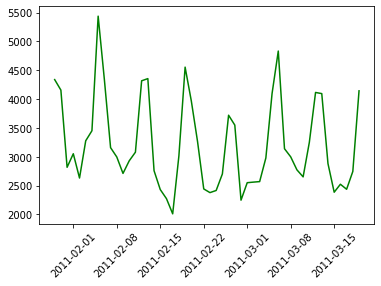

In [28]:
#Plotting seasonal trends
plt.plot(store_level_final['date'][:50], store_level_final['CA_1'][:50],color='g',label='CA_1')
plt.xticks(rotation=45)

Finding parameters for ARIMA model

In [29]:
def test_stationarity(timeseries):
    '''
    checks if the data has stationarity
    '''
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries[0:100], color='blue',label='Original')
    mean = plt.plot(rolmean[0:100], color='red', label='Rolling Mean')
    std = plt.plot(rolstd[0:100], color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

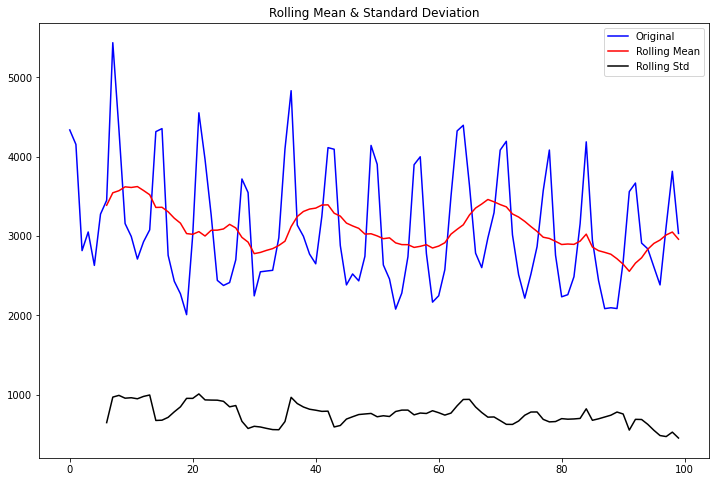

Results of Dickey-Fuller Test:
Test Statistic                 -2.461764
p-value                         0.125057
#Lags Used                     12.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


In [30]:
test_stationarity(store_level_final['CA_1'][0:100])

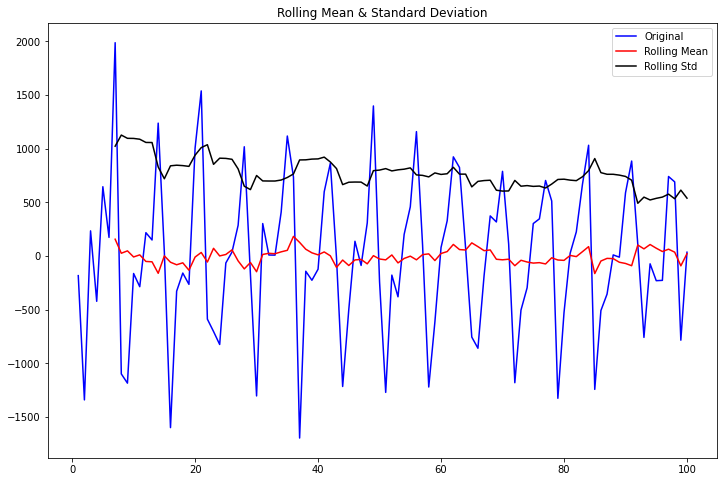

Results of Dickey-Fuller Test:
Test Statistic                  -20.778266
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    1913.000000
Critical Value (1%)              -3.433773
Critical Value (5%)              -2.863052
Critical Value (10%)             -2.567575
dtype: float64


In [31]:
#shifting lag features to check stationarity
store_level_final['first_difference'] = store_level_final['CA_1'] - store_level_final['CA_1'].shift(1)
test_stationarity(store_level_final['first_difference'].dropna())

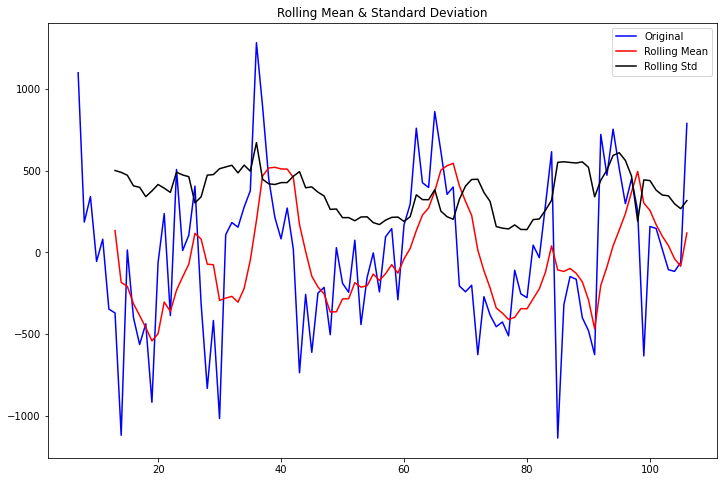

Results of Dickey-Fuller Test:
Test Statistic                  -19.486727
p-value                           0.000000
#Lags Used                       23.000000
Number of Observations Used    1910.000000
Critical Value (1%)              -3.433778
Critical Value (5%)              -2.863054
Critical Value (10%)             -2.567576
dtype: float64


In [32]:
#shifting lag features to check stationarity by factor of 7
store_level_final['seasonal_difference'] = store_level_final['CA_1'] - store_level_final['CA_1'].shift(7)
test_stationarity(store_level_final['seasonal_difference'].dropna())

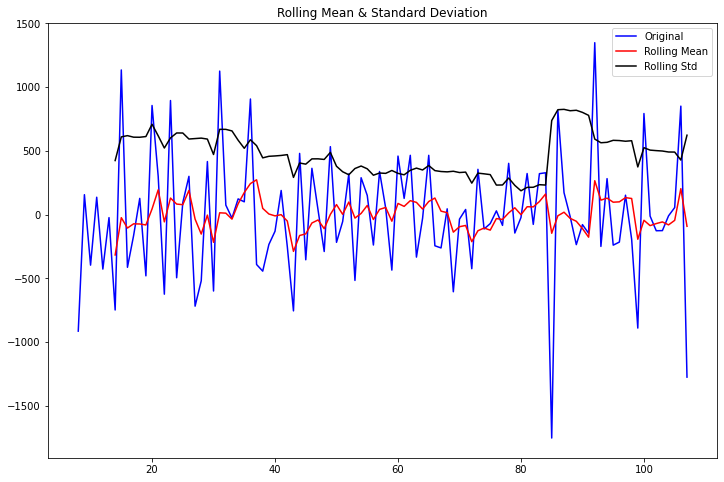

Results of Dickey-Fuller Test:
Test Statistic                  -19.868257
p-value                           0.000000
#Lags Used                       25.000000
Number of Observations Used    1907.000000
Critical Value (1%)              -3.433784
Critical Value (5%)              -2.863057
Critical Value (10%)             -2.567577
dtype: float64


In [33]:
#shifting lag features to check stationarity by factor of 1 and 7
store_level_final['seasonal_first_difference'] = store_level_final['CA_1'] - store_level_final['CA_1'].shift(1) - store_level_final['CA_1'].shift(7) + store_level_final['CA_1'].shift(8)
test_stationarity(store_level_final['seasonal_first_difference'].dropna())

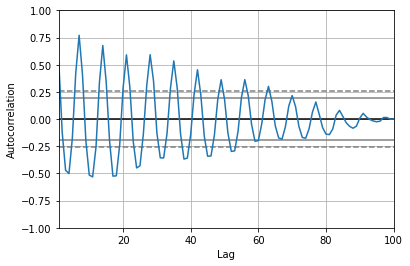

In [34]:
#plotting autocorrelation plot
autocorrelation_plot(store_level_final['CA_1'][0:100])

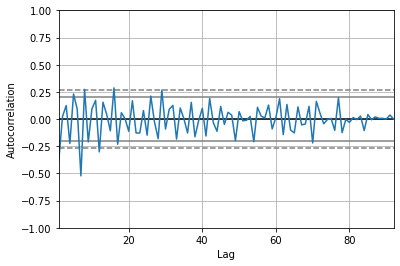

In [35]:
#plotting auto correlation plot
autocorrelation_plot(store_level_final['seasonal_first_difference'][8:100])

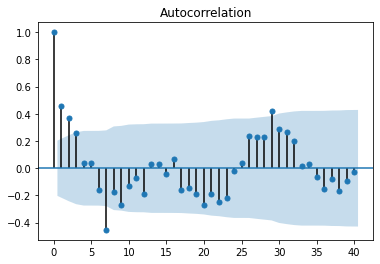

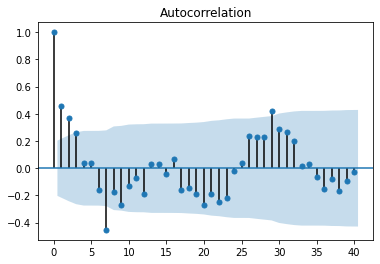

In [36]:
plot_acf(store_level_final['seasonal_difference'][0:100].dropna(), lags=40)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



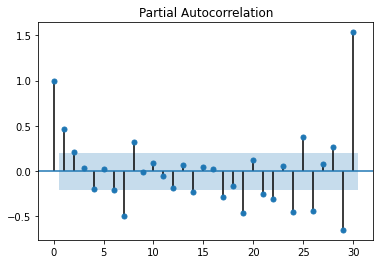

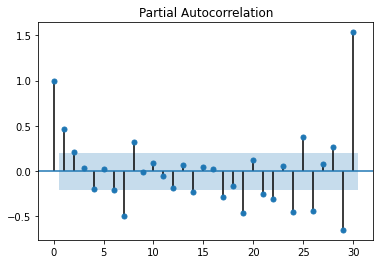

In [37]:
plot_pacf(store_level_final['seasonal_difference'][0:100].dropna(), lags=30)

### Splitting evaluation data into train,val and test

In [38]:
# d_1 to d_1883 -> train data
# d_1884 to d_1912 -> validation data
# d_1913 to d_1941 -> test data
days = [col for col in df_train.columns if "d_" in col]

#train array
train_cols = ["d_"+str(i) for i in range(1,1886)]
val_cols = ["d_"+str(i) for i in range(1886,1914)]
test_cols = ["d_"+str(i) for i in range(1914,1942)]

print(f"train_cols length: {len(train_cols)}")
print(f"val_cols length: {len(val_cols)}")
print(f"test_cols length: {len(test_cols)}")

train_cols length: 1885
val_cols length: 28
test_cols length: 28


In [39]:
df_training = store_level_final[:1885]
df_val = store_level_final[1885:1913]
df_test = store_level_final[1913:1942]
print(df_training.shape)
print(df_val.shape)
print(df_test.shape)

(1885, 27)
(28, 27)
(28, 27)


### Predicting for stores

In [40]:
rmse=[]

In [41]:
#prediction on store CA_1
train = np.asarray(df_training['CA_1'].astype(float))
val = np.asarray(df_val['CA_1'].astype(float))
test=np.asarray(df_test['CA_1'].astype(float))

In [44]:
##Using SARIMAX with parameters we got from above
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14067.137
Date:                           Wed, 16 Dec 2020   AIC                          28144.274
Time:                                   08:46:56   BIC                          28171.961
Sample:                                        0   HQIC                         28154.472
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3509      0.014     24.299      0.000       0.323       0.379
ma.L1         -0.9608      0.008   -122.605

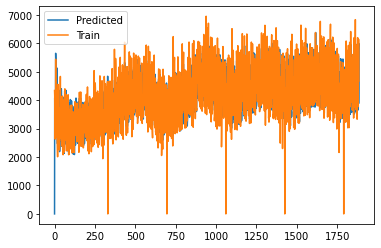

In [45]:
plt.plot(results.predict(start=0,end=1885), label = 'Predicted')
plt.plot(train, label = 'Train')
plt.legend(loc = "upper left")

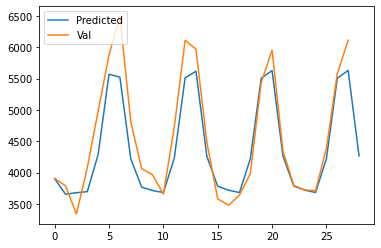

In [46]:
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

Text(0.5, 1.0, 'Prediction on store CA_1 for last 28 days')

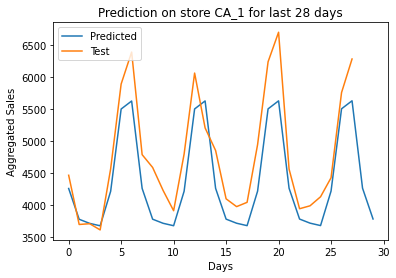

In [47]:
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')
plt.xlabel('Days')
plt.ylabel('Aggregated Sales')
plt.title('Prediction on store CA_1 for last 28 days')

In [48]:
from sklearn.metrics import mean_squared_error
import math
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
# print(np.sqrt(val))
res=np.sqrt(val)/np.std(test)
rmse.append(res)
res

0.5406764760163412

In [49]:
#prediction on store CA_2
train = np.asarray(df_training['CA_2'].astype(float))
val = np.asarray(df_val['CA_2'].astype(float))
test=np.asarray(df_test['CA_2'].astype(float))

In [50]:
##Using SARIMAX
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -13594.790
Date:                           Wed, 16 Dec 2020   AIC                          27199.579
Time:                                   08:47:00   BIC                          27227.266
Sample:                                        0   HQIC                         27209.778
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1891      0.013     14.404      0.000       0.163       0.215
ma.L1         -0.9357      0.008   -115.093

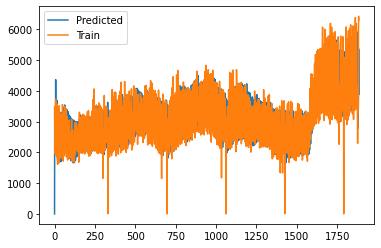

In [51]:
plt.plot(results.predict(start=0,end=1885), label = 'Predicted')
plt.plot(train, label = 'Train')
plt.legend(loc = "upper left")

In [52]:
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

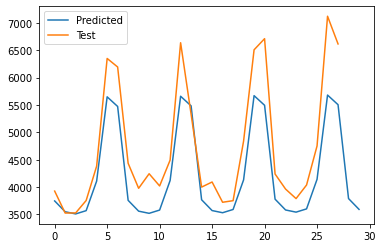

In [53]:
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [54]:
from sklearn.metrics import mean_squared_error
import math
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
res=np.sqrt(val)/np.std(test)
rmse.append(res)
res

0.5500685808712305

In [55]:
#prediction on store CA_3
train = np.asarray(df_training['CA_3'].astype(float))
val = np.asarray(df_val['CA_3'].astype(float))
test=np.asarray(df_test['CA_3'].astype(float))

In [56]:
##Using SARIMAX
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14610.816
Date:                           Wed, 16 Dec 2020   AIC                          29231.631
Time:                                   08:47:05   BIC                          29259.319
Sample:                                        0   HQIC                         29241.830
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3830      0.015     24.906      0.000       0.353       0.413
ma.L1         -0.9391      0.010    -93.160

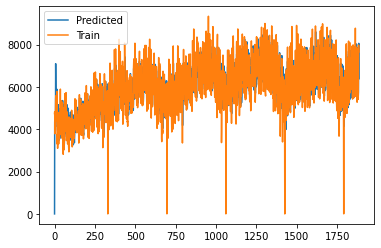

In [57]:
plt.plot(results.predict(start=0,end=1885), label = 'Predicted')
plt.plot(train, label = 'Train')
plt.legend(loc = "upper left")

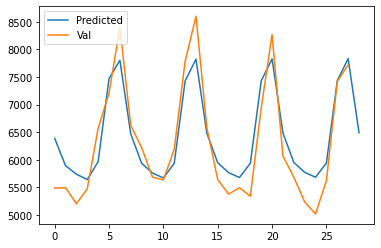

In [58]:
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

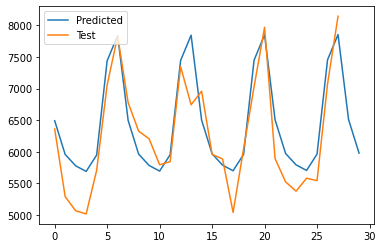

In [59]:
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [60]:
from sklearn.metrics import mean_squared_error
import math
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
res=np.sqrt(val)/np.std(test)
rmse.append(res)
res

0.4921247793188586

In [61]:
#prediction on store CA_4
train = np.asarray(df_training['CA_4'].astype(float))
val = np.asarray(df_val['CA_4'].astype(float))
test=np.asarray(df_test['CA_4'].astype(float))

In [62]:
##Using SARIMAX
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -12688.705
Date:                           Wed, 16 Dec 2020   AIC                          25387.411
Time:                                   08:47:09   BIC                          25415.098
Sample:                                        0   HQIC                         25397.610
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1942      0.020      9.615      0.000       0.155       0.234
ma.L1         -0.9390      0.010    -97.697

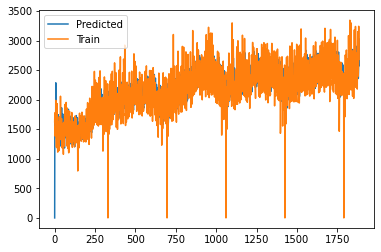

In [63]:
plt.plot(results.predict(start=0,end=1885), label = 'Predicted')
plt.plot(train, label = 'Train')
plt.legend(loc = "upper left")


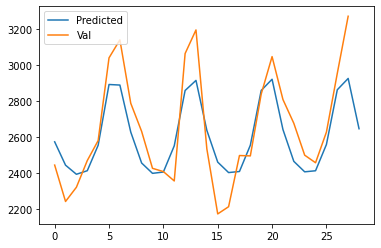

In [64]:
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

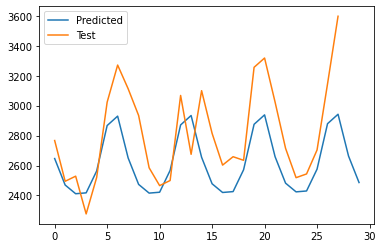

In [65]:
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [66]:
from sklearn.metrics import mean_squared_error
import math
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
res=np.sqrt(val)/np.std(test)
rmse.append(res)
res

0.8729418258373255

In [67]:
#prediction on store TX_1
train = np.asarray(df_training['TX_1'].astype(float))
val = np.asarray(df_val['TX_1'].astype(float))
test=np.asarray(df_test['TX_1'].astype(float))

In [68]:
##Using SARIMAX
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -13590.327
Date:                           Wed, 16 Dec 2020   AIC                          27190.654
Time:                                   08:47:14   BIC                          27218.341
Sample:                                        0   HQIC                         27200.852
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0596      0.023      2.541      0.011       0.014       0.105
ma.L1         -0.7967      0.019    -42.089

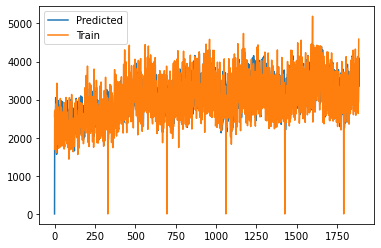

In [69]:
plt.plot(results.predict(start=0,end=1885), label = 'Predicted')
plt.plot(train, label = 'Train')
plt.legend(loc = "upper left")

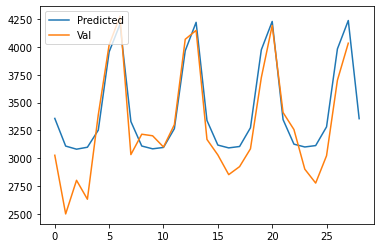

In [70]:
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

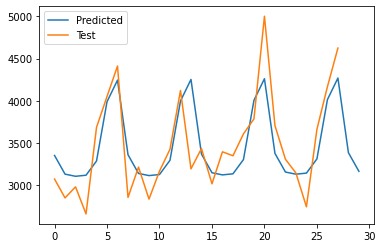

In [71]:
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [72]:
from sklearn.metrics import mean_squared_error
import math
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
res=np.sqrt(val)/np.std(test)
rmse.append(res)
res

0.6066819973066455

In [73]:
#prediction on store TX_2
train = np.asarray(df_training['TX_2'].astype(float))
val = np.asarray(df_val['TX_2'].astype(float))
test=np.asarray(df_test['TX_2'].astype(float))

In [74]:
##Using SARIMAX
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14092.908
Date:                           Wed, 16 Dec 2020   AIC                          28195.816
Time:                                   08:47:18   BIC                          28223.503
Sample:                                        0   HQIC                         28206.015
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1069      0.016      6.711      0.000       0.076       0.138
ma.L1         -0.9173      0.010    -89.078

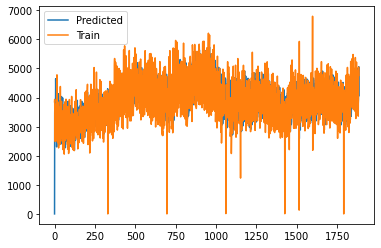

In [75]:
plt.plot(results.predict(start=0,end=1885), label = 'Predicted')
plt.plot(train, label = 'Train')
plt.legend(loc = "upper left")

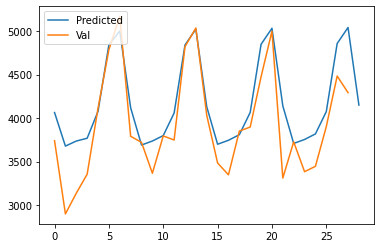

In [76]:
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

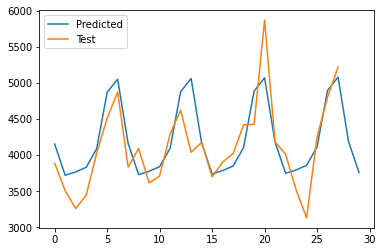

In [77]:
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [78]:
from sklearn.metrics import mean_squared_error
import math
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
res=np.sqrt(val)/np.std(test)
rmse.append(res)
res

0.6289494600987073

In [79]:
#prediction on store TX_3
train = np.asarray(df_training['TX_3'].astype(float))
val = np.asarray(df_val['TX_3'].astype(float))
test=np.asarray(df_test['TX_3'].astype(float))

In [80]:
##Using SARIMAX
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -13806.604
Date:                           Wed, 16 Dec 2020   AIC                          27623.208
Time:                                   08:47:23   BIC                          27650.895
Sample:                                        0   HQIC                         27633.407
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3408      0.013     26.679      0.000       0.316       0.366
ma.L1         -0.9977      0.002   -479.981

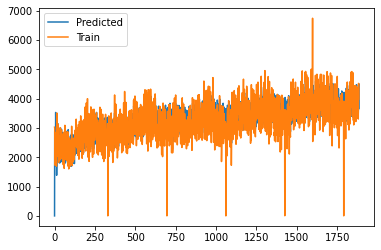

In [81]:
plt.plot(results.predict(start=0,end=1885), label = 'Predicted')
plt.plot(train, label = 'Train')
plt.legend(loc = "upper left")

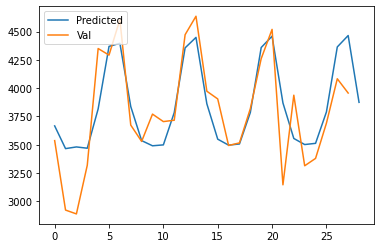

In [82]:
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

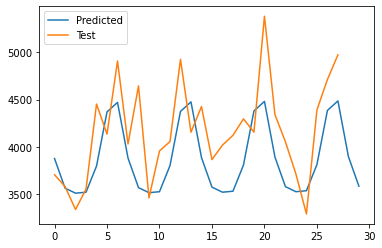

In [83]:
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [84]:
from sklearn.metrics import mean_squared_error
import math
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
res=np.sqrt(val)/np.std(test)
rmse.append(res)
res

0.8936637336544164

In [85]:
#prediction on store WI_1
train = np.asarray(df_training['WI_1'].astype(float))
val = np.asarray(df_val['WI_1'].astype(float))
test=np.asarray(df_test['WI_1'].astype(float))

In [86]:
##Using SARIMAX
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -13823.582
Date:                           Wed, 16 Dec 2020   AIC                          27657.165
Time:                                   08:47:27   BIC                          27684.852
Sample:                                        0   HQIC                         27667.364
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2891      0.013     22.891      0.000       0.264       0.314
ma.L1         -0.9999      0.021    -48.470

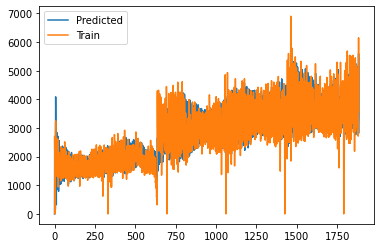

In [87]:
plt.plot(results.predict(start=0,end=1885), label = 'Predicted')
plt.plot(train, label = 'Train')
plt.legend(loc = "upper left")

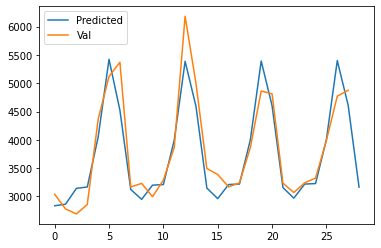

In [88]:
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

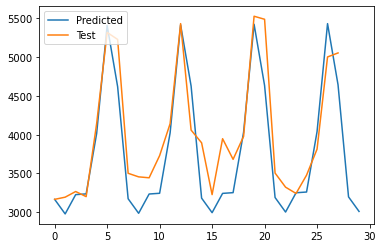

In [89]:
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [90]:
from sklearn.metrics import mean_squared_error
import math
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
res=np.sqrt(val)/np.std(test)
rmse.append(res)
res

0.47668862973208137

In [91]:
#prediction on store WI_2
train = np.asarray(df_training['WI_2'].astype(float))
val = np.asarray(df_val['WI_2'].astype(float))
test=np.asarray(df_test['WI_2'].astype(float))

In [92]:
##Using SARIMAX
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14651.672
Date:                           Wed, 16 Dec 2020   AIC                          29313.345
Time:                                   08:47:32   BIC                          29341.032
Sample:                                        0   HQIC                         29323.544
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5503      0.018     31.429      0.000       0.516       0.585
ma.L1         -0.9721      0.006   -170.362

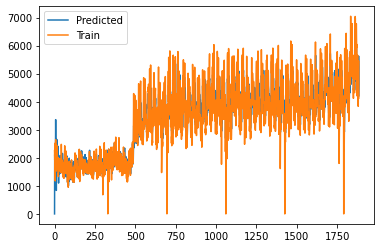

In [93]:
plt.plot(results.predict(start=0,end=1885), label = 'Predicted')
plt.plot(train, label = 'Train')
plt.legend(loc = "upper left")

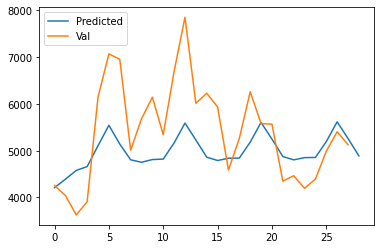

In [94]:
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

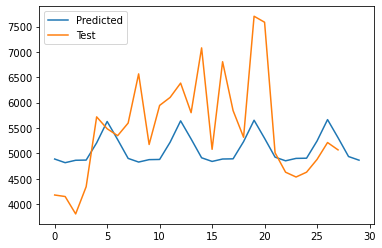

In [95]:
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [96]:
from sklearn.metrics import mean_squared_error
import math
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
res=np.sqrt(val)/np.std(test)
rmse.append(res)
res

1.0143495190962406

In [97]:
#prediction on store WI_3
train = np.asarray(df_training['WI_3'].astype(float))
val = np.asarray(df_val['WI_3'].astype(float))
test=np.asarray(df_test['WI_3'].astype(float))

In [98]:
##Using SARIMAX
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14330.139
Date:                           Wed, 16 Dec 2020   AIC                          28670.278
Time:                                   08:47:37   BIC                          28697.965
Sample:                                        0   HQIC                         28680.477
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1546      0.035      4.419      0.000       0.086       0.223
ma.L1         -0.6873      0.030    -22.948

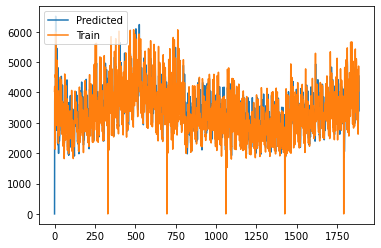

In [99]:
plt.plot(results.predict(start=0,end=1885), label = 'Predicted')
plt.plot(train, label = 'Train')
plt.legend(loc = "upper left")

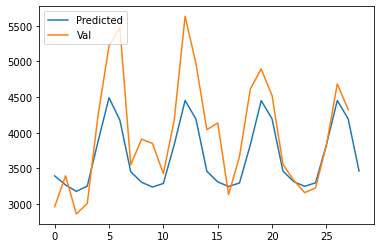

In [100]:
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

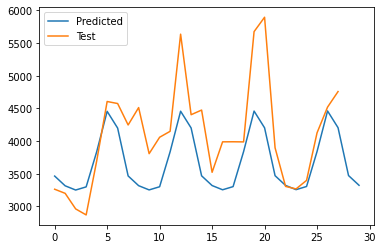

In [101]:
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [102]:
from sklearn.metrics import mean_squared_error
import math
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
res=np.sqrt(val)/np.std(test)
rmse.append(res)
res

0.8546640694495724

#### RMSE for stores

In [103]:
ans=0
for r in rmse:
  ans+=r
final_rmse=ans/len(rmse)
final_rmse

0.693080907138142

### Predicting category wise sales

In [170]:
rmse_cat=[]

In [171]:
#grouping sales on categories
category_sales = df_train.groupby(df_train['cat_id']).sum()
category_salest = category_sales.transpose()
category_salest['d'] = category_salest.index

In [172]:
#Merge this with the calendar data set to look at trends
category_level_final = category_salest.merge(df_calendar, on='d')
category_level_final['date'] = category_level_final['date'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d'))
category_level_final

FOODS  HOBBIES  HOUSEHOLD       d  ... event_type_2  snap_CA snap_TX  snap_WI
0     23178     3764       5689     d_1  ...          NaN        0       0        0
1     22758     3357       5634     d_2  ...          NaN        0       0        0
2     17174     2682       3927     d_3  ...          NaN        0       0        0
3     18878     2669       3865     d_4  ...          NaN        1       1        0
4     14603     1814       2729     d_5  ...          NaN        1       0        1
...     ...      ...        ...     ...  ...          ...      ...     ...      ...
1936  24790     3740       8566  d_1937  ...          NaN        0       0        0
1937  24737     3475       8751  d_1938  ...          NaN        0       0        0
1938  28136     4143      10273  d_1939  ...          NaN        0       0        0
1939  33599     5333      12586  d_1940  ...          NaN        0       0        0
1940  35967     5280      13091  d_1941  ...          NaN        0       0        0

[1941 rows x 17 columns]

#### Prediction on foods category

In [173]:
df_training = category_level_final[:1885]
df_val = category_level_final[1885:1913]
df_test = category_level_final[1913:1942]
print(df_training.shape)
print(df_val.shape)
print(df_test.shape)
df_training.head()


(1885, 17)
(28, 17)
(28, 17)


FOODS  HOBBIES  HOUSEHOLD    d  ... event_type_2  snap_CA snap_TX  snap_WI
0  23178     3764       5689  d_1  ...          NaN        0       0        0
1  22758     3357       5634  d_2  ...          NaN        0       0        0
2  17174     2682       3927  d_3  ...          NaN        0       0        0
3  18878     2669       3865  d_4  ...          NaN        1       1        0
4  14603     1814       2729  d_5  ...          NaN        1       0        1

[5 rows x 17 columns]

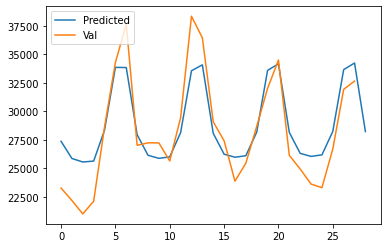

In [174]:
train_foods = np.asarray(df_training['FOODS'])
val_foods = np.asarray(df_val['FOODS'])
test_foods=np.asarray(df_test['FOODS'])
mod_foods = sm.tsa.statespace.SARIMAX(train_foods, order=(1,1,1), seasonal_order=(1,1,1,7))
results_foods=mod_foods.fit()
plt.plot(results_foods.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val_foods, label = 'Val')
plt.legend(loc = 'upper left')

0.9656190093990094


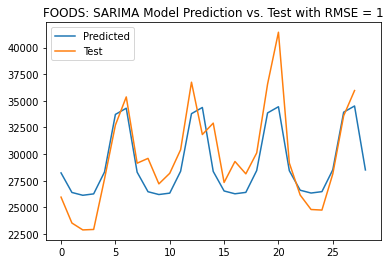

In [175]:
plt.plot(results_foods.predict(start = 1913, end = 1941), label = 'Predicted')
plt.plot(test_foods, label = 'Test')
plt.legend(loc = 'upper left')
rmse = math.sqrt(mean_squared_error(results_foods.predict(start = 1914, end = 1941), test_foods))
plt.title("FOODS: SARIMA Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse/(np.std(test_foods))))
val=mean_squared_error(results.predict(start = 1914, end = 1941), test_foods)
# print(np.sqrt(val))
res=rmse/np.std(test_foods)
print(res)
rmse_cat.append(res)

#### Prediction of Hobbies category

In [176]:
df_training = category_level_final[:1885]
df_val = category_level_final[1885:1913]
df_test = category_level_final[1913:1942]
print(df_training.shape)
print(df_val.shape)
print(df_test.shape)
df_training.head()


(1885, 17)
(28, 17)
(28, 17)


FOODS  HOBBIES  HOUSEHOLD    d  ... event_type_2  snap_CA snap_TX  snap_WI
0  23178     3764       5689  d_1  ...          NaN        0       0        0
1  22758     3357       5634  d_2  ...          NaN        0       0        0
2  17174     2682       3927  d_3  ...          NaN        0       0        0
3  18878     2669       3865  d_4  ...          NaN        1       1        0
4  14603     1814       2729  d_5  ...          NaN        1       0        1

[5 rows x 17 columns]

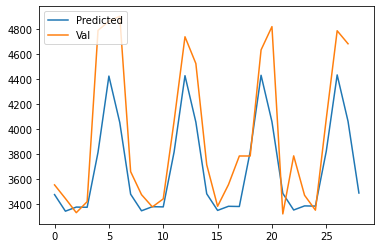

In [177]:
train_hobbies = np.asarray(df_training['HOBBIES'])
val_hobbies = np.asarray(df_val['HOBBIES'])
test_hobbies=np.asarray(df_test['HOBBIES'])
mod_hobbies = sm.tsa.statespace.SARIMAX(train_hobbies, order=(0,1,1), seasonal_order=(0,1,1,7))
results_hobbies=mod_hobbies.fit()
plt.plot(results_hobbies.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val_hobbies, label = 'Val')
plt.legend(loc = 'upper left')

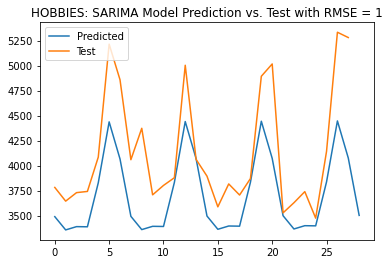

In [178]:
plt.plot(results_hobbies.predict(start = 1913, end = 1941), label = 'Predicted')
plt.plot(test_hobbies, label = 'Test')
plt.legend(loc = 'upper left')
rmse = math.sqrt(mean_squared_error(results_hobbies.predict(start = 1914, end = 1941), test_hobbies))
plt.title("HOBBIES: SARIMA Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse/(np.std(test_hobbies))))
val=mean_squared_error(results.predict(start = 1914, end = 1941), test_hobbies)
# print(np.sqrt(val))
res=(rmse)/np.std(test_hobbies)
rmse_cat.append(res)

#### Prediction on House hold category

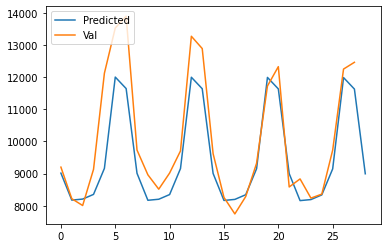

In [179]:
train = np.asarray(df_training['HOUSEHOLD'])
val = np.asarray(df_val['HOUSEHOLD'])
test=np.asarray(df_test['HOUSEHOLD'])
mod = sm.tsa.statespace.SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,7))
results=mod.fit()
plt.plot(results.predict(start = 1885, end = 1913), label = 'Predicted')
plt.plot(val, label = 'Val')
plt.legend(loc = 'upper left')

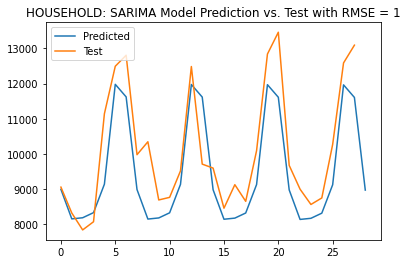

In [180]:
plt.plot(results.predict(start = 1913, end = 1941), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')
rmse = math.sqrt(mean_squared_error(results.predict(start = 1914, end = 1941), test))
plt.title("HOUSEHOLD: SARIMA Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse/(np.std(test))))
val=mean_squared_error(results.predict(start = 1914, end = 1941), test)
# print(np.sqrt(val))
res=rmse/np.std(test)
rmse_cat.append(res)

#### RMSE category

In [181]:
print(rmse_cat)

[0.9656190093990094, 1.280473853794625, 1.0175866102511293]


In [182]:
final_cat_rmse=0
for i in rmse_cat:
  final_cat_rmse+=i
print(final_cat_rmse/len(rmse_cat))

1.0878931578149211


### Predicting sales department wise

In [116]:
df_train

id        item_id  ... d_1940 d_1941
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  ...      0      1
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  ...      0      0
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  ...      0      1
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  ...      2      6
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  ...      1      0
...                              ...            ...  ...    ...    ...
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823  ...      1      1
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824  ...      1      0
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825  ...      0      2
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826  ...      1      0
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827  ...      5      1

[30490 rows x 1947 columns]

In [117]:
df_train['dept_id'].unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [118]:
#Aggregating sales by department level
dept_level = df_train.groupby(df_train['dept_id']).sum()
dept_level['d'] = dept_level.index
dept_levelt = dept_level.transpose() 
dept_levelt['d'] = dept_levelt.index
dept_levelt

dept_id  FOODS_1  FOODS_2  FOODS_3  ...  HOUSEHOLD_1  HOUSEHOLD_2       d
d_1         2343     4094    16741  ...         4105         1584     d_1
d_2         2216     4209    16333  ...         3858         1776     d_2
d_3         1657     3174    12343  ...         2827         1100     d_3
d_4         1508     3606    13764  ...         2732         1133     d_4
d_5         1209     2869    10525  ...         1802          927     d_5
...          ...      ...      ...  ...          ...          ...     ...
d_1938      3251     4551    16935  ...         6759         1992  d_1938
d_1939      3735     4815    19586  ...         7974         2299  d_1939
d_1940      4195     5940    23464  ...         9668         2918  d_1940
d_1941      4031     6535    25401  ...        10165         2926  d_1941
d        FOODS_1  FOODS_2  FOODS_3  ...  HOUSEHOLD_1  HOUSEHOLD_2       d

[1942 rows x 8 columns]

In [119]:
#Merge this with the calendar data set to look at trends
dept_level_final = dept_levelt.merge(df_calendar, on='d')
dept_level_final['date'] = dept_level_final['date'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d'))
dept_level_final

FOODS_1 FOODS_2 FOODS_3 HOBBIES_1  ... event_type_2 snap_CA snap_TX snap_WI
0       2343    4094   16741      3610  ...          NaN       0       0       0
1       2216    4209   16333      3172  ...          NaN       0       0       0
2       1657    3174   12343      2497  ...          NaN       0       0       0
3       1508    3606   13764      2531  ...          NaN       1       1       0
4       1209    2869   10525      1714  ...          NaN       1       0       1
...      ...     ...     ...       ...  ...          ...     ...     ...     ...
1936    3073    4648   17069      3291  ...          NaN       0       0       0
1937    3251    4551   16935      3027  ...          NaN       0       0       0
1938    3735    4815   19586      3761  ...          NaN       0       0       0
1939    4195    5940   23464      4832  ...          NaN       0       0       0
1940    4031    6535   25401      4720  ...          NaN       0       0       0

[1941 rows x 21 columns]

In [120]:
#splitting on train, validation and test
df_training = dept_level_final[:1885]
df_val = dept_level_final[1885:1913]
df_test = dept_level_final[1913:1942]
print(df_training.shape)
print(df_val.shape)
print(df_test.shape)

(1885, 21)
(28, 21)
(28, 21)


In [121]:
dept_ids=df_train['dept_id'].unique()
type(dept_ids)

numpy.ndarray

In [122]:
rmse=[]

Predicting for dep HOBBIES_1


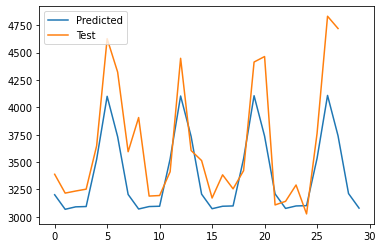

Predicting for dep HOBBIES_2


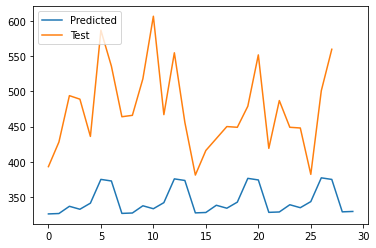

Predicting for dep HOUSEHOLD_1


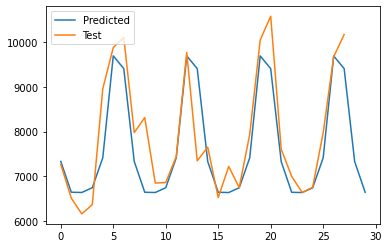

Predicting for dep HOUSEHOLD_2


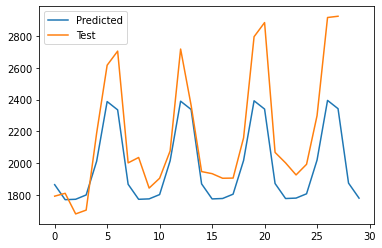

Predicting for dep FOODS_1


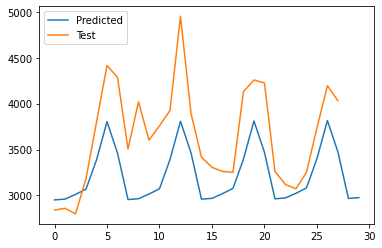

Predicting for dep FOODS_2


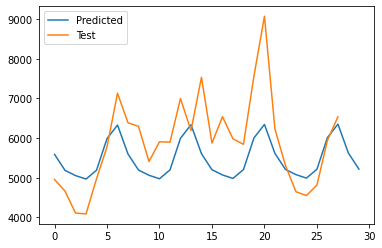

Predicting for dep FOODS_3


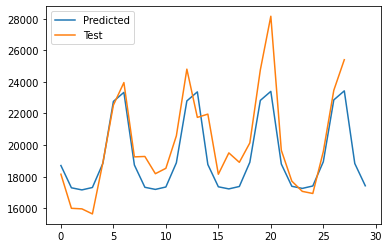

In [123]:
#pipeline to predict all departments
for dep in dept_ids:
  print(f'Predicting for dep {dep}')
  train = np.asarray(df_training[dep].astype(float))
  val = np.asarray(df_val[dep].astype(float))
  test=np.asarray(df_test[dep].astype(float))
  mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
  results=mod.fit()
  # print(results.summary())
  plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
  plt.plot(test, label = 'Test')
  plt.legend(loc = 'upper left')
  plt.show()
  val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
# print(np.sqrt(val))
  res=np.sqrt(val)/np.std(test)
  rmse.append(res)

In [124]:
#rmse for department wise aggregation sales
final_dept_rmse=0
for i in rmse:
  final_dept_rmse+=i
print(final_dept_rmse/len(rmse))

0.9473482533921471


### Predicting sales item wise


In [125]:
df_train

id        item_id  ... d_1940 d_1941
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  ...      0      1
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  ...      0      0
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  ...      0      1
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  ...      2      6
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  ...      1      0
...                              ...            ...  ...    ...    ...
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823  ...      1      1
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824  ...      1      0
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825  ...      0      2
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826  ...      1      0
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827  ...      5      1

[30490 rows x 1947 columns]

In [126]:
ids=df_train['id'].unique().tolist()

In [127]:
type(ids)

list

In [128]:
len(ids)

30490

In [129]:
print(ids[0])

HOBBIES_1_001_CA_1_evaluation


#### Splitting train,val and test

In [130]:
temp=df_train.loc[df_train['id'] == ids[0]]
temp=temp.iloc[:,6:]

In [131]:
temp = temp.T

In [132]:
df_training = temp[:1885]
df_val = temp[1885:1913]
df_test = temp[1913:1942]
print(df_training.shape)
print(df_val.shape)
print(df_test.shape)

(1885, 1)
(28, 1)
(28, 1)


In [133]:
rmse_items=[]

Test on single item

Predicting for items HOBBIES_1_001_CA_1_evaluation


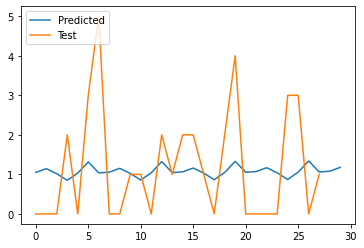

0.9947698353254183


In [134]:
#Sample prediction on single item
print(f'Predicting for items {ids[0]}')
train = np.asarray(df_training.astype(float))
val = np.asarray(df_val.astype(float))
test=np.asarray(df_test.astype(float))
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
# print(results.summary())
plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')
plt.show()
val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
# print(np.sqrt(val))
res=np.sqrt(val)/np.std(test)
print(res)
rmse_items.append(res)

#### Running on all the items

#### Calculating RMSE for items

In [183]:
rmse_items=[]

In [ ]:
#pipeline to predict on all item sales (30,490)
count=1
for item in ids[]:
  temp=df_train.loc[df_train['id'] == item]
  temp=temp.iloc[:,6:]
  temp = temp.T
  df_training = temp[:1885]
  df_val = temp[1885:1913]
  df_test = temp[1913:1942]
  # print(df_training.shape)
  # print(df_val.shape)
  # print(df_test.shape)
  print(f'Predicting for items {item} with count {count}')
  train = np.asarray(df_training.astype(float))
  val = np.asarray(df_val.astype(float))
  test=np.asarray(df_test.astype(float))
  mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
  results=mod.fit()
  # print(results.summary())
  # if count%10==0:
  #   plt.plot(results.predict(start = 1913, end = 1942), label = 'Predicted')
  #   plt.plot(test, label = 'Test')
  #   plt.legend(loc = 'upper left')
  #   plt.show()
  val=mean_squared_error(results.predict(start = 1913, end = 1940), test)
  # print(np.sqrt(val))
  res=np.sqrt(val)/np.std(test)
  # print(res)
  rmse_items.append(res)
  count+=1

Predicting for items HOBBIES_1_106_CA_1_evaluation with count 1
Predicting for items HOBBIES_1_107_CA_1_evaluation with count 2


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_108_CA_1_evaluation with count 3
Predicting for items HOBBIES_1_109_CA_1_evaluation with count 4
Predicting for items HOBBIES_1_110_CA_1_evaluation with count 5
Predicting for items HOBBIES_1_111_CA_1_evaluation with count 6
Predicting for items HOBBIES_1_112_CA_1_evaluation with count 7
Predicting for items HOBBIES_1_113_CA_1_evaluation with count 8
Predicting for items HOBBIES_1_114_CA_1_evaluation with count 9
Predicting for items HOBBIES_1_115_CA_1_evaluation with count 10
Predicting for items HOBBIES_1_116_CA_1_evaluation with count 11
Predicting for items HOBBIES_1_117_CA_1_evaluation with count 12
Predicting for items HOBBIES_1_118_CA_1_evaluation with count 13
Predicting for items HOBBIES_1_119_CA_1_evaluation with count 14
Predicting for items HOBBIES_1_120_CA_1_evaluation with count 15
Predicting for items HOBBIES_1_121_CA_1_evaluation with count 16
Predicting for items HOBBIES_1_122_CA_1_evaluation with count 17
Predicting for items HOBBIES_1_1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_137_CA_1_evaluation with count 32
Predicting for items HOBBIES_1_138_CA_1_evaluation with count 33
Predicting for items HOBBIES_1_139_CA_1_evaluation with count 34
Predicting for items HOBBIES_1_140_CA_1_evaluation with count 35
Predicting for items HOBBIES_1_141_CA_1_evaluation with count 36
Predicting for items HOBBIES_1_142_CA_1_evaluation with count 37
Predicting for items HOBBIES_1_143_CA_1_evaluation with count 38
Predicting for items HOBBIES_1_144_CA_1_evaluation with count 39
Predicting for items HOBBIES_1_145_CA_1_evaluation with count 40
Predicting for items HOBBIES_1_146_CA_1_evaluation with count 41
Predicting for items HOBBIES_1_147_CA_1_evaluation with count 42
Predicting for items HOBBIES_1_148_CA_1_evaluation with count 43
Predicting for items HOBBIES_1_149_CA_1_evaluation with count 44
Predicting for items HOBBIES_1_150_CA_1_evaluation with count 45
Predicting for items HOBBIES_1_151_CA_1_evaluation with count 46
Predicting for items HOBB

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_193_CA_1_evaluation with count 87
Predicting for items HOBBIES_1_194_CA_1_evaluation with count 88
Predicting for items HOBBIES_1_195_CA_1_evaluation with count 89
Predicting for items HOBBIES_1_197_CA_1_evaluation with count 90
Predicting for items HOBBIES_1_198_CA_1_evaluation with count 91
Predicting for items HOBBIES_1_199_CA_1_evaluation with count 92
Predicting for items HOBBIES_1_200_CA_1_evaluation with count 93
Predicting for items HOBBIES_1_201_CA_1_evaluation with count 94
Predicting for items HOBBIES_1_202_CA_1_evaluation with count 95
Predicting for items HOBBIES_1_203_CA_1_evaluation with count 96
Predicting for items HOBBIES_1_204_CA_1_evaluation with count 97
Predicting for items HOBBIES_1_205_CA_1_evaluation with count 98
Predicting for items HOBBIES_1_206_CA_1_evaluation with count 99
Predicting for items HOBBIES_1_207_CA_1_evaluation with count 100
Predicting for items HOBBIES_1_208_CA_1_evaluation with count 101
Predicting for items HO

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_211_CA_1_evaluation with count 104
Predicting for items HOBBIES_1_212_CA_1_evaluation with count 105
Predicting for items HOBBIES_1_213_CA_1_evaluation with count 106
Predicting for items HOBBIES_1_214_CA_1_evaluation with count 107
Predicting for items HOBBIES_1_215_CA_1_evaluation with count 108
Predicting for items HOBBIES_1_216_CA_1_evaluation with count 109
Predicting for items HOBBIES_1_217_CA_1_evaluation with count 110
Predicting for items HOBBIES_1_218_CA_1_evaluation with count 111
Predicting for items HOBBIES_1_219_CA_1_evaluation with count 112
Predicting for items HOBBIES_1_220_CA_1_evaluation with count 113
Predicting for items HOBBIES_1_221_CA_1_evaluation with count 114
Predicting for items HOBBIES_1_223_CA_1_evaluation with count 115
Predicting for items HOBBIES_1_224_CA_1_evaluation with count 116
Predicting for items HOBBIES_1_225_CA_1_evaluation with count 117
Predicting for items HOBBIES_1_226_CA_1_evaluation with count 118
Predicting

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_303_CA_1_evaluation with count 194
Predicting for items HOBBIES_1_304_CA_1_evaluation with count 195
Predicting for items HOBBIES_1_305_CA_1_evaluation with count 196
Predicting for items HOBBIES_1_306_CA_1_evaluation with count 197
Predicting for items HOBBIES_1_307_CA_1_evaluation with count 198
Predicting for items HOBBIES_1_308_CA_1_evaluation with count 199
Predicting for items HOBBIES_1_309_CA_1_evaluation with count 200
Predicting for items HOBBIES_1_310_CA_1_evaluation with count 201
Predicting for items HOBBIES_1_311_CA_1_evaluation with count 202


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_312_CA_1_evaluation with count 203
Predicting for items HOBBIES_1_313_CA_1_evaluation with count 204
Predicting for items HOBBIES_1_314_CA_1_evaluation with count 205
Predicting for items HOBBIES_1_315_CA_1_evaluation with count 206
Predicting for items HOBBIES_1_316_CA_1_evaluation with count 207
Predicting for items HOBBIES_1_317_CA_1_evaluation with count 208
Predicting for items HOBBIES_1_318_CA_1_evaluation with count 209
Predicting for items HOBBIES_1_319_CA_1_evaluation with count 210
Predicting for items HOBBIES_1_320_CA_1_evaluation with count 211
Predicting for items HOBBIES_1_321_CA_1_evaluation with count 212
Predicting for items HOBBIES_1_322_CA_1_evaluation with count 213
Predicting for items HOBBIES_1_323_CA_1_evaluation with count 214
Predicting for items HOBBIES_1_324_CA_1_evaluation with count 215
Predicting for items HOBBIES_1_325_CA_1_evaluation with count 216
Predicting for items HOBBIES_1_326_CA_1_evaluation with count 217
Predicting

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_337_CA_1_evaluation with count 228
Predicting for items HOBBIES_1_338_CA_1_evaluation with count 229
Predicting for items HOBBIES_1_339_CA_1_evaluation with count 230
Predicting for items HOBBIES_1_340_CA_1_evaluation with count 231
Predicting for items HOBBIES_1_341_CA_1_evaluation with count 232
Predicting for items HOBBIES_1_342_CA_1_evaluation with count 233
Predicting for items HOBBIES_1_343_CA_1_evaluation with count 234
Predicting for items HOBBIES_1_344_CA_1_evaluation with count 235
Predicting for items HOBBIES_1_345_CA_1_evaluation with count 236
Predicting for items HOBBIES_1_346_CA_1_evaluation with count 237
Predicting for items HOBBIES_1_347_CA_1_evaluation with count 238


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_348_CA_1_evaluation with count 239
Predicting for items HOBBIES_1_349_CA_1_evaluation with count 240
Predicting for items HOBBIES_1_350_CA_1_evaluation with count 241
Predicting for items HOBBIES_1_351_CA_1_evaluation with count 242
Predicting for items HOBBIES_1_352_CA_1_evaluation with count 243
Predicting for items HOBBIES_1_353_CA_1_evaluation with count 244
Predicting for items HOBBIES_1_354_CA_1_evaluation with count 245
Predicting for items HOBBIES_1_355_CA_1_evaluation with count 246
Predicting for items HOBBIES_1_356_CA_1_evaluation with count 247
Predicting for items HOBBIES_1_357_CA_1_evaluation with count 248
Predicting for items HOBBIES_1_358_CA_1_evaluation with count 249
Predicting for items HOBBIES_1_359_CA_1_evaluation with count 250
Predicting for items HOBBIES_1_360_CA_1_evaluation with count 251
Predicting for items HOBBIES_1_361_CA_1_evaluation with count 252
Predicting for items HOBBIES_1_362_CA_1_evaluation with count 253
Predicting

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_390_CA_1_evaluation with count 281
Predicting for items HOBBIES_1_391_CA_1_evaluation with count 282
Predicting for items HOBBIES_1_392_CA_1_evaluation with count 283
Predicting for items HOBBIES_1_393_CA_1_evaluation with count 284
Predicting for items HOBBIES_1_394_CA_1_evaluation with count 285
Predicting for items HOBBIES_1_395_CA_1_evaluation with count 286
Predicting for items HOBBIES_1_396_CA_1_evaluation with count 287


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_397_CA_1_evaluation with count 288
Predicting for items HOBBIES_1_398_CA_1_evaluation with count 289
Predicting for items HOBBIES_1_399_CA_1_evaluation with count 290
Predicting for items HOBBIES_1_400_CA_1_evaluation with count 291
Predicting for items HOBBIES_1_401_CA_1_evaluation with count 292
Predicting for items HOBBIES_1_402_CA_1_evaluation with count 293
Predicting for items HOBBIES_1_403_CA_1_evaluation with count 294
Predicting for items HOBBIES_1_404_CA_1_evaluation with count 295
Predicting for items HOBBIES_1_405_CA_1_evaluation with count 296
Predicting for items HOBBIES_1_406_CA_1_evaluation with count 297
Predicting for items HOBBIES_1_407_CA_1_evaluation with count 298
Predicting for items HOBBIES_1_408_CA_1_evaluation with count 299
Predicting for items HOBBIES_1_409_CA_1_evaluation with count 300
Predicting for items HOBBIES_1_410_CA_1_evaluation with count 301
Predicting for items HOBBIES_1_411_CA_1_evaluation with count 302
Predicting

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_418_CA_1_evaluation with count 309
Predicting for items HOBBIES_1_419_CA_1_evaluation with count 310
Predicting for items HOBBIES_1_420_CA_1_evaluation with count 311
Predicting for items HOBBIES_1_421_CA_1_evaluation with count 312
Predicting for items HOBBIES_1_422_CA_1_evaluation with count 313
Predicting for items HOBBIES_1_423_CA_1_evaluation with count 314
Predicting for items HOBBIES_1_424_CA_1_evaluation with count 315
Predicting for items HOBBIES_2_001_CA_1_evaluation with count 316
Predicting for items HOBBIES_2_002_CA_1_evaluation with count 317
Predicting for items HOBBIES_2_003_CA_1_evaluation with count 318
Predicting for items HOBBIES_2_004_CA_1_evaluation with count 319
Predicting for items HOBBIES_2_005_CA_1_evaluation with count 320
Predicting for items HOBBIES_2_006_CA_1_evaluation with count 321
Predicting for items HOBBIES_2_007_CA_1_evaluation with count 322
Predicting for items HOBBIES_2_008_CA_1_evaluation with count 323
Predicting

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_013_CA_1_evaluation with count 328
Predicting for items HOBBIES_2_014_CA_1_evaluation with count 329
Predicting for items HOBBIES_2_015_CA_1_evaluation with count 330
Predicting for items HOBBIES_2_016_CA_1_evaluation with count 331
Predicting for items HOBBIES_2_017_CA_1_evaluation with count 332
Predicting for items HOBBIES_2_018_CA_1_evaluation with count 333
Predicting for items HOBBIES_2_019_CA_1_evaluation with count 334
Predicting for items HOBBIES_2_020_CA_1_evaluation with count 335
Predicting for items HOBBIES_2_021_CA_1_evaluation with count 336


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_022_CA_1_evaluation with count 337
Predicting for items HOBBIES_2_023_CA_1_evaluation with count 338


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_024_CA_1_evaluation with count 339
Predicting for items HOBBIES_2_025_CA_1_evaluation with count 340
Predicting for items HOBBIES_2_026_CA_1_evaluation with count 341
Predicting for items HOBBIES_2_027_CA_1_evaluation with count 342
Predicting for items HOBBIES_2_028_CA_1_evaluation with count 343
Predicting for items HOBBIES_2_029_CA_1_evaluation with count 344
Predicting for items HOBBIES_2_030_CA_1_evaluation with count 345
Predicting for items HOBBIES_2_031_CA_1_evaluation with count 346
Predicting for items HOBBIES_2_032_CA_1_evaluation with count 347
Predicting for items HOBBIES_2_033_CA_1_evaluation with count 348
Predicting for items HOBBIES_2_034_CA_1_evaluation with count 349
Predicting for items HOBBIES_2_035_CA_1_evaluation with count 350
Predicting for items HOBBIES_2_036_CA_1_evaluation with count 351
Predicting for items HOBBIES_2_037_CA_1_evaluation with count 352


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_038_CA_1_evaluation with count 353
Predicting for items HOBBIES_2_039_CA_1_evaluation with count 354
Predicting for items HOBBIES_2_040_CA_1_evaluation with count 355


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_041_CA_1_evaluation with count 356
Predicting for items HOBBIES_2_042_CA_1_evaluation with count 357
Predicting for items HOBBIES_2_043_CA_1_evaluation with count 358
Predicting for items HOBBIES_2_044_CA_1_evaluation with count 359
Predicting for items HOBBIES_2_045_CA_1_evaluation with count 360
Predicting for items HOBBIES_2_046_CA_1_evaluation with count 361
Predicting for items HOBBIES_2_047_CA_1_evaluation with count 362
Predicting for items HOBBIES_2_048_CA_1_evaluation with count 363
Predicting for items HOBBIES_2_049_CA_1_evaluation with count 364


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_050_CA_1_evaluation with count 365
Predicting for items HOBBIES_2_051_CA_1_evaluation with count 366
Predicting for items HOBBIES_2_052_CA_1_evaluation with count 367
Predicting for items HOBBIES_2_053_CA_1_evaluation with count 368


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_054_CA_1_evaluation with count 369


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_055_CA_1_evaluation with count 370
Predicting for items HOBBIES_2_056_CA_1_evaluation with count 371
Predicting for items HOBBIES_2_057_CA_1_evaluation with count 372


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_058_CA_1_evaluation with count 373
Predicting for items HOBBIES_2_059_CA_1_evaluation with count 374
Predicting for items HOBBIES_2_060_CA_1_evaluation with count 375
Predicting for items HOBBIES_2_061_CA_1_evaluation with count 376
Predicting for items HOBBIES_2_062_CA_1_evaluation with count 377
Predicting for items HOBBIES_2_063_CA_1_evaluation with count 378
Predicting for items HOBBIES_2_064_CA_1_evaluation with count 379
Predicting for items HOBBIES_2_065_CA_1_evaluation with count 380
Predicting for items HOBBIES_2_066_CA_1_evaluation with count 381


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_067_CA_1_evaluation with count 382
Predicting for items HOBBIES_2_068_CA_1_evaluation with count 383
Predicting for items HOBBIES_2_069_CA_1_evaluation with count 384
Predicting for items HOBBIES_2_070_CA_1_evaluation with count 385
Predicting for items HOBBIES_2_071_CA_1_evaluation with count 386
Predicting for items HOBBIES_2_072_CA_1_evaluation with count 387
Predicting for items HOBBIES_2_073_CA_1_evaluation with count 388
Predicting for items HOBBIES_2_074_CA_1_evaluation with count 389
Predicting for items HOBBIES_2_075_CA_1_evaluation with count 390
Predicting for items HOBBIES_2_076_CA_1_evaluation with count 391
Predicting for items HOBBIES_2_077_CA_1_evaluation with count 392
Predicting for items HOBBIES_2_078_CA_1_evaluation with count 393
Predicting for items HOBBIES_2_079_CA_1_evaluation with count 394
Predicting for items HOBBIES_2_080_CA_1_evaluation with count 395
Predicting for items HOBBIES_2_081_CA_1_evaluation with count 396
Predicting

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_091_CA_1_evaluation with count 406
Predicting for items HOBBIES_2_092_CA_1_evaluation with count 407
Predicting for items HOBBIES_2_093_CA_1_evaluation with count 408
Predicting for items HOBBIES_2_094_CA_1_evaluation with count 409
Predicting for items HOBBIES_2_095_CA_1_evaluation with count 410
Predicting for items HOBBIES_2_096_CA_1_evaluation with count 411
Predicting for items HOBBIES_2_097_CA_1_evaluation with count 412
Predicting for items HOBBIES_2_098_CA_1_evaluation with count 413
Predicting for items HOBBIES_2_099_CA_1_evaluation with count 414


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_100_CA_1_evaluation with count 415
Predicting for items HOBBIES_2_101_CA_1_evaluation with count 416
Predicting for items HOBBIES_2_102_CA_1_evaluation with count 417
Predicting for items HOBBIES_2_103_CA_1_evaluation with count 418
Predicting for items HOBBIES_2_104_CA_1_evaluation with count 419


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_105_CA_1_evaluation with count 420
Predicting for items HOBBIES_2_106_CA_1_evaluation with count 421
Predicting for items HOBBIES_2_107_CA_1_evaluation with count 422
Predicting for items HOBBIES_2_108_CA_1_evaluation with count 423
Predicting for items HOBBIES_2_109_CA_1_evaluation with count 424
Predicting for items HOBBIES_2_110_CA_1_evaluation with count 425
Predicting for items HOBBIES_2_111_CA_1_evaluation with count 426
Predicting for items HOBBIES_2_112_CA_1_evaluation with count 427
Predicting for items HOBBIES_2_113_CA_1_evaluation with count 428
Predicting for items HOBBIES_2_114_CA_1_evaluation with count 429
Predicting for items HOBBIES_2_115_CA_1_evaluation with count 430
Predicting for items HOBBIES_2_116_CA_1_evaluation with count 431
Predicting for items HOBBIES_2_117_CA_1_evaluation with count 432
Predicting for items HOBBIES_2_118_CA_1_evaluation with count 433
Predicting for items HOBBIES_2_119_CA_1_evaluation with count 434


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_120_CA_1_evaluation with count 435
Predicting for items HOBBIES_2_121_CA_1_evaluation with count 436
Predicting for items HOBBIES_2_122_CA_1_evaluation with count 437
Predicting for items HOBBIES_2_123_CA_1_evaluation with count 438
Predicting for items HOBBIES_2_124_CA_1_evaluation with count 439
Predicting for items HOBBIES_2_125_CA_1_evaluation with count 440
Predicting for items HOBBIES_2_126_CA_1_evaluation with count 441
Predicting for items HOBBIES_2_127_CA_1_evaluation with count 442
Predicting for items HOBBIES_2_128_CA_1_evaluation with count 443
Predicting for items HOBBIES_2_129_CA_1_evaluation with count 444
Predicting for items HOBBIES_2_130_CA_1_evaluation with count 445
Predicting for items HOBBIES_2_131_CA_1_evaluation with count 446
Predicting for items HOBBIES_2_132_CA_1_evaluation with count 447
Predicting for items HOBBIES_2_133_CA_1_evaluation with count 448
Predicting for items HOBBIES_2_134_CA_1_evaluation with count 449


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_135_CA_1_evaluation with count 450
Predicting for items HOBBIES_2_136_CA_1_evaluation with count 451
Predicting for items HOBBIES_2_137_CA_1_evaluation with count 452
Predicting for items HOBBIES_2_138_CA_1_evaluation with count 453
Predicting for items HOBBIES_2_139_CA_1_evaluation with count 454
Predicting for items HOBBIES_2_140_CA_1_evaluation with count 455
Predicting for items HOBBIES_2_141_CA_1_evaluation with count 456
Predicting for items HOBBIES_2_142_CA_1_evaluation with count 457


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_143_CA_1_evaluation with count 458
Predicting for items HOBBIES_2_144_CA_1_evaluation with count 459
Predicting for items HOBBIES_2_145_CA_1_evaluation with count 460


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_146_CA_1_evaluation with count 461
Predicting for items HOBBIES_2_147_CA_1_evaluation with count 462
Predicting for items HOBBIES_2_148_CA_1_evaluation with count 463
Predicting for items HOBBIES_2_149_CA_1_evaluation with count 464
Predicting for items HOUSEHOLD_1_001_CA_1_evaluation with count 465
Predicting for items HOUSEHOLD_1_002_CA_1_evaluation with count 466
Predicting for items HOUSEHOLD_1_003_CA_1_evaluation with count 467
Predicting for items HOUSEHOLD_1_004_CA_1_evaluation with count 468
Predicting for items HOUSEHOLD_1_005_CA_1_evaluation with count 469
Predicting for items HOUSEHOLD_1_006_CA_1_evaluation with count 470
Predicting for items HOUSEHOLD_1_007_CA_1_evaluation with count 471
Predicting for items HOUSEHOLD_1_008_CA_1_evaluation with count 472
Predicting for items HOUSEHOLD_1_009_CA_1_evaluation with count 473
Predicting for items HOUSEHOLD_1_010_CA_1_evaluation with count 474
Predicting for items HOUSEHOLD_1_011_CA_1_evaluation wit

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_062_CA_1_evaluation with count 524
Predicting for items HOUSEHOLD_1_063_CA_1_evaluation with count 525
Predicting for items HOUSEHOLD_1_064_CA_1_evaluation with count 526
Predicting for items HOUSEHOLD_1_065_CA_1_evaluation with count 527
Predicting for items HOUSEHOLD_1_066_CA_1_evaluation with count 528
Predicting for items HOUSEHOLD_1_067_CA_1_evaluation with count 529
Predicting for items HOUSEHOLD_1_068_CA_1_evaluation with count 530
Predicting for items HOUSEHOLD_1_069_CA_1_evaluation with count 531
Predicting for items HOUSEHOLD_1_070_CA_1_evaluation with count 532
Predicting for items HOUSEHOLD_1_071_CA_1_evaluation with count 533
Predicting for items HOUSEHOLD_1_072_CA_1_evaluation with count 534
Predicting for items HOUSEHOLD_1_073_CA_1_evaluation with count 535
Predicting for items HOUSEHOLD_1_074_CA_1_evaluation with count 536
Predicting for items HOUSEHOLD_1_075_CA_1_evaluation with count 537
Predicting for items HOUSEHOLD_1_076_CA_1_evalua

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_093_CA_1_evaluation with count 554
Predicting for items HOUSEHOLD_1_094_CA_1_evaluation with count 555
Predicting for items HOUSEHOLD_1_095_CA_1_evaluation with count 556
Predicting for items HOUSEHOLD_1_096_CA_1_evaluation with count 557
Predicting for items HOUSEHOLD_1_097_CA_1_evaluation with count 558
Predicting for items HOUSEHOLD_1_098_CA_1_evaluation with count 559
Predicting for items HOUSEHOLD_1_099_CA_1_evaluation with count 560
Predicting for items HOUSEHOLD_1_100_CA_1_evaluation with count 561
Predicting for items HOUSEHOLD_1_101_CA_1_evaluation with count 562
Predicting for items HOUSEHOLD_1_102_CA_1_evaluation with count 563
Predicting for items HOUSEHOLD_1_103_CA_1_evaluation with count 564
Predicting for items HOUSEHOLD_1_104_CA_1_evaluation with count 565
Predicting for items HOUSEHOLD_1_105_CA_1_evaluation with count 566
Predicting for items HOUSEHOLD_1_106_CA_1_evaluation with count 567
Predicting for items HOUSEHOLD_1_107_CA_1_evalua

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_178_CA_1_evaluation with count 638
Predicting for items HOUSEHOLD_1_179_CA_1_evaluation with count 639
Predicting for items HOUSEHOLD_1_180_CA_1_evaluation with count 640
Predicting for items HOUSEHOLD_1_181_CA_1_evaluation with count 641
Predicting for items HOUSEHOLD_1_182_CA_1_evaluation with count 642
Predicting for items HOUSEHOLD_1_183_CA_1_evaluation with count 643
Predicting for items HOUSEHOLD_1_184_CA_1_evaluation with count 644
Predicting for items HOUSEHOLD_1_185_CA_1_evaluation with count 645
Predicting for items HOUSEHOLD_1_186_CA_1_evaluation with count 646
Predicting for items HOUSEHOLD_1_187_CA_1_evaluation with count 647
Predicting for items HOUSEHOLD_1_188_CA_1_evaluation with count 648
Predicting for items HOUSEHOLD_1_189_CA_1_evaluation with count 649
Predicting for items HOUSEHOLD_1_190_CA_1_evaluation with count 650
Predicting for items HOUSEHOLD_1_191_CA_1_evaluation with count 651
Predicting for items HOUSEHOLD_1_192_CA_1_evalua

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_298_CA_1_evaluation with count 756
Predicting for items HOUSEHOLD_1_299_CA_1_evaluation with count 757
Predicting for items HOUSEHOLD_1_300_CA_1_evaluation with count 758
Predicting for items HOUSEHOLD_1_301_CA_1_evaluation with count 759
Predicting for items HOUSEHOLD_1_302_CA_1_evaluation with count 760
Predicting for items HOUSEHOLD_1_303_CA_1_evaluation with count 761
Predicting for items HOUSEHOLD_1_304_CA_1_evaluation with count 762
Predicting for items HOUSEHOLD_1_305_CA_1_evaluation with count 763
Predicting for items HOUSEHOLD_1_306_CA_1_evaluation with count 764
Predicting for items HOUSEHOLD_1_307_CA_1_evaluation with count 765
Predicting for items HOUSEHOLD_1_308_CA_1_evaluation with count 766
Predicting for items HOUSEHOLD_1_309_CA_1_evaluation with count 767
Predicting for items HOUSEHOLD_1_310_CA_1_evaluation with count 768


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_311_CA_1_evaluation with count 769
Predicting for items HOUSEHOLD_1_312_CA_1_evaluation with count 770
Predicting for items HOUSEHOLD_1_313_CA_1_evaluation with count 771
Predicting for items HOUSEHOLD_1_314_CA_1_evaluation with count 772
Predicting for items HOUSEHOLD_1_315_CA_1_evaluation with count 773
Predicting for items HOUSEHOLD_1_316_CA_1_evaluation with count 774
Predicting for items HOUSEHOLD_1_317_CA_1_evaluation with count 775
Predicting for items HOUSEHOLD_1_318_CA_1_evaluation with count 776
Predicting for items HOUSEHOLD_1_319_CA_1_evaluation with count 777
Predicting for items HOUSEHOLD_1_320_CA_1_evaluation with count 778
Predicting for items HOUSEHOLD_1_321_CA_1_evaluation with count 779
Predicting for items HOUSEHOLD_1_322_CA_1_evaluation with count 780
Predicting for items HOUSEHOLD_1_323_CA_1_evaluation with count 781


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_324_CA_1_evaluation with count 782
Predicting for items HOUSEHOLD_1_325_CA_1_evaluation with count 783
Predicting for items HOUSEHOLD_1_326_CA_1_evaluation with count 784
Predicting for items HOUSEHOLD_1_327_CA_1_evaluation with count 785
Predicting for items HOUSEHOLD_1_328_CA_1_evaluation with count 786
Predicting for items HOUSEHOLD_1_329_CA_1_evaluation with count 787
Predicting for items HOUSEHOLD_1_330_CA_1_evaluation with count 788
Predicting for items HOUSEHOLD_1_331_CA_1_evaluation with count 789
Predicting for items HOUSEHOLD_1_332_CA_1_evaluation with count 790
Predicting for items HOUSEHOLD_1_333_CA_1_evaluation with count 791
Predicting for items HOUSEHOLD_1_334_CA_1_evaluation with count 792
Predicting for items HOUSEHOLD_1_335_CA_1_evaluation with count 793
Predicting for items HOUSEHOLD_1_336_CA_1_evaluation with count 794
Predicting for items HOUSEHOLD_1_337_CA_1_evaluation with count 795
Predicting for items HOUSEHOLD_1_338_CA_1_evalua

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_357_CA_1_evaluation with count 814
Predicting for items HOUSEHOLD_1_358_CA_1_evaluation with count 815
Predicting for items HOUSEHOLD_1_359_CA_1_evaluation with count 816
Predicting for items HOUSEHOLD_1_360_CA_1_evaluation with count 817
Predicting for items HOUSEHOLD_1_361_CA_1_evaluation with count 818
Predicting for items HOUSEHOLD_1_362_CA_1_evaluation with count 819
Predicting for items HOUSEHOLD_1_363_CA_1_evaluation with count 820
Predicting for items HOUSEHOLD_1_364_CA_1_evaluation with count 821
Predicting for items HOUSEHOLD_1_365_CA_1_evaluation with count 822
Predicting for items HOUSEHOLD_1_366_CA_1_evaluation with count 823


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_367_CA_1_evaluation with count 824
Predicting for items HOUSEHOLD_1_368_CA_1_evaluation with count 825
Predicting for items HOUSEHOLD_1_369_CA_1_evaluation with count 826
Predicting for items HOUSEHOLD_1_370_CA_1_evaluation with count 827
Predicting for items HOUSEHOLD_1_371_CA_1_evaluation with count 828
Predicting for items HOUSEHOLD_1_372_CA_1_evaluation with count 829
Predicting for items HOUSEHOLD_1_373_CA_1_evaluation with count 830
Predicting for items HOUSEHOLD_1_374_CA_1_evaluation with count 831
Predicting for items HOUSEHOLD_1_375_CA_1_evaluation with count 832
Predicting for items HOUSEHOLD_1_376_CA_1_evaluation with count 833
Predicting for items HOUSEHOLD_1_377_CA_1_evaluation with count 834
Predicting for items HOUSEHOLD_1_378_CA_1_evaluation with count 835


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_379_CA_1_evaluation with count 836
Predicting for items HOUSEHOLD_1_380_CA_1_evaluation with count 837
Predicting for items HOUSEHOLD_1_381_CA_1_evaluation with count 838
Predicting for items HOUSEHOLD_1_382_CA_1_evaluation with count 839
Predicting for items HOUSEHOLD_1_383_CA_1_evaluation with count 840
Predicting for items HOUSEHOLD_1_384_CA_1_evaluation with count 841
Predicting for items HOUSEHOLD_1_385_CA_1_evaluation with count 842
Predicting for items HOUSEHOLD_1_386_CA_1_evaluation with count 843
Predicting for items HOUSEHOLD_1_387_CA_1_evaluation with count 844
Predicting for items HOUSEHOLD_1_388_CA_1_evaluation with count 845
Predicting for items HOUSEHOLD_1_389_CA_1_evaluation with count 846
Predicting for items HOUSEHOLD_1_390_CA_1_evaluation with count 847
Predicting for items HOUSEHOLD_1_393_CA_1_evaluation with count 848
Predicting for items HOUSEHOLD_1_394_CA_1_evaluation with count 849
Predicting for items HOUSEHOLD_1_395_CA_1_evalua

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_428_CA_1_evaluation with count 883
Predicting for items HOUSEHOLD_1_429_CA_1_evaluation with count 884
Predicting for items HOUSEHOLD_1_430_CA_1_evaluation with count 885
Predicting for items HOUSEHOLD_1_431_CA_1_evaluation with count 886
Predicting for items HOUSEHOLD_1_432_CA_1_evaluation with count 887
Predicting for items HOUSEHOLD_1_433_CA_1_evaluation with count 888
Predicting for items HOUSEHOLD_1_434_CA_1_evaluation with count 889
Predicting for items HOUSEHOLD_1_435_CA_1_evaluation with count 890
Predicting for items HOUSEHOLD_1_436_CA_1_evaluation with count 891
Predicting for items HOUSEHOLD_1_437_CA_1_evaluation with count 892
Predicting for items HOUSEHOLD_1_438_CA_1_evaluation with count 893
Predicting for items HOUSEHOLD_1_439_CA_1_evaluation with count 894
Predicting for items HOUSEHOLD_1_440_CA_1_evaluation with count 895
Predicting for items HOUSEHOLD_1_441_CA_1_evaluation with count 896
Predicting for items HOUSEHOLD_1_442_CA_1_evalua

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_453_CA_1_evaluation with count 908
Predicting for items HOUSEHOLD_1_454_CA_1_evaluation with count 909
Predicting for items HOUSEHOLD_1_455_CA_1_evaluation with count 910
Predicting for items HOUSEHOLD_1_456_CA_1_evaluation with count 911
Predicting for items HOUSEHOLD_1_457_CA_1_evaluation with count 912
Predicting for items HOUSEHOLD_1_458_CA_1_evaluation with count 913
Predicting for items HOUSEHOLD_1_459_CA_1_evaluation with count 914
Predicting for items HOUSEHOLD_1_460_CA_1_evaluation with count 915
Predicting for items HOUSEHOLD_1_461_CA_1_evaluation with count 916
Predicting for items HOUSEHOLD_1_462_CA_1_evaluation with count 917
Predicting for items HOUSEHOLD_1_463_CA_1_evaluation with count 918
Predicting for items HOUSEHOLD_1_464_CA_1_evaluation with count 919
Predicting for items HOUSEHOLD_1_465_CA_1_evaluation with count 920
Predicting for items HOUSEHOLD_1_466_CA_1_evaluation with count 921
Predicting for items HOUSEHOLD_1_467_CA_1_evalua

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_490_CA_1_evaluation with count 945
Predicting for items HOUSEHOLD_1_491_CA_1_evaluation with count 946
Predicting for items HOUSEHOLD_1_492_CA_1_evaluation with count 947
Predicting for items HOUSEHOLD_1_493_CA_1_evaluation with count 948
Predicting for items HOUSEHOLD_1_494_CA_1_evaluation with count 949
Predicting for items HOUSEHOLD_1_495_CA_1_evaluation with count 950
Predicting for items HOUSEHOLD_1_496_CA_1_evaluation with count 951
Predicting for items HOUSEHOLD_1_497_CA_1_evaluation with count 952
Predicting for items HOUSEHOLD_1_498_CA_1_evaluation with count 953
Predicting for items HOUSEHOLD_1_499_CA_1_evaluation with count 954
Predicting for items HOUSEHOLD_1_500_CA_1_evaluation with count 955
Predicting for items HOUSEHOLD_1_501_CA_1_evaluation with count 956
Predicting for items HOUSEHOLD_1_502_CA_1_evaluation with count 957
Predicting for items HOUSEHOLD_1_503_CA_1_evaluation with count 958
Predicting for items HOUSEHOLD_1_504_CA_1_evalua

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_001_CA_1_evaluation with count 997
Predicting for items HOUSEHOLD_2_002_CA_1_evaluation with count 998
Predicting for items HOUSEHOLD_2_003_CA_1_evaluation with count 999
Predicting for items HOUSEHOLD_2_004_CA_1_evaluation with count 1000
Predicting for items HOUSEHOLD_2_005_CA_1_evaluation with count 1001


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_006_CA_1_evaluation with count 1002
Predicting for items HOUSEHOLD_2_007_CA_1_evaluation with count 1003
Predicting for items HOUSEHOLD_2_008_CA_1_evaluation with count 1004
Predicting for items HOUSEHOLD_2_009_CA_1_evaluation with count 1005
Predicting for items HOUSEHOLD_2_010_CA_1_evaluation with count 1006
Predicting for items HOUSEHOLD_2_011_CA_1_evaluation with count 1007
Predicting for items HOUSEHOLD_2_012_CA_1_evaluation with count 1008
Predicting for items HOUSEHOLD_2_013_CA_1_evaluation with count 1009
Predicting for items HOUSEHOLD_2_014_CA_1_evaluation with count 1010
Predicting for items HOUSEHOLD_2_015_CA_1_evaluation with count 1011
Predicting for items HOUSEHOLD_2_016_CA_1_evaluation with count 1012
Predicting for items HOUSEHOLD_2_017_CA_1_evaluation with count 1013
Predicting for items HOUSEHOLD_2_018_CA_1_evaluation with count 1014
Predicting for items HOUSEHOLD_2_019_CA_1_evaluation with count 1015
Predicting for items HOUSEHOLD_2_0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_028_CA_1_evaluation with count 1024
Predicting for items HOUSEHOLD_2_029_CA_1_evaluation with count 1025
Predicting for items HOUSEHOLD_2_030_CA_1_evaluation with count 1026
Predicting for items HOUSEHOLD_2_031_CA_1_evaluation with count 1027
Predicting for items HOUSEHOLD_2_032_CA_1_evaluation with count 1028
Predicting for items HOUSEHOLD_2_033_CA_1_evaluation with count 1029
Predicting for items HOUSEHOLD_2_034_CA_1_evaluation with count 1030
Predicting for items HOUSEHOLD_2_035_CA_1_evaluation with count 1031
Predicting for items HOUSEHOLD_2_036_CA_1_evaluation with count 1032
Predicting for items HOUSEHOLD_2_037_CA_1_evaluation with count 1033
Predicting for items HOUSEHOLD_2_038_CA_1_evaluation with count 1034
Predicting for items HOUSEHOLD_2_039_CA_1_evaluation with count 1035
Predicting for items HOUSEHOLD_2_040_CA_1_evaluation with count 1036


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_041_CA_1_evaluation with count 1037
Predicting for items HOUSEHOLD_2_042_CA_1_evaluation with count 1038
Predicting for items HOUSEHOLD_2_043_CA_1_evaluation with count 1039
Predicting for items HOUSEHOLD_2_044_CA_1_evaluation with count 1040
Predicting for items HOUSEHOLD_2_045_CA_1_evaluation with count 1041
Predicting for items HOUSEHOLD_2_046_CA_1_evaluation with count 1042
Predicting for items HOUSEHOLD_2_047_CA_1_evaluation with count 1043
Predicting for items HOUSEHOLD_2_048_CA_1_evaluation with count 1044
Predicting for items HOUSEHOLD_2_049_CA_1_evaluation with count 1045
Predicting for items HOUSEHOLD_2_050_CA_1_evaluation with count 1046


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_051_CA_1_evaluation with count 1047
Predicting for items HOUSEHOLD_2_052_CA_1_evaluation with count 1048
Predicting for items HOUSEHOLD_2_053_CA_1_evaluation with count 1049
Predicting for items HOUSEHOLD_2_054_CA_1_evaluation with count 1050
Predicting for items HOUSEHOLD_2_055_CA_1_evaluation with count 1051
Predicting for items HOUSEHOLD_2_056_CA_1_evaluation with count 1052
Predicting for items HOUSEHOLD_2_057_CA_1_evaluation with count 1053
Predicting for items HOUSEHOLD_2_058_CA_1_evaluation with count 1054
Predicting for items HOUSEHOLD_2_059_CA_1_evaluation with count 1055
Predicting for items HOUSEHOLD_2_060_CA_1_evaluation with count 1056
Predicting for items HOUSEHOLD_2_061_CA_1_evaluation with count 1057
Predicting for items HOUSEHOLD_2_062_CA_1_evaluation with count 1058
Predicting for items HOUSEHOLD_2_063_CA_1_evaluation with count 1059
Predicting for items HOUSEHOLD_2_064_CA_1_evaluation with count 1060
Predicting for items HOUSEHOLD_2_0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_074_CA_1_evaluation with count 1070
Predicting for items HOUSEHOLD_2_075_CA_1_evaluation with count 1071
Predicting for items HOUSEHOLD_2_076_CA_1_evaluation with count 1072
Predicting for items HOUSEHOLD_2_077_CA_1_evaluation with count 1073
Predicting for items HOUSEHOLD_2_078_CA_1_evaluation with count 1074
Predicting for items HOUSEHOLD_2_079_CA_1_evaluation with count 1075
Predicting for items HOUSEHOLD_2_080_CA_1_evaluation with count 1076
Predicting for items HOUSEHOLD_2_081_CA_1_evaluation with count 1077
Predicting for items HOUSEHOLD_2_082_CA_1_evaluation with count 1078
Predicting for items HOUSEHOLD_2_083_CA_1_evaluation with count 1079
Predicting for items HOUSEHOLD_2_084_CA_1_evaluation with count 1080
Predicting for items HOUSEHOLD_2_085_CA_1_evaluation with count 1081
Predicting for items HOUSEHOLD_2_086_CA_1_evaluation with count 1082
Predicting for items HOUSEHOLD_2_087_CA_1_evaluation with count 1083


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_088_CA_1_evaluation with count 1084
Predicting for items HOUSEHOLD_2_089_CA_1_evaluation with count 1085
Predicting for items HOUSEHOLD_2_090_CA_1_evaluation with count 1086
Predicting for items HOUSEHOLD_2_091_CA_1_evaluation with count 1087
Predicting for items HOUSEHOLD_2_092_CA_1_evaluation with count 1088
Predicting for items HOUSEHOLD_2_093_CA_1_evaluation with count 1089
Predicting for items HOUSEHOLD_2_094_CA_1_evaluation with count 1090
Predicting for items HOUSEHOLD_2_095_CA_1_evaluation with count 1091
Predicting for items HOUSEHOLD_2_096_CA_1_evaluation with count 1092
Predicting for items HOUSEHOLD_2_097_CA_1_evaluation with count 1093
Predicting for items HOUSEHOLD_2_098_CA_1_evaluation with count 1094
Predicting for items HOUSEHOLD_2_099_CA_1_evaluation with count 1095
Predicting for items HOUSEHOLD_2_100_CA_1_evaluation with count 1096
Predicting for items HOUSEHOLD_2_101_CA_1_evaluation with count 1097
Predicting for items HOUSEHOLD_2_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_108_CA_1_evaluation with count 1104


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_109_CA_1_evaluation with count 1105
Predicting for items HOUSEHOLD_2_110_CA_1_evaluation with count 1106
Predicting for items HOUSEHOLD_2_111_CA_1_evaluation with count 1107
Predicting for items HOUSEHOLD_2_112_CA_1_evaluation with count 1108
Predicting for items HOUSEHOLD_2_113_CA_1_evaluation with count 1109
Predicting for items HOUSEHOLD_2_114_CA_1_evaluation with count 1110
Predicting for items HOUSEHOLD_2_115_CA_1_evaluation with count 1111
Predicting for items HOUSEHOLD_2_116_CA_1_evaluation with count 1112
Predicting for items HOUSEHOLD_2_117_CA_1_evaluation with count 1113
Predicting for items HOUSEHOLD_2_118_CA_1_evaluation with count 1114
Predicting for items HOUSEHOLD_2_119_CA_1_evaluation with count 1115
Predicting for items HOUSEHOLD_2_120_CA_1_evaluation with count 1116
Predicting for items HOUSEHOLD_2_121_CA_1_evaluation with count 1117


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_122_CA_1_evaluation with count 1118
Predicting for items HOUSEHOLD_2_123_CA_1_evaluation with count 1119
Predicting for items HOUSEHOLD_2_124_CA_1_evaluation with count 1120
Predicting for items HOUSEHOLD_2_125_CA_1_evaluation with count 1121
Predicting for items HOUSEHOLD_2_126_CA_1_evaluation with count 1122
Predicting for items HOUSEHOLD_2_127_CA_1_evaluation with count 1123
Predicting for items HOUSEHOLD_2_128_CA_1_evaluation with count 1124
Predicting for items HOUSEHOLD_2_129_CA_1_evaluation with count 1125
Predicting for items HOUSEHOLD_2_130_CA_1_evaluation with count 1126
Predicting for items HOUSEHOLD_2_131_CA_1_evaluation with count 1127
Predicting for items HOUSEHOLD_2_132_CA_1_evaluation with count 1128
Predicting for items HOUSEHOLD_2_133_CA_1_evaluation with count 1129


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_134_CA_1_evaluation with count 1130
Predicting for items HOUSEHOLD_2_135_CA_1_evaluation with count 1131
Predicting for items HOUSEHOLD_2_136_CA_1_evaluation with count 1132
Predicting for items HOUSEHOLD_2_137_CA_1_evaluation with count 1133
Predicting for items HOUSEHOLD_2_138_CA_1_evaluation with count 1134
Predicting for items HOUSEHOLD_2_139_CA_1_evaluation with count 1135
Predicting for items HOUSEHOLD_2_140_CA_1_evaluation with count 1136
Predicting for items HOUSEHOLD_2_141_CA_1_evaluation with count 1137
Predicting for items HOUSEHOLD_2_142_CA_1_evaluation with count 1138
Predicting for items HOUSEHOLD_2_143_CA_1_evaluation with count 1139
Predicting for items HOUSEHOLD_2_144_CA_1_evaluation with count 1140


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_145_CA_1_evaluation with count 1141
Predicting for items HOUSEHOLD_2_146_CA_1_evaluation with count 1142
Predicting for items HOUSEHOLD_2_147_CA_1_evaluation with count 1143


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_148_CA_1_evaluation with count 1144
Predicting for items HOUSEHOLD_2_149_CA_1_evaluation with count 1145
Predicting for items HOUSEHOLD_2_150_CA_1_evaluation with count 1146
Predicting for items HOUSEHOLD_2_151_CA_1_evaluation with count 1147
Predicting for items HOUSEHOLD_2_152_CA_1_evaluation with count 1148
Predicting for items HOUSEHOLD_2_153_CA_1_evaluation with count 1149
Predicting for items HOUSEHOLD_2_154_CA_1_evaluation with count 1150
Predicting for items HOUSEHOLD_2_155_CA_1_evaluation with count 1151
Predicting for items HOUSEHOLD_2_156_CA_1_evaluation with count 1152
Predicting for items HOUSEHOLD_2_157_CA_1_evaluation with count 1153
Predicting for items HOUSEHOLD_2_158_CA_1_evaluation with count 1154
Predicting for items HOUSEHOLD_2_159_CA_1_evaluation with count 1155
Predicting for items HOUSEHOLD_2_160_CA_1_evaluation with count 1156
Predicting for items HOUSEHOLD_2_161_CA_1_evaluation with count 1157
Predicting for items HOUSEHOLD_2_1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_176_CA_1_evaluation with count 1172
Predicting for items HOUSEHOLD_2_177_CA_1_evaluation with count 1173
Predicting for items HOUSEHOLD_2_178_CA_1_evaluation with count 1174
Predicting for items HOUSEHOLD_2_179_CA_1_evaluation with count 1175


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_180_CA_1_evaluation with count 1176
Predicting for items HOUSEHOLD_2_182_CA_1_evaluation with count 1177
Predicting for items HOUSEHOLD_2_183_CA_1_evaluation with count 1178
Predicting for items HOUSEHOLD_2_184_CA_1_evaluation with count 1179
Predicting for items HOUSEHOLD_2_185_CA_1_evaluation with count 1180
Predicting for items HOUSEHOLD_2_186_CA_1_evaluation with count 1181
Predicting for items HOUSEHOLD_2_187_CA_1_evaluation with count 1182
Predicting for items HOUSEHOLD_2_188_CA_1_evaluation with count 1183
Predicting for items HOUSEHOLD_2_189_CA_1_evaluation with count 1184
Predicting for items HOUSEHOLD_2_190_CA_1_evaluation with count 1185
Predicting for items HOUSEHOLD_2_191_CA_1_evaluation with count 1186
Predicting for items HOUSEHOLD_2_192_CA_1_evaluation with count 1187


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_193_CA_1_evaluation with count 1188
Predicting for items HOUSEHOLD_2_194_CA_1_evaluation with count 1189
Predicting for items HOUSEHOLD_2_195_CA_1_evaluation with count 1190
Predicting for items HOUSEHOLD_2_196_CA_1_evaluation with count 1191
Predicting for items HOUSEHOLD_2_197_CA_1_evaluation with count 1192
Predicting for items HOUSEHOLD_2_198_CA_1_evaluation with count 1193
Predicting for items HOUSEHOLD_2_199_CA_1_evaluation with count 1194
Predicting for items HOUSEHOLD_2_200_CA_1_evaluation with count 1195
Predicting for items HOUSEHOLD_2_201_CA_1_evaluation with count 1196
Predicting for items HOUSEHOLD_2_202_CA_1_evaluation with count 1197


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_203_CA_1_evaluation with count 1198
Predicting for items HOUSEHOLD_2_204_CA_1_evaluation with count 1199
Predicting for items HOUSEHOLD_2_205_CA_1_evaluation with count 1200
Predicting for items HOUSEHOLD_2_206_CA_1_evaluation with count 1201
Predicting for items HOUSEHOLD_2_207_CA_1_evaluation with count 1202
Predicting for items HOUSEHOLD_2_208_CA_1_evaluation with count 1203
Predicting for items HOUSEHOLD_2_209_CA_1_evaluation with count 1204
Predicting for items HOUSEHOLD_2_210_CA_1_evaluation with count 1205
Predicting for items HOUSEHOLD_2_211_CA_1_evaluation with count 1206
Predicting for items HOUSEHOLD_2_212_CA_1_evaluation with count 1207
Predicting for items HOUSEHOLD_2_213_CA_1_evaluation with count 1208
Predicting for items HOUSEHOLD_2_214_CA_1_evaluation with count 1209
Predicting for items HOUSEHOLD_2_215_CA_1_evaluation with count 1210
Predicting for items HOUSEHOLD_2_216_CA_1_evaluation with count 1211


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_217_CA_1_evaluation with count 1212
Predicting for items HOUSEHOLD_2_218_CA_1_evaluation with count 1213
Predicting for items HOUSEHOLD_2_219_CA_1_evaluation with count 1214
Predicting for items HOUSEHOLD_2_220_CA_1_evaluation with count 1215
Predicting for items HOUSEHOLD_2_221_CA_1_evaluation with count 1216
Predicting for items HOUSEHOLD_2_222_CA_1_evaluation with count 1217
Predicting for items HOUSEHOLD_2_223_CA_1_evaluation with count 1218
Predicting for items HOUSEHOLD_2_224_CA_1_evaluation with count 1219
Predicting for items HOUSEHOLD_2_225_CA_1_evaluation with count 1220
Predicting for items HOUSEHOLD_2_226_CA_1_evaluation with count 1221
Predicting for items HOUSEHOLD_2_227_CA_1_evaluation with count 1222
Predicting for items HOUSEHOLD_2_228_CA_1_evaluation with count 1223
Predicting for items HOUSEHOLD_2_229_CA_1_evaluation with count 1224
Predicting for items HOUSEHOLD_2_230_CA_1_evaluation with count 1225
Predicting for items HOUSEHOLD_2_2

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_244_CA_1_evaluation with count 1239
Predicting for items HOUSEHOLD_2_245_CA_1_evaluation with count 1240


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_246_CA_1_evaluation with count 1241
Predicting for items HOUSEHOLD_2_247_CA_1_evaluation with count 1242
Predicting for items HOUSEHOLD_2_248_CA_1_evaluation with count 1243
Predicting for items HOUSEHOLD_2_249_CA_1_evaluation with count 1244
Predicting for items HOUSEHOLD_2_250_CA_1_evaluation with count 1245
Predicting for items HOUSEHOLD_2_251_CA_1_evaluation with count 1246
Predicting for items HOUSEHOLD_2_252_CA_1_evaluation with count 1247
Predicting for items HOUSEHOLD_2_253_CA_1_evaluation with count 1248
Predicting for items HOUSEHOLD_2_254_CA_1_evaluation with count 1249
Predicting for items HOUSEHOLD_2_255_CA_1_evaluation with count 1250
Predicting for items HOUSEHOLD_2_256_CA_1_evaluation with count 1251
Predicting for items HOUSEHOLD_2_257_CA_1_evaluation with count 1252
Predicting for items HOUSEHOLD_2_258_CA_1_evaluation with count 1253
Predicting for items HOUSEHOLD_2_259_CA_1_evaluation with count 1254
Predicting for items HOUSEHOLD_2_2

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_373_CA_1_evaluation with count 1368
Predicting for items HOUSEHOLD_2_374_CA_1_evaluation with count 1369
Predicting for items HOUSEHOLD_2_375_CA_1_evaluation with count 1370
Predicting for items HOUSEHOLD_2_376_CA_1_evaluation with count 1371
Predicting for items HOUSEHOLD_2_377_CA_1_evaluation with count 1372
Predicting for items HOUSEHOLD_2_378_CA_1_evaluation with count 1373
Predicting for items HOUSEHOLD_2_379_CA_1_evaluation with count 1374
Predicting for items HOUSEHOLD_2_380_CA_1_evaluation with count 1375
Predicting for items HOUSEHOLD_2_381_CA_1_evaluation with count 1376
Predicting for items HOUSEHOLD_2_382_CA_1_evaluation with count 1377


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_2_383_CA_1_evaluation with count 1378
Predicting for items HOUSEHOLD_2_384_CA_1_evaluation with count 1379
Predicting for items HOUSEHOLD_2_385_CA_1_evaluation with count 1380
Predicting for items HOUSEHOLD_2_386_CA_1_evaluation with count 1381
Predicting for items HOUSEHOLD_2_387_CA_1_evaluation with count 1382
Predicting for items HOUSEHOLD_2_388_CA_1_evaluation with count 1383
Predicting for items HOUSEHOLD_2_389_CA_1_evaluation with count 1384
Predicting for items HOUSEHOLD_2_390_CA_1_evaluation with count 1385
Predicting for items HOUSEHOLD_2_391_CA_1_evaluation with count 1386
Predicting for items HOUSEHOLD_2_392_CA_1_evaluation with count 1387
Predicting for items HOUSEHOLD_2_393_CA_1_evaluation with count 1388
Predicting for items HOUSEHOLD_2_394_CA_1_evaluation with count 1389
Predicting for items HOUSEHOLD_2_395_CA_1_evaluation with count 1390
Predicting for items HOUSEHOLD_2_396_CA_1_evaluation with count 1391
Predicting for items HOUSEHOLD_2_3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_413_CA_1_evaluation with count 1408
Predicting for items HOUSEHOLD_2_414_CA_1_evaluation with count 1409
Predicting for items HOUSEHOLD_2_415_CA_1_evaluation with count 1410
Predicting for items HOUSEHOLD_2_416_CA_1_evaluation with count 1411
Predicting for items HOUSEHOLD_2_417_CA_1_evaluation with count 1412
Predicting for items HOUSEHOLD_2_418_CA_1_evaluation with count 1413
Predicting for items HOUSEHOLD_2_419_CA_1_evaluation with count 1414
Predicting for items HOUSEHOLD_2_420_CA_1_evaluation with count 1415
Predicting for items HOUSEHOLD_2_421_CA_1_evaluation with count 1416


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_422_CA_1_evaluation with count 1417
Predicting for items HOUSEHOLD_2_423_CA_1_evaluation with count 1418
Predicting for items HOUSEHOLD_2_424_CA_1_evaluation with count 1419
Predicting for items HOUSEHOLD_2_425_CA_1_evaluation with count 1420
Predicting for items HOUSEHOLD_2_426_CA_1_evaluation with count 1421
Predicting for items HOUSEHOLD_2_427_CA_1_evaluation with count 1422
Predicting for items HOUSEHOLD_2_428_CA_1_evaluation with count 1423


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_429_CA_1_evaluation with count 1424
Predicting for items HOUSEHOLD_2_430_CA_1_evaluation with count 1425
Predicting for items HOUSEHOLD_2_431_CA_1_evaluation with count 1426
Predicting for items HOUSEHOLD_2_432_CA_1_evaluation with count 1427
Predicting for items HOUSEHOLD_2_433_CA_1_evaluation with count 1428
Predicting for items HOUSEHOLD_2_434_CA_1_evaluation with count 1429
Predicting for items HOUSEHOLD_2_435_CA_1_evaluation with count 1430
Predicting for items HOUSEHOLD_2_436_CA_1_evaluation with count 1431


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_437_CA_1_evaluation with count 1432
Predicting for items HOUSEHOLD_2_438_CA_1_evaluation with count 1433
Predicting for items HOUSEHOLD_2_439_CA_1_evaluation with count 1434
Predicting for items HOUSEHOLD_2_440_CA_1_evaluation with count 1435
Predicting for items HOUSEHOLD_2_441_CA_1_evaluation with count 1436
Predicting for items HOUSEHOLD_2_442_CA_1_evaluation with count 1437
Predicting for items HOUSEHOLD_2_443_CA_1_evaluation with count 1438
Predicting for items HOUSEHOLD_2_444_CA_1_evaluation with count 1439
Predicting for items HOUSEHOLD_2_445_CA_1_evaluation with count 1440
Predicting for items HOUSEHOLD_2_446_CA_1_evaluation with count 1441


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_447_CA_1_evaluation with count 1442
Predicting for items HOUSEHOLD_2_448_CA_1_evaluation with count 1443
Predicting for items HOUSEHOLD_2_449_CA_1_evaluation with count 1444
Predicting for items HOUSEHOLD_2_450_CA_1_evaluation with count 1445
Predicting for items HOUSEHOLD_2_451_CA_1_evaluation with count 1446
Predicting for items HOUSEHOLD_2_452_CA_1_evaluation with count 1447
Predicting for items HOUSEHOLD_2_453_CA_1_evaluation with count 1448
Predicting for items HOUSEHOLD_2_454_CA_1_evaluation with count 1449
Predicting for items HOUSEHOLD_2_455_CA_1_evaluation with count 1450
Predicting for items HOUSEHOLD_2_456_CA_1_evaluation with count 1451
Predicting for items HOUSEHOLD_2_457_CA_1_evaluation with count 1452
Predicting for items HOUSEHOLD_2_458_CA_1_evaluation with count 1453
Predicting for items HOUSEHOLD_2_459_CA_1_evaluation with count 1454
Predicting for items HOUSEHOLD_2_460_CA_1_evaluation with count 1455


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_461_CA_1_evaluation with count 1456
Predicting for items HOUSEHOLD_2_462_CA_1_evaluation with count 1457
Predicting for items HOUSEHOLD_2_463_CA_1_evaluation with count 1458
Predicting for items HOUSEHOLD_2_464_CA_1_evaluation with count 1459


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_465_CA_1_evaluation with count 1460
Predicting for items HOUSEHOLD_2_466_CA_1_evaluation with count 1461
Predicting for items HOUSEHOLD_2_467_CA_1_evaluation with count 1462
Predicting for items HOUSEHOLD_2_468_CA_1_evaluation with count 1463


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_469_CA_1_evaluation with count 1464
Predicting for items HOUSEHOLD_2_470_CA_1_evaluation with count 1465
Predicting for items HOUSEHOLD_2_471_CA_1_evaluation with count 1466


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_472_CA_1_evaluation with count 1467
Predicting for items HOUSEHOLD_2_473_CA_1_evaluation with count 1468
Predicting for items HOUSEHOLD_2_474_CA_1_evaluation with count 1469
Predicting for items HOUSEHOLD_2_475_CA_1_evaluation with count 1470
Predicting for items HOUSEHOLD_2_476_CA_1_evaluation with count 1471


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_477_CA_1_evaluation with count 1472
Predicting for items HOUSEHOLD_2_478_CA_1_evaluation with count 1473
Predicting for items HOUSEHOLD_2_479_CA_1_evaluation with count 1474
Predicting for items HOUSEHOLD_2_480_CA_1_evaluation with count 1475
Predicting for items HOUSEHOLD_2_481_CA_1_evaluation with count 1476
Predicting for items HOUSEHOLD_2_482_CA_1_evaluation with count 1477
Predicting for items HOUSEHOLD_2_483_CA_1_evaluation with count 1478
Predicting for items HOUSEHOLD_2_484_CA_1_evaluation with count 1479
Predicting for items HOUSEHOLD_2_485_CA_1_evaluation with count 1480
Predicting for items HOUSEHOLD_2_486_CA_1_evaluation with count 1481
Predicting for items HOUSEHOLD_2_487_CA_1_evaluation with count 1482
Predicting for items HOUSEHOLD_2_488_CA_1_evaluation with count 1483
Predicting for items HOUSEHOLD_2_489_CA_1_evaluation with count 1484
Predicting for items HOUSEHOLD_2_490_CA_1_evaluation with count 1485
Predicting for items HOUSEHOLD_2_4

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_505_CA_1_evaluation with count 1500
Predicting for items HOUSEHOLD_2_506_CA_1_evaluation with count 1501
Predicting for items HOUSEHOLD_2_507_CA_1_evaluation with count 1502
Predicting for items HOUSEHOLD_2_508_CA_1_evaluation with count 1503
Predicting for items HOUSEHOLD_2_509_CA_1_evaluation with count 1504
Predicting for items HOUSEHOLD_2_510_CA_1_evaluation with count 1505
Predicting for items HOUSEHOLD_2_511_CA_1_evaluation with count 1506
Predicting for items HOUSEHOLD_2_512_CA_1_evaluation with count 1507
Predicting for items HOUSEHOLD_2_513_CA_1_evaluation with count 1508
Predicting for items HOUSEHOLD_2_514_CA_1_evaluation with count 1509
Predicting for items HOUSEHOLD_2_515_CA_1_evaluation with count 1510
Predicting for items HOUSEHOLD_2_516_CA_1_evaluation with count 1511
Predicting for items FOODS_1_001_CA_1_evaluation with count 1512
Predicting for items FOODS_1_002_CA_1_evaluation with count 1513
Predicting for items FOODS_1_003_CA_1_eval

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_1_023_CA_1_evaluation with count 1533
Predicting for items FOODS_1_024_CA_1_evaluation with count 1534
Predicting for items FOODS_1_025_CA_1_evaluation with count 1535
Predicting for items FOODS_1_026_CA_1_evaluation with count 1536
Predicting for items FOODS_1_027_CA_1_evaluation with count 1537
Predicting for items FOODS_1_028_CA_1_evaluation with count 1538
Predicting for items FOODS_1_029_CA_1_evaluation with count 1539
Predicting for items FOODS_1_030_CA_1_evaluation with count 1540
Predicting for items FOODS_1_031_CA_1_evaluation with count 1541
Predicting for items FOODS_1_032_CA_1_evaluation with count 1542
Predicting for items FOODS_1_033_CA_1_evaluation with count 1543
Predicting for items FOODS_1_034_CA_1_evaluation with count 1544
Predicting for items FOODS_1_035_CA_1_evaluation with count 1545
Predicting for items FOODS_1_036_CA_1_evaluation with count 1546
Predicting for items FOODS_1_037_CA_1_evaluation with count 1547
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_1_060_CA_1_evaluation with count 1570
Predicting for items FOODS_1_061_CA_1_evaluation with count 1571
Predicting for items FOODS_1_062_CA_1_evaluation with count 1572
Predicting for items FOODS_1_063_CA_1_evaluation with count 1573
Predicting for items FOODS_1_064_CA_1_evaluation with count 1574
Predicting for items FOODS_1_065_CA_1_evaluation with count 1575
Predicting for items FOODS_1_066_CA_1_evaluation with count 1576
Predicting for items FOODS_1_067_CA_1_evaluation with count 1577
Predicting for items FOODS_1_068_CA_1_evaluation with count 1578
Predicting for items FOODS_1_069_CA_1_evaluation with count 1579
Predicting for items FOODS_1_070_CA_1_evaluation with count 1580
Predicting for items FOODS_1_071_CA_1_evaluation with count 1581
Predicting for items FOODS_1_072_CA_1_evaluation with count 1582
Predicting for items FOODS_1_073_CA_1_evaluation with count 1583
Predicting for items FOODS_1_074_CA_1_evaluation with count 1584
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_1_080_CA_1_evaluation with count 1590
Predicting for items FOODS_1_081_CA_1_evaluation with count 1591
Predicting for items FOODS_1_082_CA_1_evaluation with count 1592
Predicting for items FOODS_1_083_CA_1_evaluation with count 1593
Predicting for items FOODS_1_084_CA_1_evaluation with count 1594
Predicting for items FOODS_1_085_CA_1_evaluation with count 1595
Predicting for items FOODS_1_086_CA_1_evaluation with count 1596
Predicting for items FOODS_1_087_CA_1_evaluation with count 1597
Predicting for items FOODS_1_088_CA_1_evaluation with count 1598
Predicting for items FOODS_1_089_CA_1_evaluation with count 1599
Predicting for items FOODS_1_090_CA_1_evaluation with count 1600
Predicting for items FOODS_1_091_CA_1_evaluation with count 1601
Predicting for items FOODS_1_092_CA_1_evaluation with count 1602
Predicting for items FOODS_1_093_CA_1_evaluation with count 1603
Predicting for items FOODS_1_094_CA_1_evaluation with count 1604
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_1_096_CA_1_evaluation with count 1606
Predicting for items FOODS_1_097_CA_1_evaluation with count 1607
Predicting for items FOODS_1_098_CA_1_evaluation with count 1608
Predicting for items FOODS_1_099_CA_1_evaluation with count 1609
Predicting for items FOODS_1_101_CA_1_evaluation with count 1610
Predicting for items FOODS_1_102_CA_1_evaluation with count 1611
Predicting for items FOODS_1_103_CA_1_evaluation with count 1612
Predicting for items FOODS_1_104_CA_1_evaluation with count 1613
Predicting for items FOODS_1_105_CA_1_evaluation with count 1614
Predicting for items FOODS_1_106_CA_1_evaluation with count 1615
Predicting for items FOODS_1_107_CA_1_evaluation with count 1616
Predicting for items FOODS_1_108_CA_1_evaluation with count 1617
Predicting for items FOODS_1_109_CA_1_evaluation with count 1618
Predicting for items FOODS_1_110_CA_1_evaluation with count 1619
Predicting for items FOODS_1_111_CA_1_evaluation with count 1620
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_1_115_CA_1_evaluation with count 1624
Predicting for items FOODS_1_116_CA_1_evaluation with count 1625
Predicting for items FOODS_1_117_CA_1_evaluation with count 1626
Predicting for items FOODS_1_118_CA_1_evaluation with count 1627
Predicting for items FOODS_1_119_CA_1_evaluation with count 1628
Predicting for items FOODS_1_120_CA_1_evaluation with count 1629
Predicting for items FOODS_1_121_CA_1_evaluation with count 1630
Predicting for items FOODS_1_122_CA_1_evaluation with count 1631
Predicting for items FOODS_1_123_CA_1_evaluation with count 1632
Predicting for items FOODS_1_124_CA_1_evaluation with count 1633
Predicting for items FOODS_1_125_CA_1_evaluation with count 1634
Predicting for items FOODS_1_126_CA_1_evaluation with count 1635
Predicting for items FOODS_1_127_CA_1_evaluation with count 1636
Predicting for items FOODS_1_128_CA_1_evaluation with count 1637
Predicting for items FOODS_1_129_CA_1_evaluation with count 1638
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_1_180_CA_1_evaluation with count 1688
Predicting for items FOODS_1_181_CA_1_evaluation with count 1689
Predicting for items FOODS_1_182_CA_1_evaluation with count 1690
Predicting for items FOODS_1_183_CA_1_evaluation with count 1691
Predicting for items FOODS_1_184_CA_1_evaluation with count 1692
Predicting for items FOODS_1_185_CA_1_evaluation with count 1693
Predicting for items FOODS_1_186_CA_1_evaluation with count 1694
Predicting for items FOODS_1_187_CA_1_evaluation with count 1695
Predicting for items FOODS_1_188_CA_1_evaluation with count 1696
Predicting for items FOODS_1_189_CA_1_evaluation with count 1697
Predicting for items FOODS_1_190_CA_1_evaluation with count 1698
Predicting for items FOODS_1_191_CA_1_evaluation with count 1699
Predicting for items FOODS_1_192_CA_1_evaluation with count 1700
Predicting for items FOODS_1_193_CA_1_evaluation with count 1701
Predicting for items FOODS_1_194_CA_1_evaluation with count 1702
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_2_071_CA_1_evaluation with count 1798
Predicting for items FOODS_2_072_CA_1_evaluation with count 1799
Predicting for items FOODS_2_073_CA_1_evaluation with count 1800
Predicting for items FOODS_2_074_CA_1_evaluation with count 1801
Predicting for items FOODS_2_075_CA_1_evaluation with count 1802
Predicting for items FOODS_2_076_CA_1_evaluation with count 1803
Predicting for items FOODS_2_077_CA_1_evaluation with count 1804
Predicting for items FOODS_2_078_CA_1_evaluation with count 1805
Predicting for items FOODS_2_079_CA_1_evaluation with count 1806
Predicting for items FOODS_2_080_CA_1_evaluation with count 1807
Predicting for items FOODS_2_081_CA_1_evaluation with count 1808
Predicting for items FOODS_2_082_CA_1_evaluation with count 1809
Predicting for items FOODS_2_083_CA_1_evaluation with count 1810
Predicting for items FOODS_2_084_CA_1_evaluation with count 1811
Predicting for items FOODS_2_085_CA_1_evaluation with count 1812
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_2_162_CA_1_evaluation with count 1888
Predicting for items FOODS_2_163_CA_1_evaluation with count 1889
Predicting for items FOODS_2_164_CA_1_evaluation with count 1890
Predicting for items FOODS_2_165_CA_1_evaluation with count 1891
Predicting for items FOODS_2_166_CA_1_evaluation with count 1892
Predicting for items FOODS_2_167_CA_1_evaluation with count 1893
Predicting for items FOODS_2_168_CA_1_evaluation with count 1894
Predicting for items FOODS_2_169_CA_1_evaluation with count 1895
Predicting for items FOODS_2_170_CA_1_evaluation with count 1896
Predicting for items FOODS_2_171_CA_1_evaluation with count 1897
Predicting for items FOODS_2_172_CA_1_evaluation with count 1898
Predicting for items FOODS_2_173_CA_1_evaluation with count 1899
Predicting for items FOODS_2_174_CA_1_evaluation with count 1900
Predicting for items FOODS_2_175_CA_1_evaluation with count 1901
Predicting for items FOODS_2_176_CA_1_evaluation with count 1902
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_186_CA_1_evaluation with count 1912
Predicting for items FOODS_2_187_CA_1_evaluation with count 1913
Predicting for items FOODS_2_188_CA_1_evaluation with count 1914
Predicting for items FOODS_2_189_CA_1_evaluation with count 1915
Predicting for items FOODS_2_190_CA_1_evaluation with count 1916
Predicting for items FOODS_2_191_CA_1_evaluation with count 1917
Predicting for items FOODS_2_192_CA_1_evaluation with count 1918
Predicting for items FOODS_2_193_CA_1_evaluation with count 1919
Predicting for items FOODS_2_194_CA_1_evaluation with count 1920
Predicting for items FOODS_2_195_CA_1_evaluation with count 1921
Predicting for items FOODS_2_196_CA_1_evaluation with count 1922
Predicting for items FOODS_2_197_CA_1_evaluation with count 1923
Predicting for items FOODS_2_198_CA_1_evaluation with count 1924
Predicting for items FOODS_2_199_CA_1_evaluation with count 1925
Predicting for items FOODS_2_200_CA_1_evaluation with count 1926
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_210_CA_1_evaluation with count 1936
Predicting for items FOODS_2_211_CA_1_evaluation with count 1937
Predicting for items FOODS_2_212_CA_1_evaluation with count 1938
Predicting for items FOODS_2_213_CA_1_evaluation with count 1939
Predicting for items FOODS_2_214_CA_1_evaluation with count 1940
Predicting for items FOODS_2_215_CA_1_evaluation with count 1941
Predicting for items FOODS_2_216_CA_1_evaluation with count 1942
Predicting for items FOODS_2_217_CA_1_evaluation with count 1943
Predicting for items FOODS_2_218_CA_1_evaluation with count 1944
Predicting for items FOODS_2_219_CA_1_evaluation with count 1945
Predicting for items FOODS_2_220_CA_1_evaluation with count 1946
Predicting for items FOODS_2_221_CA_1_evaluation with count 1947
Predicting for items FOODS_2_222_CA_1_evaluation with count 1948
Predicting for items FOODS_2_223_CA_1_evaluation with count 1949
Predicting for items FOODS_2_224_CA_1_evaluation with count 1950
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_2_367_CA_1_evaluation with count 2093
Predicting for items FOODS_2_368_CA_1_evaluation with count 2094
Predicting for items FOODS_2_369_CA_1_evaluation with count 2095
Predicting for items FOODS_2_370_CA_1_evaluation with count 2096
Predicting for items FOODS_2_371_CA_1_evaluation with count 2097
Predicting for items FOODS_2_372_CA_1_evaluation with count 2098
Predicting for items FOODS_2_373_CA_1_evaluation with count 2099
Predicting for items FOODS_2_374_CA_1_evaluation with count 2100
Predicting for items FOODS_2_375_CA_1_evaluation with count 2101
Predicting for items FOODS_2_376_CA_1_evaluation with count 2102
Predicting for items FOODS_2_377_CA_1_evaluation with count 2103
Predicting for items FOODS_2_378_CA_1_evaluation with count 2104
Predicting for items FOODS_2_379_CA_1_evaluation with count 2105
Predicting for items FOODS_2_380_CA_1_evaluation with count 2106
Predicting for items FOODS_2_381_CA_1_evaluation with count 2107
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_025_CA_1_evaluation with count 2150
Predicting for items FOODS_3_026_CA_1_evaluation with count 2151
Predicting for items FOODS_3_027_CA_1_evaluation with count 2152
Predicting for items FOODS_3_028_CA_1_evaluation with count 2153
Predicting for items FOODS_3_029_CA_1_evaluation with count 2154
Predicting for items FOODS_3_030_CA_1_evaluation with count 2155
Predicting for items FOODS_3_031_CA_1_evaluation with count 2156
Predicting for items FOODS_3_032_CA_1_evaluation with count 2157
Predicting for items FOODS_3_033_CA_1_evaluation with count 2158
Predicting for items FOODS_3_034_CA_1_evaluation with count 2159
Predicting for items FOODS_3_035_CA_1_evaluation with count 2160
Predicting for items FOODS_3_036_CA_1_evaluation with count 2161
Predicting for items FOODS_3_037_CA_1_evaluation with count 2162
Predicting for items FOODS_3_038_CA_1_evaluation with count 2163
Predicting for items FOODS_3_039_CA_1_evaluation with count 2164
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_074_CA_1_evaluation with count 2198
Predicting for items FOODS_3_075_CA_1_evaluation with count 2199
Predicting for items FOODS_3_076_CA_1_evaluation with count 2200
Predicting for items FOODS_3_077_CA_1_evaluation with count 2201
Predicting for items FOODS_3_078_CA_1_evaluation with count 2202
Predicting for items FOODS_3_079_CA_1_evaluation with count 2203
Predicting for items FOODS_3_080_CA_1_evaluation with count 2204
Predicting for items FOODS_3_081_CA_1_evaluation with count 2205
Predicting for items FOODS_3_082_CA_1_evaluation with count 2206
Predicting for items FOODS_3_083_CA_1_evaluation with count 2207
Predicting for items FOODS_3_084_CA_1_evaluation with count 2208
Predicting for items FOODS_3_085_CA_1_evaluation with count 2209
Predicting for items FOODS_3_086_CA_1_evaluation with count 2210
Predicting for items FOODS_3_087_CA_1_evaluation with count 2211
Predicting for items FOODS_3_088_CA_1_evaluation with count 2212
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_272_CA_1_evaluation with count 2396
Predicting for items FOODS_3_273_CA_1_evaluation with count 2397
Predicting for items FOODS_3_274_CA_1_evaluation with count 2398
Predicting for items FOODS_3_275_CA_1_evaluation with count 2399
Predicting for items FOODS_3_276_CA_1_evaluation with count 2400


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_277_CA_1_evaluation with count 2401
Predicting for items FOODS_3_278_CA_1_evaluation with count 2402
Predicting for items FOODS_3_279_CA_1_evaluation with count 2403
Predicting for items FOODS_3_280_CA_1_evaluation with count 2404
Predicting for items FOODS_3_281_CA_1_evaluation with count 2405
Predicting for items FOODS_3_282_CA_1_evaluation with count 2406
Predicting for items FOODS_3_283_CA_1_evaluation with count 2407
Predicting for items FOODS_3_284_CA_1_evaluation with count 2408
Predicting for items FOODS_3_285_CA_1_evaluation with count 2409
Predicting for items FOODS_3_286_CA_1_evaluation with count 2410
Predicting for items FOODS_3_287_CA_1_evaluation with count 2411
Predicting for items FOODS_3_288_CA_1_evaluation with count 2412
Predicting for items FOODS_3_289_CA_1_evaluation with count 2413
Predicting for items FOODS_3_290_CA_1_evaluation with count 2414
Predicting for items FOODS_3_291_CA_1_evaluation with count 2415
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_320_CA_1_evaluation with count 2444
Predicting for items FOODS_3_321_CA_1_evaluation with count 2445
Predicting for items FOODS_3_322_CA_1_evaluation with count 2446
Predicting for items FOODS_3_323_CA_1_evaluation with count 2447
Predicting for items FOODS_3_324_CA_1_evaluation with count 2448
Predicting for items FOODS_3_325_CA_1_evaluation with count 2449
Predicting for items FOODS_3_326_CA_1_evaluation with count 2450
Predicting for items FOODS_3_327_CA_1_evaluation with count 2451
Predicting for items FOODS_3_328_CA_1_evaluation with count 2452
Predicting for items FOODS_3_329_CA_1_evaluation with count 2453
Predicting for items FOODS_3_330_CA_1_evaluation with count 2454
Predicting for items FOODS_3_331_CA_1_evaluation with count 2455
Predicting for items FOODS_3_332_CA_1_evaluation with count 2456
Predicting for items FOODS_3_333_CA_1_evaluation with count 2457
Predicting for items FOODS_3_334_CA_1_evaluation with count 2458
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_371_CA_1_evaluation with count 2495
Predicting for items FOODS_3_372_CA_1_evaluation with count 2496
Predicting for items FOODS_3_373_CA_1_evaluation with count 2497
Predicting for items FOODS_3_374_CA_1_evaluation with count 2498
Predicting for items FOODS_3_375_CA_1_evaluation with count 2499
Predicting for items FOODS_3_376_CA_1_evaluation with count 2500
Predicting for items FOODS_3_377_CA_1_evaluation with count 2501
Predicting for items FOODS_3_378_CA_1_evaluation with count 2502
Predicting for items FOODS_3_379_CA_1_evaluation with count 2503
Predicting for items FOODS_3_380_CA_1_evaluation with count 2504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_381_CA_1_evaluation with count 2505
Predicting for items FOODS_3_382_CA_1_evaluation with count 2506
Predicting for items FOODS_3_383_CA_1_evaluation with count 2507
Predicting for items FOODS_3_384_CA_1_evaluation with count 2508
Predicting for items FOODS_3_385_CA_1_evaluation with count 2509
Predicting for items FOODS_3_386_CA_1_evaluation with count 2510
Predicting for items FOODS_3_387_CA_1_evaluation with count 2511
Predicting for items FOODS_3_388_CA_1_evaluation with count 2512
Predicting for items FOODS_3_389_CA_1_evaluation with count 2513
Predicting for items FOODS_3_390_CA_1_evaluation with count 2514
Predicting for items FOODS_3_391_CA_1_evaluation with count 2515
Predicting for items FOODS_3_392_CA_1_evaluation with count 2516
Predicting for items FOODS_3_393_CA_1_evaluation with count 2517
Predicting for items FOODS_3_394_CA_1_evaluation with count 2518
Predicting for items FOODS_3_395_CA_1_evaluation with count 2519
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_405_CA_1_evaluation with count 2529
Predicting for items FOODS_3_406_CA_1_evaluation with count 2530
Predicting for items FOODS_3_407_CA_1_evaluation with count 2531
Predicting for items FOODS_3_408_CA_1_evaluation with count 2532
Predicting for items FOODS_3_409_CA_1_evaluation with count 2533
Predicting for items FOODS_3_410_CA_1_evaluation with count 2534
Predicting for items FOODS_3_411_CA_1_evaluation with count 2535
Predicting for items FOODS_3_412_CA_1_evaluation with count 2536
Predicting for items FOODS_3_413_CA_1_evaluation with count 2537
Predicting for items FOODS_3_414_CA_1_evaluation with count 2538
Predicting for items FOODS_3_415_CA_1_evaluation with count 2539
Predicting for items FOODS_3_416_CA_1_evaluation with count 2540
Predicting for items FOODS_3_417_CA_1_evaluation with count 2541
Predicting for items FOODS_3_418_CA_1_evaluation with count 2542
Predicting for items FOODS_3_419_CA_1_evaluation with count 2543
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_442_CA_1_evaluation with count 2566
Predicting for items FOODS_3_443_CA_1_evaluation with count 2567
Predicting for items FOODS_3_444_CA_1_evaluation with count 2568
Predicting for items FOODS_3_445_CA_1_evaluation with count 2569
Predicting for items FOODS_3_446_CA_1_evaluation with count 2570
Predicting for items FOODS_3_447_CA_1_evaluation with count 2571


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_448_CA_1_evaluation with count 2572
Predicting for items FOODS_3_449_CA_1_evaluation with count 2573
Predicting for items FOODS_3_450_CA_1_evaluation with count 2574
Predicting for items FOODS_3_451_CA_1_evaluation with count 2575
Predicting for items FOODS_3_452_CA_1_evaluation with count 2576
Predicting for items FOODS_3_453_CA_1_evaluation with count 2577
Predicting for items FOODS_3_454_CA_1_evaluation with count 2578
Predicting for items FOODS_3_455_CA_1_evaluation with count 2579
Predicting for items FOODS_3_456_CA_1_evaluation with count 2580
Predicting for items FOODS_3_457_CA_1_evaluation with count 2581
Predicting for items FOODS_3_458_CA_1_evaluation with count 2582
Predicting for items FOODS_3_459_CA_1_evaluation with count 2583
Predicting for items FOODS_3_460_CA_1_evaluation with count 2584
Predicting for items FOODS_3_461_CA_1_evaluation with count 2585
Predicting for items FOODS_3_462_CA_1_evaluation with count 2586
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_467_CA_1_evaluation with count 2591
Predicting for items FOODS_3_468_CA_1_evaluation with count 2592
Predicting for items FOODS_3_469_CA_1_evaluation with count 2593
Predicting for items FOODS_3_470_CA_1_evaluation with count 2594
Predicting for items FOODS_3_471_CA_1_evaluation with count 2595
Predicting for items FOODS_3_472_CA_1_evaluation with count 2596
Predicting for items FOODS_3_473_CA_1_evaluation with count 2597
Predicting for items FOODS_3_474_CA_1_evaluation with count 2598
Predicting for items FOODS_3_475_CA_1_evaluation with count 2599
Predicting for items FOODS_3_476_CA_1_evaluation with count 2600
Predicting for items FOODS_3_477_CA_1_evaluation with count 2601
Predicting for items FOODS_3_478_CA_1_evaluation with count 2602
Predicting for items FOODS_3_479_CA_1_evaluation with count 2603
Predicting for items FOODS_3_480_CA_1_evaluation with count 2604
Predicting for items FOODS_3_481_CA_1_evaluation with count 2605
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_525_CA_1_evaluation with count 2649
Predicting for items FOODS_3_526_CA_1_evaluation with count 2650
Predicting for items FOODS_3_527_CA_1_evaluation with count 2651
Predicting for items FOODS_3_528_CA_1_evaluation with count 2652
Predicting for items FOODS_3_529_CA_1_evaluation with count 2653
Predicting for items FOODS_3_530_CA_1_evaluation with count 2654
Predicting for items FOODS_3_531_CA_1_evaluation with count 2655
Predicting for items FOODS_3_532_CA_1_evaluation with count 2656
Predicting for items FOODS_3_533_CA_1_evaluation with count 2657
Predicting for items FOODS_3_534_CA_1_evaluation with count 2658
Predicting for items FOODS_3_535_CA_1_evaluation with count 2659
Predicting for items FOODS_3_536_CA_1_evaluation with count 2660
Predicting for items FOODS_3_537_CA_1_evaluation with count 2661
Predicting for items FOODS_3_538_CA_1_evaluation with count 2662
Predicting for items FOODS_3_539_CA_1_evaluation with count 2663
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_542_CA_1_evaluation with count 2666
Predicting for items FOODS_3_543_CA_1_evaluation with count 2667
Predicting for items FOODS_3_544_CA_1_evaluation with count 2668
Predicting for items FOODS_3_545_CA_1_evaluation with count 2669
Predicting for items FOODS_3_546_CA_1_evaluation with count 2670
Predicting for items FOODS_3_547_CA_1_evaluation with count 2671
Predicting for items FOODS_3_548_CA_1_evaluation with count 2672
Predicting for items FOODS_3_549_CA_1_evaluation with count 2673
Predicting for items FOODS_3_550_CA_1_evaluation with count 2674
Predicting for items FOODS_3_551_CA_1_evaluation with count 2675
Predicting for items FOODS_3_552_CA_1_evaluation with count 2676
Predicting for items FOODS_3_553_CA_1_evaluation with count 2677
Predicting for items FOODS_3_554_CA_1_evaluation with count 2678
Predicting for items FOODS_3_555_CA_1_evaluation with count 2679
Predicting for items FOODS_3_556_CA_1_evaluation with count 2680
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_564_CA_1_evaluation with count 2688
Predicting for items FOODS_3_565_CA_1_evaluation with count 2689
Predicting for items FOODS_3_566_CA_1_evaluation with count 2690
Predicting for items FOODS_3_567_CA_1_evaluation with count 2691
Predicting for items FOODS_3_568_CA_1_evaluation with count 2692
Predicting for items FOODS_3_569_CA_1_evaluation with count 2693
Predicting for items FOODS_3_570_CA_1_evaluation with count 2694
Predicting for items FOODS_3_571_CA_1_evaluation with count 2695
Predicting for items FOODS_3_572_CA_1_evaluation with count 2696
Predicting for items FOODS_3_573_CA_1_evaluation with count 2697
Predicting for items FOODS_3_574_CA_1_evaluation with count 2698
Predicting for items FOODS_3_575_CA_1_evaluation with count 2699
Predicting for items FOODS_3_576_CA_1_evaluation with count 2700
Predicting for items FOODS_3_577_CA_1_evaluation with count 2701
Predicting for items FOODS_3_578_CA_1_evaluation with count 2702
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_595_CA_1_evaluation with count 2719
Predicting for items FOODS_3_596_CA_1_evaluation with count 2720
Predicting for items FOODS_3_597_CA_1_evaluation with count 2721
Predicting for items FOODS_3_598_CA_1_evaluation with count 2722
Predicting for items FOODS_3_599_CA_1_evaluation with count 2723
Predicting for items FOODS_3_600_CA_1_evaluation with count 2724
Predicting for items FOODS_3_601_CA_1_evaluation with count 2725
Predicting for items FOODS_3_602_CA_1_evaluation with count 2726
Predicting for items FOODS_3_603_CA_1_evaluation with count 2727
Predicting for items FOODS_3_604_CA_1_evaluation with count 2728
Predicting for items FOODS_3_605_CA_1_evaluation with count 2729
Predicting for items FOODS_3_606_CA_1_evaluation with count 2730
Predicting for items FOODS_3_607_CA_1_evaluation with count 2731
Predicting for items FOODS_3_608_CA_1_evaluation with count 2732
Predicting for items FOODS_3_609_CA_1_evaluation with count 2733
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_615_CA_1_evaluation with count 2739
Predicting for items FOODS_3_616_CA_1_evaluation with count 2740
Predicting for items FOODS_3_617_CA_1_evaluation with count 2741
Predicting for items FOODS_3_618_CA_1_evaluation with count 2742
Predicting for items FOODS_3_619_CA_1_evaluation with count 2743
Predicting for items FOODS_3_620_CA_1_evaluation with count 2744
Predicting for items FOODS_3_621_CA_1_evaluation with count 2745
Predicting for items FOODS_3_622_CA_1_evaluation with count 2746
Predicting for items FOODS_3_623_CA_1_evaluation with count 2747
Predicting for items FOODS_3_624_CA_1_evaluation with count 2748
Predicting for items FOODS_3_625_CA_1_evaluation with count 2749
Predicting for items FOODS_3_626_CA_1_evaluation with count 2750
Predicting for items FOODS_3_627_CA_1_evaluation with count 2751
Predicting for items FOODS_3_628_CA_1_evaluation with count 2752
Predicting for items FOODS_3_629_CA_1_evaluation with count 2753
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_636_CA_1_evaluation with count 2760
Predicting for items FOODS_3_637_CA_1_evaluation with count 2761
Predicting for items FOODS_3_638_CA_1_evaluation with count 2762
Predicting for items FOODS_3_639_CA_1_evaluation with count 2763
Predicting for items FOODS_3_640_CA_1_evaluation with count 2764
Predicting for items FOODS_3_641_CA_1_evaluation with count 2765
Predicting for items FOODS_3_642_CA_1_evaluation with count 2766
Predicting for items FOODS_3_643_CA_1_evaluation with count 2767
Predicting for items FOODS_3_644_CA_1_evaluation with count 2768


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_645_CA_1_evaluation with count 2769
Predicting for items FOODS_3_646_CA_1_evaluation with count 2770
Predicting for items FOODS_3_647_CA_1_evaluation with count 2771
Predicting for items FOODS_3_648_CA_1_evaluation with count 2772
Predicting for items FOODS_3_649_CA_1_evaluation with count 2773
Predicting for items FOODS_3_650_CA_1_evaluation with count 2774
Predicting for items FOODS_3_651_CA_1_evaluation with count 2775
Predicting for items FOODS_3_652_CA_1_evaluation with count 2776
Predicting for items FOODS_3_653_CA_1_evaluation with count 2777
Predicting for items FOODS_3_654_CA_1_evaluation with count 2778
Predicting for items FOODS_3_655_CA_1_evaluation with count 2779
Predicting for items FOODS_3_656_CA_1_evaluation with count 2780
Predicting for items FOODS_3_657_CA_1_evaluation with count 2781
Predicting for items FOODS_3_658_CA_1_evaluation with count 2782
Predicting for items FOODS_3_659_CA_1_evaluation with count 2783
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_768_CA_1_evaluation with count 2889
Predicting for items FOODS_3_769_CA_1_evaluation with count 2890
Predicting for items FOODS_3_770_CA_1_evaluation with count 2891
Predicting for items FOODS_3_771_CA_1_evaluation with count 2892
Predicting for items FOODS_3_772_CA_1_evaluation with count 2893
Predicting for items FOODS_3_773_CA_1_evaluation with count 2894
Predicting for items FOODS_3_774_CA_1_evaluation with count 2895
Predicting for items FOODS_3_775_CA_1_evaluation with count 2896
Predicting for items FOODS_3_776_CA_1_evaluation with count 2897
Predicting for items FOODS_3_777_CA_1_evaluation with count 2898
Predicting for items FOODS_3_778_CA_1_evaluation with count 2899
Predicting for items FOODS_3_779_CA_1_evaluation with count 2900
Predicting for items FOODS_3_780_CA_1_evaluation with count 2901
Predicting for items FOODS_3_781_CA_1_evaluation with count 2902
Predicting for items FOODS_3_782_CA_1_evaluation with count 2903
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_799_CA_1_evaluation with count 2920


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_3_800_CA_1_evaluation with count 2921
Predicting for items FOODS_3_801_CA_1_evaluation with count 2922
Predicting for items FOODS_3_802_CA_1_evaluation with count 2923
Predicting for items FOODS_3_803_CA_1_evaluation with count 2924
Predicting for items FOODS_3_804_CA_1_evaluation with count 2925
Predicting for items FOODS_3_805_CA_1_evaluation with count 2926
Predicting for items FOODS_3_806_CA_1_evaluation with count 2927
Predicting for items FOODS_3_807_CA_1_evaluation with count 2928
Predicting for items FOODS_3_808_CA_1_evaluation with count 2929


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_809_CA_1_evaluation with count 2930
Predicting for items FOODS_3_810_CA_1_evaluation with count 2931
Predicting for items FOODS_3_811_CA_1_evaluation with count 2932
Predicting for items FOODS_3_812_CA_1_evaluation with count 2933
Predicting for items FOODS_3_813_CA_1_evaluation with count 2934
Predicting for items FOODS_3_814_CA_1_evaluation with count 2935


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_3_815_CA_1_evaluation with count 2936
Predicting for items FOODS_3_816_CA_1_evaluation with count 2937
Predicting for items FOODS_3_817_CA_1_evaluation with count 2938
Predicting for items FOODS_3_818_CA_1_evaluation with count 2939
Predicting for items FOODS_3_819_CA_1_evaluation with count 2940
Predicting for items FOODS_3_820_CA_1_evaluation with count 2941
Predicting for items FOODS_3_821_CA_1_evaluation with count 2942
Predicting for items FOODS_3_822_CA_1_evaluation with count 2943
Predicting for items FOODS_3_823_CA_1_evaluation with count 2944
Predicting for items FOODS_3_824_CA_1_evaluation with count 2945
Predicting for items FOODS_3_825_CA_1_evaluation with count 2946
Predicting for items FOODS_3_826_CA_1_evaluation with count 2947
Predicting for items FOODS_3_827_CA_1_evaluation with count 2948
Predicting for items HOBBIES_1_001_CA_2_evaluation with count 2949
Predicting for items HOBBIES_1_002_CA_2_evaluation with count 2950
Predicting for items 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_053_CA_2_evaluation with count 3001
Predicting for items HOBBIES_1_054_CA_2_evaluation with count 3002


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_055_CA_2_evaluation with count 3003
Predicting for items HOBBIES_1_056_CA_2_evaluation with count 3004
Predicting for items HOBBIES_1_057_CA_2_evaluation with count 3005
Predicting for items HOBBIES_1_058_CA_2_evaluation with count 3006
Predicting for items HOBBIES_1_060_CA_2_evaluation with count 3007
Predicting for items HOBBIES_1_061_CA_2_evaluation with count 3008
Predicting for items HOBBIES_1_062_CA_2_evaluation with count 3009
Predicting for items HOBBIES_1_063_CA_2_evaluation with count 3010
Predicting for items HOBBIES_1_064_CA_2_evaluation with count 3011
Predicting for items HOBBIES_1_065_CA_2_evaluation with count 3012
Predicting for items HOBBIES_1_066_CA_2_evaluation with count 3013
Predicting for items HOBBIES_1_067_CA_2_evaluation with count 3014
Predicting for items HOBBIES_1_068_CA_2_evaluation with count 3015
Predicting for items HOBBIES_1_069_CA_2_evaluation with count 3016
Predicting for items HOBBIES_1_070_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_094_CA_2_evaluation with count 3040
Predicting for items HOBBIES_1_095_CA_2_evaluation with count 3041
Predicting for items HOBBIES_1_097_CA_2_evaluation with count 3042
Predicting for items HOBBIES_1_098_CA_2_evaluation with count 3043
Predicting for items HOBBIES_1_099_CA_2_evaluation with count 3044
Predicting for items HOBBIES_1_100_CA_2_evaluation with count 3045
Predicting for items HOBBIES_1_102_CA_2_evaluation with count 3046
Predicting for items HOBBIES_1_103_CA_2_evaluation with count 3047
Predicting for items HOBBIES_1_104_CA_2_evaluation with count 3048
Predicting for items HOBBIES_1_105_CA_2_evaluation with count 3049
Predicting for items HOBBIES_1_106_CA_2_evaluation with count 3050
Predicting for items HOBBIES_1_107_CA_2_evaluation with count 3051
Predicting for items HOBBIES_1_108_CA_2_evaluation with count 3052
Predicting for items HOBBIES_1_109_CA_2_evaluation with count 3053
Predicting for items HOBBIES_1_110_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_119_CA_2_evaluation with count 3063
Predicting for items HOBBIES_1_120_CA_2_evaluation with count 3064
Predicting for items HOBBIES_1_121_CA_2_evaluation with count 3065
Predicting for items HOBBIES_1_122_CA_2_evaluation with count 3066
Predicting for items HOBBIES_1_123_CA_2_evaluation with count 3067
Predicting for items HOBBIES_1_124_CA_2_evaluation with count 3068
Predicting for items HOBBIES_1_125_CA_2_evaluation with count 3069
Predicting for items HOBBIES_1_126_CA_2_evaluation with count 3070
Predicting for items HOBBIES_1_127_CA_2_evaluation with count 3071
Predicting for items HOBBIES_1_128_CA_2_evaluation with count 3072
Predicting for items HOBBIES_1_129_CA_2_evaluation with count 3073
Predicting for items HOBBIES_1_130_CA_2_evaluation with count 3074
Predicting for items HOBBIES_1_131_CA_2_evaluation with count 3075
Predicting for items HOBBIES_1_132_CA_2_evaluation with count 3076
Predicting for items HOBBIES_1_133_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_175_CA_2_evaluation with count 3119
Predicting for items HOBBIES_1_176_CA_2_evaluation with count 3120


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_177_CA_2_evaluation with count 3121
Predicting for items HOBBIES_1_178_CA_2_evaluation with count 3122
Predicting for items HOBBIES_1_179_CA_2_evaluation with count 3123
Predicting for items HOBBIES_1_180_CA_2_evaluation with count 3124
Predicting for items HOBBIES_1_181_CA_2_evaluation with count 3125
Predicting for items HOBBIES_1_183_CA_2_evaluation with count 3126
Predicting for items HOBBIES_1_184_CA_2_evaluation with count 3127
Predicting for items HOBBIES_1_185_CA_2_evaluation with count 3128
Predicting for items HOBBIES_1_186_CA_2_evaluation with count 3129
Predicting for items HOBBIES_1_187_CA_2_evaluation with count 3130
Predicting for items HOBBIES_1_188_CA_2_evaluation with count 3131
Predicting for items HOBBIES_1_189_CA_2_evaluation with count 3132
Predicting for items HOBBIES_1_190_CA_2_evaluation with count 3133
Predicting for items HOBBIES_1_191_CA_2_evaluation with count 3134
Predicting for items HOBBIES_1_192_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_193_CA_2_evaluation with count 3136
Predicting for items HOBBIES_1_194_CA_2_evaluation with count 3137
Predicting for items HOBBIES_1_195_CA_2_evaluation with count 3138
Predicting for items HOBBIES_1_197_CA_2_evaluation with count 3139
Predicting for items HOBBIES_1_198_CA_2_evaluation with count 3140
Predicting for items HOBBIES_1_199_CA_2_evaluation with count 3141
Predicting for items HOBBIES_1_200_CA_2_evaluation with count 3142
Predicting for items HOBBIES_1_201_CA_2_evaluation with count 3143
Predicting for items HOBBIES_1_202_CA_2_evaluation with count 3144
Predicting for items HOBBIES_1_203_CA_2_evaluation with count 3145
Predicting for items HOBBIES_1_204_CA_2_evaluation with count 3146
Predicting for items HOBBIES_1_205_CA_2_evaluation with count 3147
Predicting for items HOBBIES_1_206_CA_2_evaluation with count 3148
Predicting for items HOBBIES_1_207_CA_2_evaluation with count 3149
Predicting for items HOBBIES_1_208_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_231_CA_2_evaluation with count 3172
Predicting for items HOBBIES_1_232_CA_2_evaluation with count 3173
Predicting for items HOBBIES_1_233_CA_2_evaluation with count 3174
Predicting for items HOBBIES_1_234_CA_2_evaluation with count 3175
Predicting for items HOBBIES_1_235_CA_2_evaluation with count 3176
Predicting for items HOBBIES_1_236_CA_2_evaluation with count 3177


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_237_CA_2_evaluation with count 3178
Predicting for items HOBBIES_1_238_CA_2_evaluation with count 3179
Predicting for items HOBBIES_1_239_CA_2_evaluation with count 3180
Predicting for items HOBBIES_1_240_CA_2_evaluation with count 3181
Predicting for items HOBBIES_1_241_CA_2_evaluation with count 3182
Predicting for items HOBBIES_1_242_CA_2_evaluation with count 3183
Predicting for items HOBBIES_1_243_CA_2_evaluation with count 3184
Predicting for items HOBBIES_1_244_CA_2_evaluation with count 3185
Predicting for items HOBBIES_1_245_CA_2_evaluation with count 3186
Predicting for items HOBBIES_1_246_CA_2_evaluation with count 3187
Predicting for items HOBBIES_1_247_CA_2_evaluation with count 3188
Predicting for items HOBBIES_1_248_CA_2_evaluation with count 3189
Predicting for items HOBBIES_1_249_CA_2_evaluation with count 3190
Predicting for items HOBBIES_1_250_CA_2_evaluation with count 3191
Predicting for items HOBBIES_1_251_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_272_CA_2_evaluation with count 3213


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_273_CA_2_evaluation with count 3214
Predicting for items HOBBIES_1_274_CA_2_evaluation with count 3215


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_275_CA_2_evaluation with count 3216
Predicting for items HOBBIES_1_276_CA_2_evaluation with count 3217
Predicting for items HOBBIES_1_277_CA_2_evaluation with count 3218
Predicting for items HOBBIES_1_278_CA_2_evaluation with count 3219
Predicting for items HOBBIES_1_279_CA_2_evaluation with count 3220
Predicting for items HOBBIES_1_280_CA_2_evaluation with count 3221
Predicting for items HOBBIES_1_281_CA_2_evaluation with count 3222
Predicting for items HOBBIES_1_282_CA_2_evaluation with count 3223
Predicting for items HOBBIES_1_283_CA_2_evaluation with count 3224
Predicting for items HOBBIES_1_284_CA_2_evaluation with count 3225
Predicting for items HOBBIES_1_285_CA_2_evaluation with count 3226
Predicting for items HOBBIES_1_286_CA_2_evaluation with count 3227
Predicting for items HOBBIES_1_287_CA_2_evaluation with count 3228
Predicting for items HOBBIES_1_288_CA_2_evaluation with count 3229
Predicting for items HOBBIES_1_289_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_305_CA_2_evaluation with count 3245
Predicting for items HOBBIES_1_306_CA_2_evaluation with count 3246
Predicting for items HOBBIES_1_307_CA_2_evaluation with count 3247


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_308_CA_2_evaluation with count 3248
Predicting for items HOBBIES_1_309_CA_2_evaluation with count 3249
Predicting for items HOBBIES_1_310_CA_2_evaluation with count 3250
Predicting for items HOBBIES_1_311_CA_2_evaluation with count 3251
Predicting for items HOBBIES_1_312_CA_2_evaluation with count 3252
Predicting for items HOBBIES_1_313_CA_2_evaluation with count 3253
Predicting for items HOBBIES_1_314_CA_2_evaluation with count 3254
Predicting for items HOBBIES_1_315_CA_2_evaluation with count 3255
Predicting for items HOBBIES_1_316_CA_2_evaluation with count 3256
Predicting for items HOBBIES_1_317_CA_2_evaluation with count 3257
Predicting for items HOBBIES_1_318_CA_2_evaluation with count 3258
Predicting for items HOBBIES_1_319_CA_2_evaluation with count 3259
Predicting for items HOBBIES_1_320_CA_2_evaluation with count 3260
Predicting for items HOBBIES_1_321_CA_2_evaluation with count 3261
Predicting for items HOBBIES_1_322_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_397_CA_2_evaluation with count 3337
Predicting for items HOBBIES_1_398_CA_2_evaluation with count 3338
Predicting for items HOBBIES_1_399_CA_2_evaluation with count 3339
Predicting for items HOBBIES_1_400_CA_2_evaluation with count 3340
Predicting for items HOBBIES_1_401_CA_2_evaluation with count 3341
Predicting for items HOBBIES_1_402_CA_2_evaluation with count 3342
Predicting for items HOBBIES_1_403_CA_2_evaluation with count 3343
Predicting for items HOBBIES_1_404_CA_2_evaluation with count 3344
Predicting for items HOBBIES_1_405_CA_2_evaluation with count 3345
Predicting for items HOBBIES_1_406_CA_2_evaluation with count 3346
Predicting for items HOBBIES_1_407_CA_2_evaluation with count 3347
Predicting for items HOBBIES_1_408_CA_2_evaluation with count 3348
Predicting for items HOBBIES_1_409_CA_2_evaluation with count 3349
Predicting for items HOBBIES_1_410_CA_2_evaluation with count 3350
Predicting for items HOBBIES_1_411_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_011_CA_2_evaluation with count 3375
Predicting for items HOBBIES_2_012_CA_2_evaluation with count 3376
Predicting for items HOBBIES_2_013_CA_2_evaluation with count 3377
Predicting for items HOBBIES_2_014_CA_2_evaluation with count 3378
Predicting for items HOBBIES_2_015_CA_2_evaluation with count 3379
Predicting for items HOBBIES_2_016_CA_2_evaluation with count 3380
Predicting for items HOBBIES_2_017_CA_2_evaluation with count 3381
Predicting for items HOBBIES_2_018_CA_2_evaluation with count 3382
Predicting for items HOBBIES_2_019_CA_2_evaluation with count 3383


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_020_CA_2_evaluation with count 3384
Predicting for items HOBBIES_2_021_CA_2_evaluation with count 3385
Predicting for items HOBBIES_2_022_CA_2_evaluation with count 3386
Predicting for items HOBBIES_2_023_CA_2_evaluation with count 3387
Predicting for items HOBBIES_2_024_CA_2_evaluation with count 3388
Predicting for items HOBBIES_2_025_CA_2_evaluation with count 3389
Predicting for items HOBBIES_2_026_CA_2_evaluation with count 3390
Predicting for items HOBBIES_2_027_CA_2_evaluation with count 3391
Predicting for items HOBBIES_2_028_CA_2_evaluation with count 3392
Predicting for items HOBBIES_2_029_CA_2_evaluation with count 3393
Predicting for items HOBBIES_2_030_CA_2_evaluation with count 3394
Predicting for items HOBBIES_2_031_CA_2_evaluation with count 3395
Predicting for items HOBBIES_2_032_CA_2_evaluation with count 3396
Predicting for items HOBBIES_2_033_CA_2_evaluation with count 3397
Predicting for items HOBBIES_2_034_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_047_CA_2_evaluation with count 3411
Predicting for items HOBBIES_2_048_CA_2_evaluation with count 3412
Predicting for items HOBBIES_2_049_CA_2_evaluation with count 3413
Predicting for items HOBBIES_2_050_CA_2_evaluation with count 3414
Predicting for items HOBBIES_2_051_CA_2_evaluation with count 3415
Predicting for items HOBBIES_2_052_CA_2_evaluation with count 3416
Predicting for items HOBBIES_2_053_CA_2_evaluation with count 3417


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_054_CA_2_evaluation with count 3418
Predicting for items HOBBIES_2_055_CA_2_evaluation with count 3419
Predicting for items HOBBIES_2_056_CA_2_evaluation with count 3420
Predicting for items HOBBIES_2_057_CA_2_evaluation with count 3421
Predicting for items HOBBIES_2_058_CA_2_evaluation with count 3422
Predicting for items HOBBIES_2_059_CA_2_evaluation with count 3423
Predicting for items HOBBIES_2_060_CA_2_evaluation with count 3424


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_061_CA_2_evaluation with count 3425
Predicting for items HOBBIES_2_062_CA_2_evaluation with count 3426
Predicting for items HOBBIES_2_063_CA_2_evaluation with count 3427


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_064_CA_2_evaluation with count 3428
Predicting for items HOBBIES_2_065_CA_2_evaluation with count 3429


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_066_CA_2_evaluation with count 3430
Predicting for items HOBBIES_2_067_CA_2_evaluation with count 3431
Predicting for items HOBBIES_2_068_CA_2_evaluation with count 3432
Predicting for items HOBBIES_2_069_CA_2_evaluation with count 3433
Predicting for items HOBBIES_2_070_CA_2_evaluation with count 3434
Predicting for items HOBBIES_2_071_CA_2_evaluation with count 3435
Predicting for items HOBBIES_2_072_CA_2_evaluation with count 3436
Predicting for items HOBBIES_2_073_CA_2_evaluation with count 3437
Predicting for items HOBBIES_2_074_CA_2_evaluation with count 3438
Predicting for items HOBBIES_2_075_CA_2_evaluation with count 3439
Predicting for items HOBBIES_2_076_CA_2_evaluation with count 3440
Predicting for items HOBBIES_2_077_CA_2_evaluation with count 3441
Predicting for items HOBBIES_2_078_CA_2_evaluation with count 3442
Predicting for items HOBBIES_2_079_CA_2_evaluation with count 3443
Predicting for items HOBBIES_2_080_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_100_CA_2_evaluation with count 3464
Predicting for items HOBBIES_2_101_CA_2_evaluation with count 3465
Predicting for items HOBBIES_2_102_CA_2_evaluation with count 3466
Predicting for items HOBBIES_2_103_CA_2_evaluation with count 3467


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_104_CA_2_evaluation with count 3468
Predicting for items HOBBIES_2_105_CA_2_evaluation with count 3469
Predicting for items HOBBIES_2_106_CA_2_evaluation with count 3470


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_107_CA_2_evaluation with count 3471


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_108_CA_2_evaluation with count 3472
Predicting for items HOBBIES_2_109_CA_2_evaluation with count 3473
Predicting for items HOBBIES_2_110_CA_2_evaluation with count 3474
Predicting for items HOBBIES_2_111_CA_2_evaluation with count 3475
Predicting for items HOBBIES_2_112_CA_2_evaluation with count 3476
Predicting for items HOBBIES_2_113_CA_2_evaluation with count 3477
Predicting for items HOBBIES_2_114_CA_2_evaluation with count 3478


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_115_CA_2_evaluation with count 3479
Predicting for items HOBBIES_2_116_CA_2_evaluation with count 3480
Predicting for items HOBBIES_2_117_CA_2_evaluation with count 3481
Predicting for items HOBBIES_2_118_CA_2_evaluation with count 3482
Predicting for items HOBBIES_2_119_CA_2_evaluation with count 3483
Predicting for items HOBBIES_2_120_CA_2_evaluation with count 3484
Predicting for items HOBBIES_2_121_CA_2_evaluation with count 3485
Predicting for items HOBBIES_2_122_CA_2_evaluation with count 3486
Predicting for items HOBBIES_2_123_CA_2_evaluation with count 3487
Predicting for items HOBBIES_2_124_CA_2_evaluation with count 3488
Predicting for items HOBBIES_2_125_CA_2_evaluation with count 3489
Predicting for items HOBBIES_2_126_CA_2_evaluation with count 3490
Predicting for items HOBBIES_2_127_CA_2_evaluation with count 3491
Predicting for items HOBBIES_2_128_CA_2_evaluation with count 3492
Predicting for items HOBBIES_2_129_CA_2_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_136_CA_2_evaluation with count 3500
Predicting for items HOBBIES_2_137_CA_2_evaluation with count 3501
Predicting for items HOBBIES_2_138_CA_2_evaluation with count 3502


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_139_CA_2_evaluation with count 3503
Predicting for items HOBBIES_2_140_CA_2_evaluation with count 3504
Predicting for items HOBBIES_2_141_CA_2_evaluation with count 3505
Predicting for items HOBBIES_2_142_CA_2_evaluation with count 3506
Predicting for items HOBBIES_2_143_CA_2_evaluation with count 3507
Predicting for items HOBBIES_2_144_CA_2_evaluation with count 3508
Predicting for items HOBBIES_2_145_CA_2_evaluation with count 3509
Predicting for items HOBBIES_2_146_CA_2_evaluation with count 3510
Predicting for items HOBBIES_2_147_CA_2_evaluation with count 3511
Predicting for items HOBBIES_2_148_CA_2_evaluation with count 3512
Predicting for items HOBBIES_2_149_CA_2_evaluation with count 3513
Predicting for items HOUSEHOLD_1_001_CA_2_evaluation with count 3514
Predicting for items HOUSEHOLD_1_002_CA_2_evaluation with count 3515
Predicting for items HOUSEHOLD_1_003_CA_2_evaluation with count 3516
Predicting for items HOUSEHOLD_1_004_CA_2_evaluation wit

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_016_CA_2_evaluation with count 3529
Predicting for items HOUSEHOLD_1_017_CA_2_evaluation with count 3530
Predicting for items HOUSEHOLD_1_018_CA_2_evaluation with count 3531
Predicting for items HOUSEHOLD_1_019_CA_2_evaluation with count 3532
Predicting for items HOUSEHOLD_1_020_CA_2_evaluation with count 3533
Predicting for items HOUSEHOLD_1_021_CA_2_evaluation with count 3534
Predicting for items HOUSEHOLD_1_022_CA_2_evaluation with count 3535
Predicting for items HOUSEHOLD_1_023_CA_2_evaluation with count 3536
Predicting for items HOUSEHOLD_1_024_CA_2_evaluation with count 3537
Predicting for items HOUSEHOLD_1_025_CA_2_evaluation with count 3538
Predicting for items HOUSEHOLD_1_026_CA_2_evaluation with count 3539
Predicting for items HOUSEHOLD_1_027_CA_2_evaluation with count 3540
Predicting for items HOUSEHOLD_1_028_CA_2_evaluation with count 3541
Predicting for items HOUSEHOLD_1_029_CA_2_evaluation with count 3542
Predicting for items HOUSEHOLD_1_0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_038_CA_2_evaluation with count 3550
Predicting for items HOUSEHOLD_1_039_CA_2_evaluation with count 3551
Predicting for items HOUSEHOLD_1_040_CA_2_evaluation with count 3552
Predicting for items HOUSEHOLD_1_042_CA_2_evaluation with count 3553
Predicting for items HOUSEHOLD_1_043_CA_2_evaluation with count 3554
Predicting for items HOUSEHOLD_1_044_CA_2_evaluation with count 3555
Predicting for items HOUSEHOLD_1_045_CA_2_evaluation with count 3556
Predicting for items HOUSEHOLD_1_046_CA_2_evaluation with count 3557
Predicting for items HOUSEHOLD_1_047_CA_2_evaluation with count 3558
Predicting for items HOUSEHOLD_1_048_CA_2_evaluation with count 3559
Predicting for items HOUSEHOLD_1_049_CA_2_evaluation with count 3560
Predicting for items HOUSEHOLD_1_050_CA_2_evaluation with count 3561
Predicting for items HOUSEHOLD_1_051_CA_2_evaluation with count 3562
Predicting for items HOUSEHOLD_1_052_CA_2_evaluation with count 3563
Predicting for items HOUSEHOLD_1_0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_090_CA_2_evaluation with count 3600
Predicting for items HOUSEHOLD_1_091_CA_2_evaluation with count 3601
Predicting for items HOUSEHOLD_1_092_CA_2_evaluation with count 3602
Predicting for items HOUSEHOLD_1_093_CA_2_evaluation with count 3603
Predicting for items HOUSEHOLD_1_094_CA_2_evaluation with count 3604
Predicting for items HOUSEHOLD_1_095_CA_2_evaluation with count 3605
Predicting for items HOUSEHOLD_1_096_CA_2_evaluation with count 3606
Predicting for items HOUSEHOLD_1_097_CA_2_evaluation with count 3607
Predicting for items HOUSEHOLD_1_098_CA_2_evaluation with count 3608
Predicting for items HOUSEHOLD_1_099_CA_2_evaluation with count 3609
Predicting for items HOUSEHOLD_1_100_CA_2_evaluation with count 3610
Predicting for items HOUSEHOLD_1_101_CA_2_evaluation with count 3611
Predicting for items HOUSEHOLD_1_102_CA_2_evaluation with count 3612
Predicting for items HOUSEHOLD_1_103_CA_2_evaluation with count 3613
Predicting for items HOUSEHOLD_1_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_210_CA_2_evaluation with count 3719
Predicting for items HOUSEHOLD_1_211_CA_2_evaluation with count 3720
Predicting for items HOUSEHOLD_1_212_CA_2_evaluation with count 3721
Predicting for items HOUSEHOLD_1_213_CA_2_evaluation with count 3722
Predicting for items HOUSEHOLD_1_214_CA_2_evaluation with count 3723
Predicting for items HOUSEHOLD_1_215_CA_2_evaluation with count 3724
Predicting for items HOUSEHOLD_1_216_CA_2_evaluation with count 3725
Predicting for items HOUSEHOLD_1_217_CA_2_evaluation with count 3726
Predicting for items HOUSEHOLD_1_218_CA_2_evaluation with count 3727
Predicting for items HOUSEHOLD_1_219_CA_2_evaluation with count 3728
Predicting for items HOUSEHOLD_1_220_CA_2_evaluation with count 3729
Predicting for items HOUSEHOLD_1_221_CA_2_evaluation with count 3730
Predicting for items HOUSEHOLD_1_222_CA_2_evaluation with count 3731
Predicting for items HOUSEHOLD_1_223_CA_2_evaluation with count 3732
Predicting for items HOUSEHOLD_1_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_272_CA_2_evaluation with count 3780
Predicting for items HOUSEHOLD_1_274_CA_2_evaluation with count 3781


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_275_CA_2_evaluation with count 3782
Predicting for items HOUSEHOLD_1_276_CA_2_evaluation with count 3783
Predicting for items HOUSEHOLD_1_277_CA_2_evaluation with count 3784
Predicting for items HOUSEHOLD_1_278_CA_2_evaluation with count 3785
Predicting for items HOUSEHOLD_1_279_CA_2_evaluation with count 3786
Predicting for items HOUSEHOLD_1_280_CA_2_evaluation with count 3787
Predicting for items HOUSEHOLD_1_281_CA_2_evaluation with count 3788
Predicting for items HOUSEHOLD_1_282_CA_2_evaluation with count 3789
Predicting for items HOUSEHOLD_1_283_CA_2_evaluation with count 3790
Predicting for items HOUSEHOLD_1_284_CA_2_evaluation with count 3791
Predicting for items HOUSEHOLD_1_285_CA_2_evaluation with count 3792
Predicting for items HOUSEHOLD_1_286_CA_2_evaluation with count 3793
Predicting for items HOUSEHOLD_1_287_CA_2_evaluation with count 3794
Predicting for items HOUSEHOLD_1_288_CA_2_evaluation with count 3795
Predicting for items HOUSEHOLD_1_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_311_CA_2_evaluation with count 3818
Predicting for items HOUSEHOLD_1_312_CA_2_evaluation with count 3819
Predicting for items HOUSEHOLD_1_313_CA_2_evaluation with count 3820
Predicting for items HOUSEHOLD_1_314_CA_2_evaluation with count 3821
Predicting for items HOUSEHOLD_1_315_CA_2_evaluation with count 3822
Predicting for items HOUSEHOLD_1_316_CA_2_evaluation with count 3823
Predicting for items HOUSEHOLD_1_317_CA_2_evaluation with count 3824
Predicting for items HOUSEHOLD_1_318_CA_2_evaluation with count 3825
Predicting for items HOUSEHOLD_1_319_CA_2_evaluation with count 3826
Predicting for items HOUSEHOLD_1_320_CA_2_evaluation with count 3827
Predicting for items HOUSEHOLD_1_321_CA_2_evaluation with count 3828
Predicting for items HOUSEHOLD_1_322_CA_2_evaluation with count 3829
Predicting for items HOUSEHOLD_1_323_CA_2_evaluation with count 3830
Predicting for items HOUSEHOLD_1_324_CA_2_evaluation with count 3831
Predicting for items HOUSEHOLD_1_3

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_338_CA_2_evaluation with count 3845
Predicting for items HOUSEHOLD_1_339_CA_2_evaluation with count 3846
Predicting for items HOUSEHOLD_1_340_CA_2_evaluation with count 3847
Predicting for items HOUSEHOLD_1_341_CA_2_evaluation with count 3848
Predicting for items HOUSEHOLD_1_342_CA_2_evaluation with count 3849
Predicting for items HOUSEHOLD_1_343_CA_2_evaluation with count 3850
Predicting for items HOUSEHOLD_1_344_CA_2_evaluation with count 3851
Predicting for items HOUSEHOLD_1_345_CA_2_evaluation with count 3852
Predicting for items HOUSEHOLD_1_346_CA_2_evaluation with count 3853
Predicting for items HOUSEHOLD_1_347_CA_2_evaluation with count 3854
Predicting for items HOUSEHOLD_1_348_CA_2_evaluation with count 3855
Predicting for items HOUSEHOLD_1_349_CA_2_evaluation with count 3856
Predicting for items HOUSEHOLD_1_350_CA_2_evaluation with count 3857
Predicting for items HOUSEHOLD_1_351_CA_2_evaluation with count 3858
Predicting for items HOUSEHOLD_1_3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_367_CA_2_evaluation with count 3873
Predicting for items HOUSEHOLD_1_368_CA_2_evaluation with count 3874
Predicting for items HOUSEHOLD_1_369_CA_2_evaluation with count 3875
Predicting for items HOUSEHOLD_1_370_CA_2_evaluation with count 3876
Predicting for items HOUSEHOLD_1_371_CA_2_evaluation with count 3877
Predicting for items HOUSEHOLD_1_372_CA_2_evaluation with count 3878
Predicting for items HOUSEHOLD_1_373_CA_2_evaluation with count 3879
Predicting for items HOUSEHOLD_1_374_CA_2_evaluation with count 3880
Predicting for items HOUSEHOLD_1_375_CA_2_evaluation with count 3881
Predicting for items HOUSEHOLD_1_376_CA_2_evaluation with count 3882
Predicting for items HOUSEHOLD_1_377_CA_2_evaluation with count 3883
Predicting for items HOUSEHOLD_1_378_CA_2_evaluation with count 3884
Predicting for items HOUSEHOLD_1_379_CA_2_evaluation with count 3885
Predicting for items HOUSEHOLD_1_380_CA_2_evaluation with count 3886
Predicting for items HOUSEHOLD_1_3

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_404_CA_2_evaluation with count 3908
Predicting for items HOUSEHOLD_1_405_CA_2_evaluation with count 3909
Predicting for items HOUSEHOLD_1_406_CA_2_evaluation with count 3910
Predicting for items HOUSEHOLD_1_407_CA_2_evaluation with count 3911
Predicting for items HOUSEHOLD_1_408_CA_2_evaluation with count 3912
Predicting for items HOUSEHOLD_1_409_CA_2_evaluation with count 3913
Predicting for items HOUSEHOLD_1_410_CA_2_evaluation with count 3914
Predicting for items HOUSEHOLD_1_411_CA_2_evaluation with count 3915
Predicting for items HOUSEHOLD_1_412_CA_2_evaluation with count 3916
Predicting for items HOUSEHOLD_1_413_CA_2_evaluation with count 3917
Predicting for items HOUSEHOLD_1_414_CA_2_evaluation with count 3918
Predicting for items HOUSEHOLD_1_415_CA_2_evaluation with count 3919


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_416_CA_2_evaluation with count 3920
Predicting for items HOUSEHOLD_1_417_CA_2_evaluation with count 3921
Predicting for items HOUSEHOLD_1_418_CA_2_evaluation with count 3922
Predicting for items HOUSEHOLD_1_419_CA_2_evaluation with count 3923
Predicting for items HOUSEHOLD_1_420_CA_2_evaluation with count 3924
Predicting for items HOUSEHOLD_1_421_CA_2_evaluation with count 3925
Predicting for items HOUSEHOLD_1_422_CA_2_evaluation with count 3926
Predicting for items HOUSEHOLD_1_423_CA_2_evaluation with count 3927
Predicting for items HOUSEHOLD_1_424_CA_2_evaluation with count 3928
Predicting for items HOUSEHOLD_1_425_CA_2_evaluation with count 3929
Predicting for items HOUSEHOLD_1_426_CA_2_evaluation with count 3930
Predicting for items HOUSEHOLD_1_427_CA_2_evaluation with count 3931


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_428_CA_2_evaluation with count 3932
Predicting for items HOUSEHOLD_1_429_CA_2_evaluation with count 3933
Predicting for items HOUSEHOLD_1_430_CA_2_evaluation with count 3934
Predicting for items HOUSEHOLD_1_431_CA_2_evaluation with count 3935
Predicting for items HOUSEHOLD_1_432_CA_2_evaluation with count 3936
Predicting for items HOUSEHOLD_1_433_CA_2_evaluation with count 3937
Predicting for items HOUSEHOLD_1_434_CA_2_evaluation with count 3938
Predicting for items HOUSEHOLD_1_435_CA_2_evaluation with count 3939
Predicting for items HOUSEHOLD_1_436_CA_2_evaluation with count 3940
Predicting for items HOUSEHOLD_1_437_CA_2_evaluation with count 3941
Predicting for items HOUSEHOLD_1_438_CA_2_evaluation with count 3942
Predicting for items HOUSEHOLD_1_439_CA_2_evaluation with count 3943
Predicting for items HOUSEHOLD_1_440_CA_2_evaluation with count 3944
Predicting for items HOUSEHOLD_1_441_CA_2_evaluation with count 3945
Predicting for items HOUSEHOLD_1_4

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_524_CA_2_evaluation with count 4028
Predicting for items HOUSEHOLD_1_525_CA_2_evaluation with count 4029
Predicting for items HOUSEHOLD_1_526_CA_2_evaluation with count 4030
Predicting for items HOUSEHOLD_1_527_CA_2_evaluation with count 4031
Predicting for items HOUSEHOLD_1_528_CA_2_evaluation with count 4032
Predicting for items HOUSEHOLD_1_529_CA_2_evaluation with count 4033
Predicting for items HOUSEHOLD_1_530_CA_2_evaluation with count 4034
Predicting for items HOUSEHOLD_1_531_CA_2_evaluation with count 4035
Predicting for items HOUSEHOLD_1_532_CA_2_evaluation with count 4036
Predicting for items HOUSEHOLD_1_533_CA_2_evaluation with count 4037
Predicting for items HOUSEHOLD_1_534_CA_2_evaluation with count 4038
Predicting for items HOUSEHOLD_1_535_CA_2_evaluation with count 4039
Predicting for items HOUSEHOLD_1_536_CA_2_evaluation with count 4040
Predicting for items HOUSEHOLD_1_537_CA_2_evaluation with count 4041
Predicting for items HOUSEHOLD_1_5

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_044_CA_2_evaluation with count 4089
Predicting for items HOUSEHOLD_2_045_CA_2_evaluation with count 4090
Predicting for items HOUSEHOLD_2_046_CA_2_evaluation with count 4091
Predicting for items HOUSEHOLD_2_047_CA_2_evaluation with count 4092
Predicting for items HOUSEHOLD_2_048_CA_2_evaluation with count 4093
Predicting for items HOUSEHOLD_2_049_CA_2_evaluation with count 4094
Predicting for items HOUSEHOLD_2_050_CA_2_evaluation with count 4095
Predicting for items HOUSEHOLD_2_051_CA_2_evaluation with count 4096
Predicting for items HOUSEHOLD_2_052_CA_2_evaluation with count 4097
Predicting for items HOUSEHOLD_2_053_CA_2_evaluation with count 4098
Predicting for items HOUSEHOLD_2_054_CA_2_evaluation with count 4099
Predicting for items HOUSEHOLD_2_055_CA_2_evaluation with count 4100
Predicting for items HOUSEHOLD_2_056_CA_2_evaluation with count 4101
Predicting for items HOUSEHOLD_2_057_CA_2_evaluation with count 4102
Predicting for items HOUSEHOLD_2_0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_069_CA_2_evaluation with count 4114
Predicting for items HOUSEHOLD_2_070_CA_2_evaluation with count 4115
Predicting for items HOUSEHOLD_2_071_CA_2_evaluation with count 4116
Predicting for items HOUSEHOLD_2_072_CA_2_evaluation with count 4117
Predicting for items HOUSEHOLD_2_073_CA_2_evaluation with count 4118
Predicting for items HOUSEHOLD_2_074_CA_2_evaluation with count 4119
Predicting for items HOUSEHOLD_2_075_CA_2_evaluation with count 4120
Predicting for items HOUSEHOLD_2_076_CA_2_evaluation with count 4121
Predicting for items HOUSEHOLD_2_077_CA_2_evaluation with count 4122
Predicting for items HOUSEHOLD_2_078_CA_2_evaluation with count 4123
Predicting for items HOUSEHOLD_2_079_CA_2_evaluation with count 4124
Predicting for items HOUSEHOLD_2_080_CA_2_evaluation with count 4125
Predicting for items HOUSEHOLD_2_081_CA_2_evaluation with count 4126
Predicting for items HOUSEHOLD_2_082_CA_2_evaluation with count 4127
Predicting for items HOUSEHOLD_2_0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_109_CA_2_evaluation with count 4154
Predicting for items HOUSEHOLD_2_110_CA_2_evaluation with count 4155
Predicting for items HOUSEHOLD_2_111_CA_2_evaluation with count 4156
Predicting for items HOUSEHOLD_2_112_CA_2_evaluation with count 4157
Predicting for items HOUSEHOLD_2_113_CA_2_evaluation with count 4158
Predicting for items HOUSEHOLD_2_114_CA_2_evaluation with count 4159
Predicting for items HOUSEHOLD_2_115_CA_2_evaluation with count 4160
Predicting for items HOUSEHOLD_2_116_CA_2_evaluation with count 4161
Predicting for items HOUSEHOLD_2_117_CA_2_evaluation with count 4162
Predicting for items HOUSEHOLD_2_118_CA_2_evaluation with count 4163
Predicting for items HOUSEHOLD_2_119_CA_2_evaluation with count 4164
Predicting for items HOUSEHOLD_2_120_CA_2_evaluation with count 4165
Predicting for items HOUSEHOLD_2_121_CA_2_evaluation with count 4166
Predicting for items HOUSEHOLD_2_122_CA_2_evaluation with count 4167
Predicting for items HOUSEHOLD_2_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_139_CA_2_evaluation with count 4184
Predicting for items HOUSEHOLD_2_140_CA_2_evaluation with count 4185
Predicting for items HOUSEHOLD_2_141_CA_2_evaluation with count 4186


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_142_CA_2_evaluation with count 4187
Predicting for items HOUSEHOLD_2_143_CA_2_evaluation with count 4188
Predicting for items HOUSEHOLD_2_144_CA_2_evaluation with count 4189
Predicting for items HOUSEHOLD_2_145_CA_2_evaluation with count 4190
Predicting for items HOUSEHOLD_2_146_CA_2_evaluation with count 4191


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_147_CA_2_evaluation with count 4192
Predicting for items HOUSEHOLD_2_148_CA_2_evaluation with count 4193
Predicting for items HOUSEHOLD_2_149_CA_2_evaluation with count 4194
Predicting for items HOUSEHOLD_2_150_CA_2_evaluation with count 4195
Predicting for items HOUSEHOLD_2_151_CA_2_evaluation with count 4196
Predicting for items HOUSEHOLD_2_152_CA_2_evaluation with count 4197
Predicting for items HOUSEHOLD_2_153_CA_2_evaluation with count 4198
Predicting for items HOUSEHOLD_2_154_CA_2_evaluation with count 4199
Predicting for items HOUSEHOLD_2_155_CA_2_evaluation with count 4200
Predicting for items HOUSEHOLD_2_156_CA_2_evaluation with count 4201
Predicting for items HOUSEHOLD_2_157_CA_2_evaluation with count 4202


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_158_CA_2_evaluation with count 4203
Predicting for items HOUSEHOLD_2_159_CA_2_evaluation with count 4204
Predicting for items HOUSEHOLD_2_160_CA_2_evaluation with count 4205
Predicting for items HOUSEHOLD_2_161_CA_2_evaluation with count 4206


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_162_CA_2_evaluation with count 4207
Predicting for items HOUSEHOLD_2_163_CA_2_evaluation with count 4208
Predicting for items HOUSEHOLD_2_164_CA_2_evaluation with count 4209
Predicting for items HOUSEHOLD_2_165_CA_2_evaluation with count 4210
Predicting for items HOUSEHOLD_2_166_CA_2_evaluation with count 4211
Predicting for items HOUSEHOLD_2_167_CA_2_evaluation with count 4212
Predicting for items HOUSEHOLD_2_168_CA_2_evaluation with count 4213
Predicting for items HOUSEHOLD_2_169_CA_2_evaluation with count 4214
Predicting for items HOUSEHOLD_2_170_CA_2_evaluation with count 4215
Predicting for items HOUSEHOLD_2_171_CA_2_evaluation with count 4216
Predicting for items HOUSEHOLD_2_172_CA_2_evaluation with count 4217
Predicting for items HOUSEHOLD_2_173_CA_2_evaluation with count 4218
Predicting for items HOUSEHOLD_2_174_CA_2_evaluation with count 4219
Predicting for items HOUSEHOLD_2_175_CA_2_evaluation with count 4220
Predicting for items HOUSEHOLD_2_1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_186_CA_2_evaluation with count 4230


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_187_CA_2_evaluation with count 4231
Predicting for items HOUSEHOLD_2_188_CA_2_evaluation with count 4232
Predicting for items HOUSEHOLD_2_189_CA_2_evaluation with count 4233
Predicting for items HOUSEHOLD_2_190_CA_2_evaluation with count 4234
Predicting for items HOUSEHOLD_2_191_CA_2_evaluation with count 4235
Predicting for items HOUSEHOLD_2_192_CA_2_evaluation with count 4236
Predicting for items HOUSEHOLD_2_193_CA_2_evaluation with count 4237
Predicting for items HOUSEHOLD_2_194_CA_2_evaluation with count 4238
Predicting for items HOUSEHOLD_2_195_CA_2_evaluation with count 4239
Predicting for items HOUSEHOLD_2_196_CA_2_evaluation with count 4240
Predicting for items HOUSEHOLD_2_197_CA_2_evaluation with count 4241
Predicting for items HOUSEHOLD_2_198_CA_2_evaluation with count 4242
Predicting for items HOUSEHOLD_2_199_CA_2_evaluation with count 4243
Predicting for items HOUSEHOLD_2_200_CA_2_evaluation with count 4244
Predicting for items HOUSEHOLD_2_2

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_228_CA_2_evaluation with count 4272
Predicting for items HOUSEHOLD_2_229_CA_2_evaluation with count 4273
Predicting for items HOUSEHOLD_2_230_CA_2_evaluation with count 4274
Predicting for items HOUSEHOLD_2_231_CA_2_evaluation with count 4275
Predicting for items HOUSEHOLD_2_232_CA_2_evaluation with count 4276
Predicting for items HOUSEHOLD_2_233_CA_2_evaluation with count 4277
Predicting for items HOUSEHOLD_2_234_CA_2_evaluation with count 4278
Predicting for items HOUSEHOLD_2_235_CA_2_evaluation with count 4279
Predicting for items HOUSEHOLD_2_236_CA_2_evaluation with count 4280
Predicting for items HOUSEHOLD_2_237_CA_2_evaluation with count 4281
Predicting for items HOUSEHOLD_2_238_CA_2_evaluation with count 4282
Predicting for items HOUSEHOLD_2_239_CA_2_evaluation with count 4283
Predicting for items HOUSEHOLD_2_240_CA_2_evaluation with count 4284
Predicting for items HOUSEHOLD_2_241_CA_2_evaluation with count 4285
Predicting for items HOUSEHOLD_2_2

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_250_CA_2_evaluation with count 4294
Predicting for items HOUSEHOLD_2_251_CA_2_evaluation with count 4295
Predicting for items HOUSEHOLD_2_252_CA_2_evaluation with count 4296
Predicting for items HOUSEHOLD_2_253_CA_2_evaluation with count 4297
Predicting for items HOUSEHOLD_2_254_CA_2_evaluation with count 4298
Predicting for items HOUSEHOLD_2_255_CA_2_evaluation with count 4299
Predicting for items HOUSEHOLD_2_256_CA_2_evaluation with count 4300
Predicting for items HOUSEHOLD_2_257_CA_2_evaluation with count 4301
Predicting for items HOUSEHOLD_2_258_CA_2_evaluation with count 4302
Predicting for items HOUSEHOLD_2_259_CA_2_evaluation with count 4303
Predicting for items HOUSEHOLD_2_260_CA_2_evaluation with count 4304
Predicting for items HOUSEHOLD_2_261_CA_2_evaluation with count 4305
Predicting for items HOUSEHOLD_2_262_CA_2_evaluation with count 4306
Predicting for items HOUSEHOLD_2_263_CA_2_evaluation with count 4307
Predicting for items HOUSEHOLD_2_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_300_CA_2_evaluation with count 4344
Predicting for items HOUSEHOLD_2_301_CA_2_evaluation with count 4345
Predicting for items HOUSEHOLD_2_302_CA_2_evaluation with count 4346
Predicting for items HOUSEHOLD_2_303_CA_2_evaluation with count 4347
Predicting for items HOUSEHOLD_2_304_CA_2_evaluation with count 4348
Predicting for items HOUSEHOLD_2_305_CA_2_evaluation with count 4349
Predicting for items HOUSEHOLD_2_306_CA_2_evaluation with count 4350
Predicting for items HOUSEHOLD_2_307_CA_2_evaluation with count 4351
Predicting for items HOUSEHOLD_2_308_CA_2_evaluation with count 4352
Predicting for items HOUSEHOLD_2_309_CA_2_evaluation with count 4353
Predicting for items HOUSEHOLD_2_310_CA_2_evaluation with count 4354
Predicting for items HOUSEHOLD_2_311_CA_2_evaluation with count 4355
Predicting for items HOUSEHOLD_2_312_CA_2_evaluation with count 4356
Predicting for items HOUSEHOLD_2_313_CA_2_evaluation with count 4357
Predicting for items HOUSEHOLD_2_3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_318_CA_2_evaluation with count 4362
Predicting for items HOUSEHOLD_2_319_CA_2_evaluation with count 4363
Predicting for items HOUSEHOLD_2_320_CA_2_evaluation with count 4364
Predicting for items HOUSEHOLD_2_321_CA_2_evaluation with count 4365
Predicting for items HOUSEHOLD_2_322_CA_2_evaluation with count 4366
Predicting for items HOUSEHOLD_2_323_CA_2_evaluation with count 4367


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_324_CA_2_evaluation with count 4368
Predicting for items HOUSEHOLD_2_325_CA_2_evaluation with count 4369
Predicting for items HOUSEHOLD_2_326_CA_2_evaluation with count 4370
Predicting for items HOUSEHOLD_2_327_CA_2_evaluation with count 4371
Predicting for items HOUSEHOLD_2_328_CA_2_evaluation with count 4372
Predicting for items HOUSEHOLD_2_329_CA_2_evaluation with count 4373
Predicting for items HOUSEHOLD_2_330_CA_2_evaluation with count 4374
Predicting for items HOUSEHOLD_2_331_CA_2_evaluation with count 4375
Predicting for items HOUSEHOLD_2_332_CA_2_evaluation with count 4376
Predicting for items HOUSEHOLD_2_333_CA_2_evaluation with count 4377
Predicting for items HOUSEHOLD_2_334_CA_2_evaluation with count 4378
Predicting for items HOUSEHOLD_2_335_CA_2_evaluation with count 4379
Predicting for items HOUSEHOLD_2_336_CA_2_evaluation with count 4380
Predicting for items HOUSEHOLD_2_337_CA_2_evaluation with count 4381
Predicting for items HOUSEHOLD_2_3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_357_CA_2_evaluation with count 4401
Predicting for items HOUSEHOLD_2_358_CA_2_evaluation with count 4402
Predicting for items HOUSEHOLD_2_359_CA_2_evaluation with count 4403
Predicting for items HOUSEHOLD_2_360_CA_2_evaluation with count 4404
Predicting for items HOUSEHOLD_2_361_CA_2_evaluation with count 4405
Predicting for items HOUSEHOLD_2_362_CA_2_evaluation with count 4406


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_363_CA_2_evaluation with count 4407
Predicting for items HOUSEHOLD_2_364_CA_2_evaluation with count 4408
Predicting for items HOUSEHOLD_2_365_CA_2_evaluation with count 4409
Predicting for items HOUSEHOLD_2_366_CA_2_evaluation with count 4410
Predicting for items HOUSEHOLD_2_367_CA_2_evaluation with count 4411
Predicting for items HOUSEHOLD_2_368_CA_2_evaluation with count 4412


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_369_CA_2_evaluation with count 4413
Predicting for items HOUSEHOLD_2_370_CA_2_evaluation with count 4414
Predicting for items HOUSEHOLD_2_371_CA_2_evaluation with count 4415
Predicting for items HOUSEHOLD_2_372_CA_2_evaluation with count 4416
Predicting for items HOUSEHOLD_2_373_CA_2_evaluation with count 4417
Predicting for items HOUSEHOLD_2_374_CA_2_evaluation with count 4418
Predicting for items HOUSEHOLD_2_375_CA_2_evaluation with count 4419
Predicting for items HOUSEHOLD_2_376_CA_2_evaluation with count 4420
Predicting for items HOUSEHOLD_2_377_CA_2_evaluation with count 4421
Predicting for items HOUSEHOLD_2_378_CA_2_evaluation with count 4422
Predicting for items HOUSEHOLD_2_379_CA_2_evaluation with count 4423
Predicting for items HOUSEHOLD_2_380_CA_2_evaluation with count 4424
Predicting for items HOUSEHOLD_2_381_CA_2_evaluation with count 4425


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_382_CA_2_evaluation with count 4426
Predicting for items HOUSEHOLD_2_383_CA_2_evaluation with count 4427
Predicting for items HOUSEHOLD_2_384_CA_2_evaluation with count 4428
Predicting for items HOUSEHOLD_2_385_CA_2_evaluation with count 4429


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_386_CA_2_evaluation with count 4430
Predicting for items HOUSEHOLD_2_387_CA_2_evaluation with count 4431
Predicting for items HOUSEHOLD_2_388_CA_2_evaluation with count 4432
Predicting for items HOUSEHOLD_2_389_CA_2_evaluation with count 4433
Predicting for items HOUSEHOLD_2_390_CA_2_evaluation with count 4434
Predicting for items HOUSEHOLD_2_391_CA_2_evaluation with count 4435
Predicting for items HOUSEHOLD_2_392_CA_2_evaluation with count 4436


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_393_CA_2_evaluation with count 4437
Predicting for items HOUSEHOLD_2_394_CA_2_evaluation with count 4438
Predicting for items HOUSEHOLD_2_395_CA_2_evaluation with count 4439
Predicting for items HOUSEHOLD_2_396_CA_2_evaluation with count 4440
Predicting for items HOUSEHOLD_2_397_CA_2_evaluation with count 4441
Predicting for items HOUSEHOLD_2_398_CA_2_evaluation with count 4442
Predicting for items HOUSEHOLD_2_399_CA_2_evaluation with count 4443
Predicting for items HOUSEHOLD_2_400_CA_2_evaluation with count 4444
Predicting for items HOUSEHOLD_2_401_CA_2_evaluation with count 4445
Predicting for items HOUSEHOLD_2_402_CA_2_evaluation with count 4446
Predicting for items HOUSEHOLD_2_403_CA_2_evaluation with count 4447
Predicting for items HOUSEHOLD_2_404_CA_2_evaluation with count 4448
Predicting for items HOUSEHOLD_2_405_CA_2_evaluation with count 4449
Predicting for items HOUSEHOLD_2_406_CA_2_evaluation with count 4450
Predicting for items HOUSEHOLD_2_4

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_457_CA_2_evaluation with count 4501
Predicting for items HOUSEHOLD_2_458_CA_2_evaluation with count 4502
Predicting for items HOUSEHOLD_2_459_CA_2_evaluation with count 4503
Predicting for items HOUSEHOLD_2_460_CA_2_evaluation with count 4504
Predicting for items HOUSEHOLD_2_461_CA_2_evaluation with count 4505
Predicting for items HOUSEHOLD_2_462_CA_2_evaluation with count 4506
Predicting for items HOUSEHOLD_2_463_CA_2_evaluation with count 4507
Predicting for items HOUSEHOLD_2_464_CA_2_evaluation with count 4508
Predicting for items HOUSEHOLD_2_465_CA_2_evaluation with count 4509
Predicting for items HOUSEHOLD_2_466_CA_2_evaluation with count 4510
Predicting for items HOUSEHOLD_2_467_CA_2_evaluation with count 4511
Predicting for items HOUSEHOLD_2_468_CA_2_evaluation with count 4512
Predicting for items HOUSEHOLD_2_469_CA_2_evaluation with count 4513
Predicting for items HOUSEHOLD_2_470_CA_2_evaluation with count 4514
Predicting for items HOUSEHOLD_2_4

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_476_CA_2_evaluation with count 4520
Predicting for items HOUSEHOLD_2_477_CA_2_evaluation with count 4521
Predicting for items HOUSEHOLD_2_478_CA_2_evaluation with count 4522
Predicting for items HOUSEHOLD_2_479_CA_2_evaluation with count 4523


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_480_CA_2_evaluation with count 4524
Predicting for items HOUSEHOLD_2_481_CA_2_evaluation with count 4525
Predicting for items HOUSEHOLD_2_482_CA_2_evaluation with count 4526
Predicting for items HOUSEHOLD_2_483_CA_2_evaluation with count 4527
Predicting for items HOUSEHOLD_2_484_CA_2_evaluation with count 4528
Predicting for items HOUSEHOLD_2_485_CA_2_evaluation with count 4529
Predicting for items HOUSEHOLD_2_486_CA_2_evaluation with count 4530
Predicting for items HOUSEHOLD_2_487_CA_2_evaluation with count 4531
Predicting for items HOUSEHOLD_2_488_CA_2_evaluation with count 4532
Predicting for items HOUSEHOLD_2_489_CA_2_evaluation with count 4533
Predicting for items HOUSEHOLD_2_490_CA_2_evaluation with count 4534
Predicting for items HOUSEHOLD_2_491_CA_2_evaluation with count 4535
Predicting for items HOUSEHOLD_2_492_CA_2_evaluation with count 4536
Predicting for items HOUSEHOLD_2_493_CA_2_evaluation with count 4537
Predicting for items HOUSEHOLD_2_4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_503_CA_2_evaluation with count 4547
Predicting for items HOUSEHOLD_2_504_CA_2_evaluation with count 4548
Predicting for items HOUSEHOLD_2_505_CA_2_evaluation with count 4549
Predicting for items HOUSEHOLD_2_506_CA_2_evaluation with count 4550
Predicting for items HOUSEHOLD_2_507_CA_2_evaluation with count 4551
Predicting for items HOUSEHOLD_2_508_CA_2_evaluation with count 4552
Predicting for items HOUSEHOLD_2_509_CA_2_evaluation with count 4553
Predicting for items HOUSEHOLD_2_510_CA_2_evaluation with count 4554
Predicting for items HOUSEHOLD_2_511_CA_2_evaluation with count 4555
Predicting for items HOUSEHOLD_2_512_CA_2_evaluation with count 4556
Predicting for items HOUSEHOLD_2_513_CA_2_evaluation with count 4557
Predicting for items HOUSEHOLD_2_514_CA_2_evaluation with count 4558
Predicting for items HOUSEHOLD_2_515_CA_2_evaluation with count 4559
Predicting for items HOUSEHOLD_2_516_CA_2_evaluation with count 4560
Predicting for items FOODS_1_001_C

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_1_009_CA_2_evaluation with count 4568
Predicting for items FOODS_1_010_CA_2_evaluation with count 4569
Predicting for items FOODS_1_011_CA_2_evaluation with count 4570
Predicting for items FOODS_1_012_CA_2_evaluation with count 4571
Predicting for items FOODS_1_013_CA_2_evaluation with count 4572
Predicting for items FOODS_1_014_CA_2_evaluation with count 4573
Predicting for items FOODS_1_015_CA_2_evaluation with count 4574
Predicting for items FOODS_1_016_CA_2_evaluation with count 4575
Predicting for items FOODS_1_017_CA_2_evaluation with count 4576
Predicting for items FOODS_1_018_CA_2_evaluation with count 4577
Predicting for items FOODS_1_019_CA_2_evaluation with count 4578
Predicting for items FOODS_1_020_CA_2_evaluation with count 4579
Predicting for items FOODS_1_021_CA_2_evaluation with count 4580
Predicting for items FOODS_1_022_CA_2_evaluation with count 4581
Predicting for items FOODS_1_023_CA_2_evaluation with count 4582
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_033_CA_2_evaluation with count 4809
Predicting for items FOODS_2_034_CA_2_evaluation with count 4810
Predicting for items FOODS_2_035_CA_2_evaluation with count 4811
Predicting for items FOODS_2_036_CA_2_evaluation with count 4812
Predicting for items FOODS_2_037_CA_2_evaluation with count 4813
Predicting for items FOODS_2_038_CA_2_evaluation with count 4814
Predicting for items FOODS_2_039_CA_2_evaluation with count 4815
Predicting for items FOODS_2_040_CA_2_evaluation with count 4816
Predicting for items FOODS_2_041_CA_2_evaluation with count 4817
Predicting for items FOODS_2_042_CA_2_evaluation with count 4818
Predicting for items FOODS_2_043_CA_2_evaluation with count 4819
Predicting for items FOODS_2_044_CA_2_evaluation with count 4820
Predicting for items FOODS_2_045_CA_2_evaluation with count 4821
Predicting for items FOODS_2_046_CA_2_evaluation with count 4822
Predicting for items FOODS_2_047_CA_2_evaluation with count 4823
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_2_071_CA_2_evaluation with count 4847
Predicting for items FOODS_2_072_CA_2_evaluation with count 4848
Predicting for items FOODS_2_073_CA_2_evaluation with count 4849
Predicting for items FOODS_2_074_CA_2_evaluation with count 4850
Predicting for items FOODS_2_075_CA_2_evaluation with count 4851
Predicting for items FOODS_2_076_CA_2_evaluation with count 4852
Predicting for items FOODS_2_077_CA_2_evaluation with count 4853
Predicting for items FOODS_2_078_CA_2_evaluation with count 4854
Predicting for items FOODS_2_079_CA_2_evaluation with count 4855
Predicting for items FOODS_2_080_CA_2_evaluation with count 4856
Predicting for items FOODS_2_081_CA_2_evaluation with count 4857
Predicting for items FOODS_2_082_CA_2_evaluation with count 4858
Predicting for items FOODS_2_083_CA_2_evaluation with count 4859
Predicting for items FOODS_2_084_CA_2_evaluation with count 4860
Predicting for items FOODS_2_085_CA_2_evaluation with count 4861
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_2_097_CA_2_evaluation with count 4873
Predicting for items FOODS_2_099_CA_2_evaluation with count 4874
Predicting for items FOODS_2_100_CA_2_evaluation with count 4875
Predicting for items FOODS_2_101_CA_2_evaluation with count 4876
Predicting for items FOODS_2_102_CA_2_evaluation with count 4877


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_2_103_CA_2_evaluation with count 4878
Predicting for items FOODS_2_104_CA_2_evaluation with count 4879
Predicting for items FOODS_2_105_CA_2_evaluation with count 4880
Predicting for items FOODS_2_106_CA_2_evaluation with count 4881
Predicting for items FOODS_2_107_CA_2_evaluation with count 4882
Predicting for items FOODS_2_108_CA_2_evaluation with count 4883
Predicting for items FOODS_2_109_CA_2_evaluation with count 4884
Predicting for items FOODS_2_110_CA_2_evaluation with count 4885
Predicting for items FOODS_2_111_CA_2_evaluation with count 4886
Predicting for items FOODS_2_112_CA_2_evaluation with count 4887
Predicting for items FOODS_2_113_CA_2_evaluation with count 4888
Predicting for items FOODS_2_114_CA_2_evaluation with count 4889
Predicting for items FOODS_2_115_CA_2_evaluation with count 4890
Predicting for items FOODS_2_116_CA_2_evaluation with count 4891
Predicting for items FOODS_2_117_CA_2_evaluation with count 4892
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_2_130_CA_2_evaluation with count 4905
Predicting for items FOODS_2_131_CA_2_evaluation with count 4906
Predicting for items FOODS_2_132_CA_2_evaluation with count 4907
Predicting for items FOODS_2_133_CA_2_evaluation with count 4908
Predicting for items FOODS_2_134_CA_2_evaluation with count 4909
Predicting for items FOODS_2_135_CA_2_evaluation with count 4910
Predicting for items FOODS_2_136_CA_2_evaluation with count 4911
Predicting for items FOODS_2_137_CA_2_evaluation with count 4912
Predicting for items FOODS_2_138_CA_2_evaluation with count 4913


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_139_CA_2_evaluation with count 4914
Predicting for items FOODS_2_140_CA_2_evaluation with count 4915
Predicting for items FOODS_2_141_CA_2_evaluation with count 4916
Predicting for items FOODS_2_142_CA_2_evaluation with count 4917
Predicting for items FOODS_2_143_CA_2_evaluation with count 4918
Predicting for items FOODS_2_144_CA_2_evaluation with count 4919
Predicting for items FOODS_2_145_CA_2_evaluation with count 4920
Predicting for items FOODS_2_146_CA_2_evaluation with count 4921
Predicting for items FOODS_2_147_CA_2_evaluation with count 4922
Predicting for items FOODS_2_148_CA_2_evaluation with count 4923
Predicting for items FOODS_2_149_CA_2_evaluation with count 4924
Predicting for items FOODS_2_150_CA_2_evaluation with count 4925
Predicting for items FOODS_2_151_CA_2_evaluation with count 4926
Predicting for items FOODS_2_152_CA_2_evaluation with count 4927
Predicting for items FOODS_2_153_CA_2_evaluation with count 4928
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_222_CA_2_evaluation with count 4997
Predicting for items FOODS_2_223_CA_2_evaluation with count 4998


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_224_CA_2_evaluation with count 4999
Predicting for items FOODS_2_225_CA_2_evaluation with count 5000
Predicting for items FOODS_2_226_CA_2_evaluation with count 5001
Predicting for items FOODS_2_227_CA_2_evaluation with count 5002
Predicting for items FOODS_2_228_CA_2_evaluation with count 5003
Predicting for items FOODS_2_229_CA_2_evaluation with count 5004
Predicting for items FOODS_2_230_CA_2_evaluation with count 5005
Predicting for items FOODS_2_231_CA_2_evaluation with count 5006
Predicting for items FOODS_2_232_CA_2_evaluation with count 5007
Predicting for items FOODS_2_233_CA_2_evaluation with count 5008
Predicting for items FOODS_2_234_CA_2_evaluation with count 5009
Predicting for items FOODS_2_235_CA_2_evaluation with count 5010


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_236_CA_2_evaluation with count 5011
Predicting for items FOODS_2_237_CA_2_evaluation with count 5012
Predicting for items FOODS_2_238_CA_2_evaluation with count 5013
Predicting for items FOODS_2_239_CA_2_evaluation with count 5014
Predicting for items FOODS_2_240_CA_2_evaluation with count 5015
Predicting for items FOODS_2_241_CA_2_evaluation with count 5016
Predicting for items FOODS_2_242_CA_2_evaluation with count 5017
Predicting for items FOODS_2_243_CA_2_evaluation with count 5018
Predicting for items FOODS_2_244_CA_2_evaluation with count 5019
Predicting for items FOODS_2_245_CA_2_evaluation with count 5020
Predicting for items FOODS_2_246_CA_2_evaluation with count 5021
Predicting for items FOODS_2_247_CA_2_evaluation with count 5022
Predicting for items FOODS_2_248_CA_2_evaluation with count 5023
Predicting for items FOODS_2_249_CA_2_evaluation with count 5024
Predicting for items FOODS_2_250_CA_2_evaluation with count 5025
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_256_CA_2_evaluation with count 5031
Predicting for items FOODS_2_257_CA_2_evaluation with count 5032
Predicting for items FOODS_2_258_CA_2_evaluation with count 5033
Predicting for items FOODS_2_259_CA_2_evaluation with count 5034
Predicting for items FOODS_2_260_CA_2_evaluation with count 5035
Predicting for items FOODS_2_261_CA_2_evaluation with count 5036
Predicting for items FOODS_2_262_CA_2_evaluation with count 5037
Predicting for items FOODS_2_263_CA_2_evaluation with count 5038
Predicting for items FOODS_2_264_CA_2_evaluation with count 5039
Predicting for items FOODS_2_265_CA_2_evaluation with count 5040
Predicting for items FOODS_2_266_CA_2_evaluation with count 5041


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_267_CA_2_evaluation with count 5042
Predicting for items FOODS_2_268_CA_2_evaluation with count 5043
Predicting for items FOODS_2_269_CA_2_evaluation with count 5044
Predicting for items FOODS_2_270_CA_2_evaluation with count 5045
Predicting for items FOODS_2_271_CA_2_evaluation with count 5046
Predicting for items FOODS_2_272_CA_2_evaluation with count 5047
Predicting for items FOODS_2_273_CA_2_evaluation with count 5048
Predicting for items FOODS_2_274_CA_2_evaluation with count 5049
Predicting for items FOODS_2_275_CA_2_evaluation with count 5050
Predicting for items FOODS_2_276_CA_2_evaluation with count 5051
Predicting for items FOODS_2_277_CA_2_evaluation with count 5052
Predicting for items FOODS_2_278_CA_2_evaluation with count 5053
Predicting for items FOODS_2_279_CA_2_evaluation with count 5054
Predicting for items FOODS_2_280_CA_2_evaluation with count 5055
Predicting for items FOODS_2_281_CA_2_evaluation with count 5056
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_287_CA_2_evaluation with count 5062
Predicting for items FOODS_2_288_CA_2_evaluation with count 5063
Predicting for items FOODS_2_289_CA_2_evaluation with count 5064
Predicting for items FOODS_2_290_CA_2_evaluation with count 5065
Predicting for items FOODS_2_291_CA_2_evaluation with count 5066
Predicting for items FOODS_2_292_CA_2_evaluation with count 5067
Predicting for items FOODS_2_293_CA_2_evaluation with count 5068
Predicting for items FOODS_2_294_CA_2_evaluation with count 5069
Predicting for items FOODS_2_295_CA_2_evaluation with count 5070
Predicting for items FOODS_2_296_CA_2_evaluation with count 5071
Predicting for items FOODS_2_297_CA_2_evaluation with count 5072
Predicting for items FOODS_2_298_CA_2_evaluation with count 5073
Predicting for items FOODS_2_299_CA_2_evaluation with count 5074
Predicting for items FOODS_2_300_CA_2_evaluation with count 5075
Predicting for items FOODS_2_301_CA_2_evaluation with count 5076
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_310_CA_2_evaluation with count 5085
Predicting for items FOODS_2_311_CA_2_evaluation with count 5086
Predicting for items FOODS_2_312_CA_2_evaluation with count 5087
Predicting for items FOODS_2_313_CA_2_evaluation with count 5088
Predicting for items FOODS_2_314_CA_2_evaluation with count 5089
Predicting for items FOODS_2_315_CA_2_evaluation with count 5090
Predicting for items FOODS_2_316_CA_2_evaluation with count 5091
Predicting for items FOODS_2_317_CA_2_evaluation with count 5092
Predicting for items FOODS_2_318_CA_2_evaluation with count 5093
Predicting for items FOODS_2_319_CA_2_evaluation with count 5094
Predicting for items FOODS_2_320_CA_2_evaluation with count 5095
Predicting for items FOODS_2_321_CA_2_evaluation with count 5096
Predicting for items FOODS_2_322_CA_2_evaluation with count 5097
Predicting for items FOODS_2_323_CA_2_evaluation with count 5098
Predicting for items FOODS_2_324_CA_2_evaluation with count 5099
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_327_CA_2_evaluation with count 5102
Predicting for items FOODS_2_328_CA_2_evaluation with count 5103
Predicting for items FOODS_2_329_CA_2_evaluation with count 5104
Predicting for items FOODS_2_330_CA_2_evaluation with count 5105
Predicting for items FOODS_2_331_CA_2_evaluation with count 5106
Predicting for items FOODS_2_332_CA_2_evaluation with count 5107
Predicting for items FOODS_2_333_CA_2_evaluation with count 5108
Predicting for items FOODS_2_334_CA_2_evaluation with count 5109
Predicting for items FOODS_2_335_CA_2_evaluation with count 5110
Predicting for items FOODS_2_336_CA_2_evaluation with count 5111


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_2_337_CA_2_evaluation with count 5112
Predicting for items FOODS_2_338_CA_2_evaluation with count 5113
Predicting for items FOODS_2_339_CA_2_evaluation with count 5114
Predicting for items FOODS_2_340_CA_2_evaluation with count 5115
Predicting for items FOODS_2_341_CA_2_evaluation with count 5116
Predicting for items FOODS_2_342_CA_2_evaluation with count 5117
Predicting for items FOODS_2_343_CA_2_evaluation with count 5118
Predicting for items FOODS_2_344_CA_2_evaluation with count 5119
Predicting for items FOODS_2_345_CA_2_evaluation with count 5120
Predicting for items FOODS_2_346_CA_2_evaluation with count 5121
Predicting for items FOODS_2_347_CA_2_evaluation with count 5122
Predicting for items FOODS_2_348_CA_2_evaluation with count 5123
Predicting for items FOODS_2_349_CA_2_evaluation with count 5124
Predicting for items FOODS_2_350_CA_2_evaluation with count 5125
Predicting for items FOODS_2_351_CA_2_evaluation with count 5126
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_3_017_CA_2_evaluation with count 5191
Predicting for items FOODS_3_018_CA_2_evaluation with count 5192
Predicting for items FOODS_3_019_CA_2_evaluation with count 5193
Predicting for items FOODS_3_020_CA_2_evaluation with count 5194
Predicting for items FOODS_3_021_CA_2_evaluation with count 5195
Predicting for items FOODS_3_022_CA_2_evaluation with count 5196
Predicting for items FOODS_3_023_CA_2_evaluation with count 5197
Predicting for items FOODS_3_024_CA_2_evaluation with count 5198


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_025_CA_2_evaluation with count 5199
Predicting for items FOODS_3_026_CA_2_evaluation with count 5200
Predicting for items FOODS_3_027_CA_2_evaluation with count 5201
Predicting for items FOODS_3_028_CA_2_evaluation with count 5202
Predicting for items FOODS_3_029_CA_2_evaluation with count 5203
Predicting for items FOODS_3_030_CA_2_evaluation with count 5204
Predicting for items FOODS_3_031_CA_2_evaluation with count 5205
Predicting for items FOODS_3_032_CA_2_evaluation with count 5206
Predicting for items FOODS_3_033_CA_2_evaluation with count 5207
Predicting for items FOODS_3_034_CA_2_evaluation with count 5208
Predicting for items FOODS_3_035_CA_2_evaluation with count 5209
Predicting for items FOODS_3_036_CA_2_evaluation with count 5210
Predicting for items FOODS_3_037_CA_2_evaluation with count 5211
Predicting for items FOODS_3_038_CA_2_evaluation with count 5212
Predicting for items FOODS_3_039_CA_2_evaluation with count 5213
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_074_CA_2_evaluation with count 5247
Predicting for items FOODS_3_075_CA_2_evaluation with count 5248
Predicting for items FOODS_3_076_CA_2_evaluation with count 5249
Predicting for items FOODS_3_077_CA_2_evaluation with count 5250
Predicting for items FOODS_3_078_CA_2_evaluation with count 5251
Predicting for items FOODS_3_079_CA_2_evaluation with count 5252
Predicting for items FOODS_3_080_CA_2_evaluation with count 5253
Predicting for items FOODS_3_081_CA_2_evaluation with count 5254
Predicting for items FOODS_3_082_CA_2_evaluation with count 5255
Predicting for items FOODS_3_083_CA_2_evaluation with count 5256
Predicting for items FOODS_3_084_CA_2_evaluation with count 5257
Predicting for items FOODS_3_085_CA_2_evaluation with count 5258
Predicting for items FOODS_3_086_CA_2_evaluation with count 5259
Predicting for items FOODS_3_087_CA_2_evaluation with count 5260
Predicting for items FOODS_3_088_CA_2_evaluation with count 5261
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_103_CA_2_evaluation with count 5276
Predicting for items FOODS_3_104_CA_2_evaluation with count 5277
Predicting for items FOODS_3_105_CA_2_evaluation with count 5278
Predicting for items FOODS_3_106_CA_2_evaluation with count 5279
Predicting for items FOODS_3_107_CA_2_evaluation with count 5280
Predicting for items FOODS_3_108_CA_2_evaluation with count 5281
Predicting for items FOODS_3_109_CA_2_evaluation with count 5282
Predicting for items FOODS_3_110_CA_2_evaluation with count 5283
Predicting for items FOODS_3_111_CA_2_evaluation with count 5284
Predicting for items FOODS_3_112_CA_2_evaluation with count 5285
Predicting for items FOODS_3_113_CA_2_evaluation with count 5286
Predicting for items FOODS_3_114_CA_2_evaluation with count 5287
Predicting for items FOODS_3_115_CA_2_evaluation with count 5288
Predicting for items FOODS_3_116_CA_2_evaluation with count 5289
Predicting for items FOODS_3_117_CA_2_evaluation with count 5290
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_3_167_CA_2_evaluation with count 5340
Predicting for items FOODS_3_168_CA_2_evaluation with count 5341
Predicting for items FOODS_3_169_CA_2_evaluation with count 5342
Predicting for items FOODS_3_170_CA_2_evaluation with count 5343
Predicting for items FOODS_3_171_CA_2_evaluation with count 5344


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_3_172_CA_2_evaluation with count 5345
Predicting for items FOODS_3_173_CA_2_evaluation with count 5346
Predicting for items FOODS_3_174_CA_2_evaluation with count 5347
Predicting for items FOODS_3_175_CA_2_evaluation with count 5348
Predicting for items FOODS_3_176_CA_2_evaluation with count 5349
Predicting for items FOODS_3_177_CA_2_evaluation with count 5350
Predicting for items FOODS_3_178_CA_2_evaluation with count 5351
Predicting for items FOODS_3_179_CA_2_evaluation with count 5352
Predicting for items FOODS_3_180_CA_2_evaluation with count 5353
Predicting for items FOODS_3_181_CA_2_evaluation with count 5354
Predicting for items FOODS_3_182_CA_2_evaluation with count 5355
Predicting for items FOODS_3_183_CA_2_evaluation with count 5356
Predicting for items FOODS_3_184_CA_2_evaluation with count 5357
Predicting for items FOODS_3_185_CA_2_evaluation with count 5358
Predicting for items FOODS_3_186_CA_2_evaluation with count 5359
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_3_257_CA_2_evaluation with count 5430
Predicting for items FOODS_3_258_CA_2_evaluation with count 5431


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_3_259_CA_2_evaluation with count 5432
Predicting for items FOODS_3_260_CA_2_evaluation with count 5433
Predicting for items FOODS_3_261_CA_2_evaluation with count 5434
Predicting for items FOODS_3_262_CA_2_evaluation with count 5435
Predicting for items FOODS_3_263_CA_2_evaluation with count 5436
Predicting for items FOODS_3_264_CA_2_evaluation with count 5437
Predicting for items FOODS_3_265_CA_2_evaluation with count 5438
Predicting for items FOODS_3_266_CA_2_evaluation with count 5439
Predicting for items FOODS_3_267_CA_2_evaluation with count 5440
Predicting for items FOODS_3_268_CA_2_evaluation with count 5441
Predicting for items FOODS_3_269_CA_2_evaluation with count 5442
Predicting for items FOODS_3_270_CA_2_evaluation with count 5443
Predicting for items FOODS_3_271_CA_2_evaluation with count 5444


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_272_CA_2_evaluation with count 5445
Predicting for items FOODS_3_273_CA_2_evaluation with count 5446
Predicting for items FOODS_3_274_CA_2_evaluation with count 5447
Predicting for items FOODS_3_275_CA_2_evaluation with count 5448
Predicting for items FOODS_3_276_CA_2_evaluation with count 5449


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_277_CA_2_evaluation with count 5450
Predicting for items FOODS_3_278_CA_2_evaluation with count 5451
Predicting for items FOODS_3_279_CA_2_evaluation with count 5452
Predicting for items FOODS_3_280_CA_2_evaluation with count 5453
Predicting for items FOODS_3_281_CA_2_evaluation with count 5454
Predicting for items FOODS_3_282_CA_2_evaluation with count 5455
Predicting for items FOODS_3_283_CA_2_evaluation with count 5456
Predicting for items FOODS_3_284_CA_2_evaluation with count 5457
Predicting for items FOODS_3_285_CA_2_evaluation with count 5458
Predicting for items FOODS_3_286_CA_2_evaluation with count 5459
Predicting for items FOODS_3_287_CA_2_evaluation with count 5460
Predicting for items FOODS_3_288_CA_2_evaluation with count 5461
Predicting for items FOODS_3_289_CA_2_evaluation with count 5462
Predicting for items FOODS_3_290_CA_2_evaluation with count 5463
Predicting for items FOODS_3_291_CA_2_evaluation with count 5464
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_373_CA_2_evaluation with count 5546
Predicting for items FOODS_3_374_CA_2_evaluation with count 5547
Predicting for items FOODS_3_375_CA_2_evaluation with count 5548
Predicting for items FOODS_3_376_CA_2_evaluation with count 5549
Predicting for items FOODS_3_377_CA_2_evaluation with count 5550
Predicting for items FOODS_3_378_CA_2_evaluation with count 5551
Predicting for items FOODS_3_379_CA_2_evaluation with count 5552
Predicting for items FOODS_3_380_CA_2_evaluation with count 5553
Predicting for items FOODS_3_381_CA_2_evaluation with count 5554
Predicting for items FOODS_3_382_CA_2_evaluation with count 5555
Predicting for items FOODS_3_383_CA_2_evaluation with count 5556
Predicting for items FOODS_3_384_CA_2_evaluation with count 5557
Predicting for items FOODS_3_385_CA_2_evaluation with count 5558
Predicting for items FOODS_3_386_CA_2_evaluation with count 5559
Predicting for items FOODS_3_387_CA_2_evaluation with count 5560
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_405_CA_2_evaluation with count 5578
Predicting for items FOODS_3_406_CA_2_evaluation with count 5579
Predicting for items FOODS_3_407_CA_2_evaluation with count 5580
Predicting for items FOODS_3_408_CA_2_evaluation with count 5581
Predicting for items FOODS_3_409_CA_2_evaluation with count 5582
Predicting for items FOODS_3_410_CA_2_evaluation with count 5583
Predicting for items FOODS_3_411_CA_2_evaluation with count 5584
Predicting for items FOODS_3_412_CA_2_evaluation with count 5585
Predicting for items FOODS_3_413_CA_2_evaluation with count 5586
Predicting for items FOODS_3_414_CA_2_evaluation with count 5587
Predicting for items FOODS_3_415_CA_2_evaluation with count 5588
Predicting for items FOODS_3_416_CA_2_evaluation with count 5589
Predicting for items FOODS_3_417_CA_2_evaluation with count 5590
Predicting for items FOODS_3_418_CA_2_evaluation with count 5591
Predicting for items FOODS_3_419_CA_2_evaluation with count 5592
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_442_CA_2_evaluation with count 5615
Predicting for items FOODS_3_443_CA_2_evaluation with count 5616
Predicting for items FOODS_3_444_CA_2_evaluation with count 5617
Predicting for items FOODS_3_445_CA_2_evaluation with count 5618
Predicting for items FOODS_3_446_CA_2_evaluation with count 5619
Predicting for items FOODS_3_447_CA_2_evaluation with count 5620
Predicting for items FOODS_3_448_CA_2_evaluation with count 5621
Predicting for items FOODS_3_449_CA_2_evaluation with count 5622
Predicting for items FOODS_3_450_CA_2_evaluation with count 5623
Predicting for items FOODS_3_451_CA_2_evaluation with count 5624
Predicting for items FOODS_3_452_CA_2_evaluation with count 5625
Predicting for items FOODS_3_453_CA_2_evaluation with count 5626
Predicting for items FOODS_3_454_CA_2_evaluation with count 5627
Predicting for items FOODS_3_455_CA_2_evaluation with count 5628
Predicting for items FOODS_3_456_CA_2_evaluation with count 5629
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_3_472_CA_2_evaluation with count 5645
Predicting for items FOODS_3_473_CA_2_evaluation with count 5646
Predicting for items FOODS_3_474_CA_2_evaluation with count 5647
Predicting for items FOODS_3_475_CA_2_evaluation with count 5648
Predicting for items FOODS_3_476_CA_2_evaluation with count 5649
Predicting for items FOODS_3_477_CA_2_evaluation with count 5650
Predicting for items FOODS_3_478_CA_2_evaluation with count 5651
Predicting for items FOODS_3_479_CA_2_evaluation with count 5652
Predicting for items FOODS_3_480_CA_2_evaluation with count 5653
Predicting for items FOODS_3_481_CA_2_evaluation with count 5654
Predicting for items FOODS_3_482_CA_2_evaluation with count 5655
Predicting for items FOODS_3_483_CA_2_evaluation with count 5656
Predicting for items FOODS_3_484_CA_2_evaluation with count 5657
Predicting for items FOODS_3_485_CA_2_evaluation with count 5658
Predicting for items FOODS_3_486_CA_2_evaluation with count 5659
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_3_497_CA_2_evaluation with count 5670
Predicting for items FOODS_3_498_CA_2_evaluation with count 5671


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_499_CA_2_evaluation with count 5672
Predicting for items FOODS_3_500_CA_2_evaluation with count 5673
Predicting for items FOODS_3_501_CA_2_evaluation with count 5674
Predicting for items FOODS_3_502_CA_2_evaluation with count 5675
Predicting for items FOODS_3_503_CA_2_evaluation with count 5676
Predicting for items FOODS_3_504_CA_2_evaluation with count 5677
Predicting for items FOODS_3_505_CA_2_evaluation with count 5678
Predicting for items FOODS_3_506_CA_2_evaluation with count 5679
Predicting for items FOODS_3_507_CA_2_evaluation with count 5680
Predicting for items FOODS_3_508_CA_2_evaluation with count 5681
Predicting for items FOODS_3_509_CA_2_evaluation with count 5682
Predicting for items FOODS_3_510_CA_2_evaluation with count 5683
Predicting for items FOODS_3_511_CA_2_evaluation with count 5684
Predicting for items FOODS_3_512_CA_2_evaluation with count 5685
Predicting for items FOODS_3_513_CA_2_evaluation with count 5686
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_531_CA_2_evaluation with count 5704
Predicting for items FOODS_3_532_CA_2_evaluation with count 5705
Predicting for items FOODS_3_533_CA_2_evaluation with count 5706
Predicting for items FOODS_3_534_CA_2_evaluation with count 5707
Predicting for items FOODS_3_535_CA_2_evaluation with count 5708
Predicting for items FOODS_3_536_CA_2_evaluation with count 5709
Predicting for items FOODS_3_537_CA_2_evaluation with count 5710
Predicting for items FOODS_3_538_CA_2_evaluation with count 5711


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_539_CA_2_evaluation with count 5712
Predicting for items FOODS_3_540_CA_2_evaluation with count 5713
Predicting for items FOODS_3_541_CA_2_evaluation with count 5714
Predicting for items FOODS_3_542_CA_2_evaluation with count 5715
Predicting for items FOODS_3_543_CA_2_evaluation with count 5716
Predicting for items FOODS_3_544_CA_2_evaluation with count 5717
Predicting for items FOODS_3_545_CA_2_evaluation with count 5718
Predicting for items FOODS_3_546_CA_2_evaluation with count 5719
Predicting for items FOODS_3_547_CA_2_evaluation with count 5720
Predicting for items FOODS_3_548_CA_2_evaluation with count 5721
Predicting for items FOODS_3_549_CA_2_evaluation with count 5722
Predicting for items FOODS_3_550_CA_2_evaluation with count 5723
Predicting for items FOODS_3_551_CA_2_evaluation with count 5724
Predicting for items FOODS_3_552_CA_2_evaluation with count 5725
Predicting for items FOODS_3_553_CA_2_evaluation with count 5726
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_564_CA_2_evaluation with count 5737
Predicting for items FOODS_3_565_CA_2_evaluation with count 5738
Predicting for items FOODS_3_566_CA_2_evaluation with count 5739
Predicting for items FOODS_3_567_CA_2_evaluation with count 5740
Predicting for items FOODS_3_568_CA_2_evaluation with count 5741
Predicting for items FOODS_3_569_CA_2_evaluation with count 5742
Predicting for items FOODS_3_570_CA_2_evaluation with count 5743
Predicting for items FOODS_3_571_CA_2_evaluation with count 5744
Predicting for items FOODS_3_572_CA_2_evaluation with count 5745
Predicting for items FOODS_3_573_CA_2_evaluation with count 5746
Predicting for items FOODS_3_574_CA_2_evaluation with count 5747
Predicting for items FOODS_3_575_CA_2_evaluation with count 5748
Predicting for items FOODS_3_576_CA_2_evaluation with count 5749
Predicting for items FOODS_3_577_CA_2_evaluation with count 5750
Predicting for items FOODS_3_578_CA_2_evaluation with count 5751
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_634_CA_2_evaluation with count 5807
Predicting for items FOODS_3_635_CA_2_evaluation with count 5808
Predicting for items FOODS_3_636_CA_2_evaluation with count 5809
Predicting for items FOODS_3_637_CA_2_evaluation with count 5810
Predicting for items FOODS_3_638_CA_2_evaluation with count 5811
Predicting for items FOODS_3_639_CA_2_evaluation with count 5812
Predicting for items FOODS_3_640_CA_2_evaluation with count 5813
Predicting for items FOODS_3_641_CA_2_evaluation with count 5814
Predicting for items FOODS_3_642_CA_2_evaluation with count 5815
Predicting for items FOODS_3_643_CA_2_evaluation with count 5816
Predicting for items FOODS_3_644_CA_2_evaluation with count 5817


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_645_CA_2_evaluation with count 5818
Predicting for items FOODS_3_646_CA_2_evaluation with count 5819
Predicting for items FOODS_3_647_CA_2_evaluation with count 5820
Predicting for items FOODS_3_648_CA_2_evaluation with count 5821
Predicting for items FOODS_3_649_CA_2_evaluation with count 5822
Predicting for items FOODS_3_650_CA_2_evaluation with count 5823
Predicting for items FOODS_3_651_CA_2_evaluation with count 5824
Predicting for items FOODS_3_652_CA_2_evaluation with count 5825
Predicting for items FOODS_3_653_CA_2_evaluation with count 5826
Predicting for items FOODS_3_654_CA_2_evaluation with count 5827
Predicting for items FOODS_3_655_CA_2_evaluation with count 5828
Predicting for items FOODS_3_656_CA_2_evaluation with count 5829
Predicting for items FOODS_3_657_CA_2_evaluation with count 5830
Predicting for items FOODS_3_658_CA_2_evaluation with count 5831
Predicting for items FOODS_3_659_CA_2_evaluation with count 5832
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_753_CA_2_evaluation with count 5923
Predicting for items FOODS_3_754_CA_2_evaluation with count 5924
Predicting for items FOODS_3_755_CA_2_evaluation with count 5925
Predicting for items FOODS_3_756_CA_2_evaluation with count 5926
Predicting for items FOODS_3_757_CA_2_evaluation with count 5927
Predicting for items FOODS_3_758_CA_2_evaluation with count 5928
Predicting for items FOODS_3_759_CA_2_evaluation with count 5929
Predicting for items FOODS_3_760_CA_2_evaluation with count 5930
Predicting for items FOODS_3_761_CA_2_evaluation with count 5931
Predicting for items FOODS_3_762_CA_2_evaluation with count 5932
Predicting for items FOODS_3_763_CA_2_evaluation with count 5933
Predicting for items FOODS_3_764_CA_2_evaluation with count 5934
Predicting for items FOODS_3_765_CA_2_evaluation with count 5935
Predicting for items FOODS_3_766_CA_2_evaluation with count 5936
Predicting for items FOODS_3_767_CA_2_evaluation with count 5937


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_768_CA_2_evaluation with count 5938
Predicting for items FOODS_3_769_CA_2_evaluation with count 5939
Predicting for items FOODS_3_770_CA_2_evaluation with count 5940
Predicting for items FOODS_3_771_CA_2_evaluation with count 5941
Predicting for items FOODS_3_772_CA_2_evaluation with count 5942
Predicting for items FOODS_3_773_CA_2_evaluation with count 5943
Predicting for items FOODS_3_774_CA_2_evaluation with count 5944
Predicting for items FOODS_3_775_CA_2_evaluation with count 5945
Predicting for items FOODS_3_776_CA_2_evaluation with count 5946
Predicting for items FOODS_3_777_CA_2_evaluation with count 5947
Predicting for items FOODS_3_778_CA_2_evaluation with count 5948
Predicting for items FOODS_3_779_CA_2_evaluation with count 5949
Predicting for items FOODS_3_780_CA_2_evaluation with count 5950
Predicting for items FOODS_3_781_CA_2_evaluation with count 5951
Predicting for items FOODS_3_782_CA_2_evaluation with count 5952
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_036_CA_3_evaluation with count 6033
Predicting for items HOBBIES_1_037_CA_3_evaluation with count 6034
Predicting for items HOBBIES_1_038_CA_3_evaluation with count 6035
Predicting for items HOBBIES_1_039_CA_3_evaluation with count 6036
Predicting for items HOBBIES_1_040_CA_3_evaluation with count 6037
Predicting for items HOBBIES_1_041_CA_3_evaluation with count 6038
Predicting for items HOBBIES_1_042_CA_3_evaluation with count 6039
Predicting for items HOBBIES_1_043_CA_3_evaluation with count 6040
Predicting for items HOBBIES_1_044_CA_3_evaluation with count 6041
Predicting for items HOBBIES_1_045_CA_3_evaluation with count 6042
Predicting for items HOBBIES_1_046_CA_3_evaluation with count 6043
Predicting for items HOBBIES_1_047_CA_3_evaluation with count 6044
Predicting for items HOBBIES_1_048_CA_3_evaluation with count 6045
Predicting for items HOBBIES_1_049_CA_3_evaluation with count 6046
Predicting for items HOBBIES_1_050_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_053_CA_3_evaluation with count 6050
Predicting for items HOBBIES_1_054_CA_3_evaluation with count 6051
Predicting for items HOBBIES_1_055_CA_3_evaluation with count 6052
Predicting for items HOBBIES_1_056_CA_3_evaluation with count 6053
Predicting for items HOBBIES_1_057_CA_3_evaluation with count 6054
Predicting for items HOBBIES_1_058_CA_3_evaluation with count 6055
Predicting for items HOBBIES_1_060_CA_3_evaluation with count 6056
Predicting for items HOBBIES_1_061_CA_3_evaluation with count 6057
Predicting for items HOBBIES_1_062_CA_3_evaluation with count 6058
Predicting for items HOBBIES_1_063_CA_3_evaluation with count 6059
Predicting for items HOBBIES_1_064_CA_3_evaluation with count 6060
Predicting for items HOBBIES_1_065_CA_3_evaluation with count 6061


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_066_CA_3_evaluation with count 6062
Predicting for items HOBBIES_1_067_CA_3_evaluation with count 6063
Predicting for items HOBBIES_1_068_CA_3_evaluation with count 6064
Predicting for items HOBBIES_1_069_CA_3_evaluation with count 6065
Predicting for items HOBBIES_1_070_CA_3_evaluation with count 6066
Predicting for items HOBBIES_1_072_CA_3_evaluation with count 6067
Predicting for items HOBBIES_1_073_CA_3_evaluation with count 6068
Predicting for items HOBBIES_1_074_CA_3_evaluation with count 6069
Predicting for items HOBBIES_1_075_CA_3_evaluation with count 6070
Predicting for items HOBBIES_1_076_CA_3_evaluation with count 6071
Predicting for items HOBBIES_1_077_CA_3_evaluation with count 6072
Predicting for items HOBBIES_1_078_CA_3_evaluation with count 6073
Predicting for items HOBBIES_1_079_CA_3_evaluation with count 6074
Predicting for items HOBBIES_1_080_CA_3_evaluation with count 6075
Predicting for items HOBBIES_1_081_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_126_CA_3_evaluation with count 6119
Predicting for items HOBBIES_1_127_CA_3_evaluation with count 6120
Predicting for items HOBBIES_1_128_CA_3_evaluation with count 6121
Predicting for items HOBBIES_1_129_CA_3_evaluation with count 6122
Predicting for items HOBBIES_1_130_CA_3_evaluation with count 6123
Predicting for items HOBBIES_1_131_CA_3_evaluation with count 6124
Predicting for items HOBBIES_1_132_CA_3_evaluation with count 6125
Predicting for items HOBBIES_1_133_CA_3_evaluation with count 6126
Predicting for items HOBBIES_1_134_CA_3_evaluation with count 6127
Predicting for items HOBBIES_1_135_CA_3_evaluation with count 6128
Predicting for items HOBBIES_1_136_CA_3_evaluation with count 6129
Predicting for items HOBBIES_1_137_CA_3_evaluation with count 6130
Predicting for items HOBBIES_1_138_CA_3_evaluation with count 6131
Predicting for items HOBBIES_1_139_CA_3_evaluation with count 6132
Predicting for items HOBBIES_1_140_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_175_CA_3_evaluation with count 6168
Predicting for items HOBBIES_1_176_CA_3_evaluation with count 6169
Predicting for items HOBBIES_1_177_CA_3_evaluation with count 6170
Predicting for items HOBBIES_1_178_CA_3_evaluation with count 6171
Predicting for items HOBBIES_1_179_CA_3_evaluation with count 6172
Predicting for items HOBBIES_1_180_CA_3_evaluation with count 6173
Predicting for items HOBBIES_1_181_CA_3_evaluation with count 6174
Predicting for items HOBBIES_1_183_CA_3_evaluation with count 6175
Predicting for items HOBBIES_1_184_CA_3_evaluation with count 6176
Predicting for items HOBBIES_1_185_CA_3_evaluation with count 6177
Predicting for items HOBBIES_1_186_CA_3_evaluation with count 6178
Predicting for items HOBBIES_1_187_CA_3_evaluation with count 6179
Predicting for items HOBBIES_1_188_CA_3_evaluation with count 6180


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_189_CA_3_evaluation with count 6181
Predicting for items HOBBIES_1_190_CA_3_evaluation with count 6182
Predicting for items HOBBIES_1_191_CA_3_evaluation with count 6183
Predicting for items HOBBIES_1_192_CA_3_evaluation with count 6184
Predicting for items HOBBIES_1_193_CA_3_evaluation with count 6185
Predicting for items HOBBIES_1_194_CA_3_evaluation with count 6186
Predicting for items HOBBIES_1_195_CA_3_evaluation with count 6187
Predicting for items HOBBIES_1_197_CA_3_evaluation with count 6188
Predicting for items HOBBIES_1_198_CA_3_evaluation with count 6189
Predicting for items HOBBIES_1_199_CA_3_evaluation with count 6190
Predicting for items HOBBIES_1_200_CA_3_evaluation with count 6191
Predicting for items HOBBIES_1_201_CA_3_evaluation with count 6192
Predicting for items HOBBIES_1_202_CA_3_evaluation with count 6193
Predicting for items HOBBIES_1_203_CA_3_evaluation with count 6194
Predicting for items HOBBIES_1_204_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_218_CA_3_evaluation with count 6209
Predicting for items HOBBIES_1_219_CA_3_evaluation with count 6210
Predicting for items HOBBIES_1_220_CA_3_evaluation with count 6211
Predicting for items HOBBIES_1_221_CA_3_evaluation with count 6212
Predicting for items HOBBIES_1_223_CA_3_evaluation with count 6213
Predicting for items HOBBIES_1_224_CA_3_evaluation with count 6214


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_225_CA_3_evaluation with count 6215
Predicting for items HOBBIES_1_226_CA_3_evaluation with count 6216
Predicting for items HOBBIES_1_227_CA_3_evaluation with count 6217
Predicting for items HOBBIES_1_228_CA_3_evaluation with count 6218
Predicting for items HOBBIES_1_229_CA_3_evaluation with count 6219
Predicting for items HOBBIES_1_230_CA_3_evaluation with count 6220
Predicting for items HOBBIES_1_231_CA_3_evaluation with count 6221
Predicting for items HOBBIES_1_232_CA_3_evaluation with count 6222
Predicting for items HOBBIES_1_233_CA_3_evaluation with count 6223
Predicting for items HOBBIES_1_234_CA_3_evaluation with count 6224
Predicting for items HOBBIES_1_235_CA_3_evaluation with count 6225
Predicting for items HOBBIES_1_236_CA_3_evaluation with count 6226
Predicting for items HOBBIES_1_237_CA_3_evaluation with count 6227
Predicting for items HOBBIES_1_238_CA_3_evaluation with count 6228
Predicting for items HOBBIES_1_239_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_275_CA_3_evaluation with count 6265
Predicting for items HOBBIES_1_276_CA_3_evaluation with count 6266
Predicting for items HOBBIES_1_277_CA_3_evaluation with count 6267
Predicting for items HOBBIES_1_278_CA_3_evaluation with count 6268
Predicting for items HOBBIES_1_279_CA_3_evaluation with count 6269
Predicting for items HOBBIES_1_280_CA_3_evaluation with count 6270
Predicting for items HOBBIES_1_281_CA_3_evaluation with count 6271
Predicting for items HOBBIES_1_282_CA_3_evaluation with count 6272
Predicting for items HOBBIES_1_283_CA_3_evaluation with count 6273
Predicting for items HOBBIES_1_284_CA_3_evaluation with count 6274
Predicting for items HOBBIES_1_285_CA_3_evaluation with count 6275


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_286_CA_3_evaluation with count 6276
Predicting for items HOBBIES_1_287_CA_3_evaluation with count 6277
Predicting for items HOBBIES_1_288_CA_3_evaluation with count 6278
Predicting for items HOBBIES_1_289_CA_3_evaluation with count 6279
Predicting for items HOBBIES_1_290_CA_3_evaluation with count 6280
Predicting for items HOBBIES_1_292_CA_3_evaluation with count 6281
Predicting for items HOBBIES_1_293_CA_3_evaluation with count 6282
Predicting for items HOBBIES_1_294_CA_3_evaluation with count 6283
Predicting for items HOBBIES_1_295_CA_3_evaluation with count 6284
Predicting for items HOBBIES_1_296_CA_3_evaluation with count 6285
Predicting for items HOBBIES_1_297_CA_3_evaluation with count 6286
Predicting for items HOBBIES_1_298_CA_3_evaluation with count 6287
Predicting for items HOBBIES_1_299_CA_3_evaluation with count 6288
Predicting for items HOBBIES_1_300_CA_3_evaluation with count 6289
Predicting for items HOBBIES_1_301_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_307_CA_3_evaluation with count 6296
Predicting for items HOBBIES_1_308_CA_3_evaluation with count 6297
Predicting for items HOBBIES_1_309_CA_3_evaluation with count 6298
Predicting for items HOBBIES_1_310_CA_3_evaluation with count 6299
Predicting for items HOBBIES_1_311_CA_3_evaluation with count 6300
Predicting for items HOBBIES_1_312_CA_3_evaluation with count 6301
Predicting for items HOBBIES_1_313_CA_3_evaluation with count 6302
Predicting for items HOBBIES_1_314_CA_3_evaluation with count 6303
Predicting for items HOBBIES_1_315_CA_3_evaluation with count 6304
Predicting for items HOBBIES_1_316_CA_3_evaluation with count 6305
Predicting for items HOBBIES_1_317_CA_3_evaluation with count 6306
Predicting for items HOBBIES_1_318_CA_3_evaluation with count 6307
Predicting for items HOBBIES_1_319_CA_3_evaluation with count 6308
Predicting for items HOBBIES_1_320_CA_3_evaluation with count 6309
Predicting for items HOBBIES_1_321_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_323_CA_3_evaluation with count 6312
Predicting for items HOBBIES_1_324_CA_3_evaluation with count 6313
Predicting for items HOBBIES_1_325_CA_3_evaluation with count 6314
Predicting for items HOBBIES_1_326_CA_3_evaluation with count 6315
Predicting for items HOBBIES_1_327_CA_3_evaluation with count 6316
Predicting for items HOBBIES_1_328_CA_3_evaluation with count 6317
Predicting for items HOBBIES_1_329_CA_3_evaluation with count 6318
Predicting for items HOBBIES_1_330_CA_3_evaluation with count 6319
Predicting for items HOBBIES_1_331_CA_3_evaluation with count 6320
Predicting for items HOBBIES_1_332_CA_3_evaluation with count 6321
Predicting for items HOBBIES_1_333_CA_3_evaluation with count 6322
Predicting for items HOBBIES_1_334_CA_3_evaluation with count 6323
Predicting for items HOBBIES_1_335_CA_3_evaluation with count 6324


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_336_CA_3_evaluation with count 6325
Predicting for items HOBBIES_1_337_CA_3_evaluation with count 6326
Predicting for items HOBBIES_1_338_CA_3_evaluation with count 6327
Predicting for items HOBBIES_1_339_CA_3_evaluation with count 6328
Predicting for items HOBBIES_1_340_CA_3_evaluation with count 6329
Predicting for items HOBBIES_1_341_CA_3_evaluation with count 6330
Predicting for items HOBBIES_1_342_CA_3_evaluation with count 6331
Predicting for items HOBBIES_1_343_CA_3_evaluation with count 6332
Predicting for items HOBBIES_1_344_CA_3_evaluation with count 6333
Predicting for items HOBBIES_1_345_CA_3_evaluation with count 6334
Predicting for items HOBBIES_1_346_CA_3_evaluation with count 6335
Predicting for items HOBBIES_1_347_CA_3_evaluation with count 6336
Predicting for items HOBBIES_1_348_CA_3_evaluation with count 6337
Predicting for items HOBBIES_1_349_CA_3_evaluation with count 6338
Predicting for items HOBBIES_1_350_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_364_CA_3_evaluation with count 6353
Predicting for items HOBBIES_1_365_CA_3_evaluation with count 6354
Predicting for items HOBBIES_1_366_CA_3_evaluation with count 6355
Predicting for items HOBBIES_1_367_CA_3_evaluation with count 6356
Predicting for items HOBBIES_1_368_CA_3_evaluation with count 6357
Predicting for items HOBBIES_1_369_CA_3_evaluation with count 6358
Predicting for items HOBBIES_1_370_CA_3_evaluation with count 6359
Predicting for items HOBBIES_1_371_CA_3_evaluation with count 6360
Predicting for items HOBBIES_1_372_CA_3_evaluation with count 6361
Predicting for items HOBBIES_1_373_CA_3_evaluation with count 6362
Predicting for items HOBBIES_1_374_CA_3_evaluation with count 6363
Predicting for items HOBBIES_1_375_CA_3_evaluation with count 6364
Predicting for items HOBBIES_1_376_CA_3_evaluation with count 6365
Predicting for items HOBBIES_1_377_CA_3_evaluation with count 6366
Predicting for items HOBBIES_1_378_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_404_CA_3_evaluation with count 6393
Predicting for items HOBBIES_1_405_CA_3_evaluation with count 6394
Predicting for items HOBBIES_1_406_CA_3_evaluation with count 6395
Predicting for items HOBBIES_1_407_CA_3_evaluation with count 6396
Predicting for items HOBBIES_1_408_CA_3_evaluation with count 6397


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_409_CA_3_evaluation with count 6398
Predicting for items HOBBIES_1_410_CA_3_evaluation with count 6399
Predicting for items HOBBIES_1_411_CA_3_evaluation with count 6400
Predicting for items HOBBIES_1_412_CA_3_evaluation with count 6401
Predicting for items HOBBIES_1_413_CA_3_evaluation with count 6402
Predicting for items HOBBIES_1_414_CA_3_evaluation with count 6403
Predicting for items HOBBIES_1_415_CA_3_evaluation with count 6404
Predicting for items HOBBIES_1_416_CA_3_evaluation with count 6405
Predicting for items HOBBIES_1_417_CA_3_evaluation with count 6406
Predicting for items HOBBIES_1_418_CA_3_evaluation with count 6407
Predicting for items HOBBIES_1_419_CA_3_evaluation with count 6408
Predicting for items HOBBIES_1_420_CA_3_evaluation with count 6409
Predicting for items HOBBIES_1_421_CA_3_evaluation with count 6410
Predicting for items HOBBIES_1_422_CA_3_evaluation with count 6411


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_423_CA_3_evaluation with count 6412
Predicting for items HOBBIES_1_424_CA_3_evaluation with count 6413
Predicting for items HOBBIES_2_001_CA_3_evaluation with count 6414
Predicting for items HOBBIES_2_002_CA_3_evaluation with count 6415
Predicting for items HOBBIES_2_003_CA_3_evaluation with count 6416
Predicting for items HOBBIES_2_004_CA_3_evaluation with count 6417
Predicting for items HOBBIES_2_005_CA_3_evaluation with count 6418


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_006_CA_3_evaluation with count 6419
Predicting for items HOBBIES_2_007_CA_3_evaluation with count 6420
Predicting for items HOBBIES_2_008_CA_3_evaluation with count 6421
Predicting for items HOBBIES_2_009_CA_3_evaluation with count 6422
Predicting for items HOBBIES_2_010_CA_3_evaluation with count 6423
Predicting for items HOBBIES_2_011_CA_3_evaluation with count 6424
Predicting for items HOBBIES_2_012_CA_3_evaluation with count 6425


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_013_CA_3_evaluation with count 6426
Predicting for items HOBBIES_2_014_CA_3_evaluation with count 6427
Predicting for items HOBBIES_2_015_CA_3_evaluation with count 6428
Predicting for items HOBBIES_2_016_CA_3_evaluation with count 6429
Predicting for items HOBBIES_2_017_CA_3_evaluation with count 6430
Predicting for items HOBBIES_2_018_CA_3_evaluation with count 6431
Predicting for items HOBBIES_2_019_CA_3_evaluation with count 6432


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_020_CA_3_evaluation with count 6433
Predicting for items HOBBIES_2_021_CA_3_evaluation with count 6434
Predicting for items HOBBIES_2_022_CA_3_evaluation with count 6435
Predicting for items HOBBIES_2_023_CA_3_evaluation with count 6436
Predicting for items HOBBIES_2_024_CA_3_evaluation with count 6437
Predicting for items HOBBIES_2_025_CA_3_evaluation with count 6438
Predicting for items HOBBIES_2_026_CA_3_evaluation with count 6439
Predicting for items HOBBIES_2_027_CA_3_evaluation with count 6440
Predicting for items HOBBIES_2_028_CA_3_evaluation with count 6441
Predicting for items HOBBIES_2_029_CA_3_evaluation with count 6442
Predicting for items HOBBIES_2_030_CA_3_evaluation with count 6443
Predicting for items HOBBIES_2_031_CA_3_evaluation with count 6444
Predicting for items HOBBIES_2_032_CA_3_evaluation with count 6445
Predicting for items HOBBIES_2_033_CA_3_evaluation with count 6446
Predicting for items HOBBIES_2_034_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_048_CA_3_evaluation with count 6461
Predicting for items HOBBIES_2_049_CA_3_evaluation with count 6462
Predicting for items HOBBIES_2_050_CA_3_evaluation with count 6463
Predicting for items HOBBIES_2_051_CA_3_evaluation with count 6464
Predicting for items HOBBIES_2_052_CA_3_evaluation with count 6465


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_053_CA_3_evaluation with count 6466


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_054_CA_3_evaluation with count 6467
Predicting for items HOBBIES_2_055_CA_3_evaluation with count 6468
Predicting for items HOBBIES_2_056_CA_3_evaluation with count 6469
Predicting for items HOBBIES_2_057_CA_3_evaluation with count 6470
Predicting for items HOBBIES_2_058_CA_3_evaluation with count 6471


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_059_CA_3_evaluation with count 6472
Predicting for items HOBBIES_2_060_CA_3_evaluation with count 6473


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_061_CA_3_evaluation with count 6474


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_062_CA_3_evaluation with count 6475
Predicting for items HOBBIES_2_063_CA_3_evaluation with count 6476
Predicting for items HOBBIES_2_064_CA_3_evaluation with count 6477


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_065_CA_3_evaluation with count 6478
Predicting for items HOBBIES_2_066_CA_3_evaluation with count 6479


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_067_CA_3_evaluation with count 6480
Predicting for items HOBBIES_2_068_CA_3_evaluation with count 6481
Predicting for items HOBBIES_2_069_CA_3_evaluation with count 6482
Predicting for items HOBBIES_2_070_CA_3_evaluation with count 6483
Predicting for items HOBBIES_2_071_CA_3_evaluation with count 6484
Predicting for items HOBBIES_2_072_CA_3_evaluation with count 6485
Predicting for items HOBBIES_2_073_CA_3_evaluation with count 6486
Predicting for items HOBBIES_2_074_CA_3_evaluation with count 6487
Predicting for items HOBBIES_2_075_CA_3_evaluation with count 6488
Predicting for items HOBBIES_2_076_CA_3_evaluation with count 6489
Predicting for items HOBBIES_2_077_CA_3_evaluation with count 6490
Predicting for items HOBBIES_2_078_CA_3_evaluation with count 6491
Predicting for items HOBBIES_2_079_CA_3_evaluation with count 6492


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_080_CA_3_evaluation with count 6493
Predicting for items HOBBIES_2_081_CA_3_evaluation with count 6494
Predicting for items HOBBIES_2_082_CA_3_evaluation with count 6495
Predicting for items HOBBIES_2_083_CA_3_evaluation with count 6496
Predicting for items HOBBIES_2_084_CA_3_evaluation with count 6497


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_085_CA_3_evaluation with count 6498
Predicting for items HOBBIES_2_086_CA_3_evaluation with count 6499
Predicting for items HOBBIES_2_087_CA_3_evaluation with count 6500
Predicting for items HOBBIES_2_088_CA_3_evaluation with count 6501
Predicting for items HOBBIES_2_089_CA_3_evaluation with count 6502
Predicting for items HOBBIES_2_090_CA_3_evaluation with count 6503
Predicting for items HOBBIES_2_091_CA_3_evaluation with count 6504
Predicting for items HOBBIES_2_092_CA_3_evaluation with count 6505
Predicting for items HOBBIES_2_093_CA_3_evaluation with count 6506
Predicting for items HOBBIES_2_094_CA_3_evaluation with count 6507
Predicting for items HOBBIES_2_095_CA_3_evaluation with count 6508


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_096_CA_3_evaluation with count 6509
Predicting for items HOBBIES_2_097_CA_3_evaluation with count 6510
Predicting for items HOBBIES_2_098_CA_3_evaluation with count 6511
Predicting for items HOBBIES_2_099_CA_3_evaluation with count 6512
Predicting for items HOBBIES_2_100_CA_3_evaluation with count 6513


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_101_CA_3_evaluation with count 6514
Predicting for items HOBBIES_2_102_CA_3_evaluation with count 6515
Predicting for items HOBBIES_2_103_CA_3_evaluation with count 6516
Predicting for items HOBBIES_2_104_CA_3_evaluation with count 6517
Predicting for items HOBBIES_2_105_CA_3_evaluation with count 6518
Predicting for items HOBBIES_2_106_CA_3_evaluation with count 6519
Predicting for items HOBBIES_2_107_CA_3_evaluation with count 6520
Predicting for items HOBBIES_2_108_CA_3_evaluation with count 6521
Predicting for items HOBBIES_2_109_CA_3_evaluation with count 6522
Predicting for items HOBBIES_2_110_CA_3_evaluation with count 6523
Predicting for items HOBBIES_2_111_CA_3_evaluation with count 6524
Predicting for items HOBBIES_2_112_CA_3_evaluation with count 6525
Predicting for items HOBBIES_2_113_CA_3_evaluation with count 6526
Predicting for items HOBBIES_2_114_CA_3_evaluation with count 6527
Predicting for items HOBBIES_2_115_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_120_CA_3_evaluation with count 6533
Predicting for items HOBBIES_2_121_CA_3_evaluation with count 6534
Predicting for items HOBBIES_2_122_CA_3_evaluation with count 6535
Predicting for items HOBBIES_2_123_CA_3_evaluation with count 6536
Predicting for items HOBBIES_2_124_CA_3_evaluation with count 6537
Predicting for items HOBBIES_2_125_CA_3_evaluation with count 6538
Predicting for items HOBBIES_2_126_CA_3_evaluation with count 6539
Predicting for items HOBBIES_2_127_CA_3_evaluation with count 6540


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_128_CA_3_evaluation with count 6541
Predicting for items HOBBIES_2_129_CA_3_evaluation with count 6542
Predicting for items HOBBIES_2_130_CA_3_evaluation with count 6543
Predicting for items HOBBIES_2_131_CA_3_evaluation with count 6544
Predicting for items HOBBIES_2_132_CA_3_evaluation with count 6545


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_133_CA_3_evaluation with count 6546
Predicting for items HOBBIES_2_134_CA_3_evaluation with count 6547
Predicting for items HOBBIES_2_135_CA_3_evaluation with count 6548
Predicting for items HOBBIES_2_136_CA_3_evaluation with count 6549
Predicting for items HOBBIES_2_137_CA_3_evaluation with count 6550
Predicting for items HOBBIES_2_138_CA_3_evaluation with count 6551
Predicting for items HOBBIES_2_139_CA_3_evaluation with count 6552
Predicting for items HOBBIES_2_140_CA_3_evaluation with count 6553
Predicting for items HOBBIES_2_141_CA_3_evaluation with count 6554
Predicting for items HOBBIES_2_142_CA_3_evaluation with count 6555
Predicting for items HOBBIES_2_143_CA_3_evaluation with count 6556
Predicting for items HOBBIES_2_144_CA_3_evaluation with count 6557
Predicting for items HOBBIES_2_145_CA_3_evaluation with count 6558
Predicting for items HOBBIES_2_146_CA_3_evaluation with count 6559
Predicting for items HOBBIES_2_147_CA_3_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_148_CA_3_evaluation with count 6561
Predicting for items HOBBIES_2_149_CA_3_evaluation with count 6562
Predicting for items HOUSEHOLD_1_001_CA_3_evaluation with count 6563
Predicting for items HOUSEHOLD_1_002_CA_3_evaluation with count 6564
Predicting for items HOUSEHOLD_1_003_CA_3_evaluation with count 6565
Predicting for items HOUSEHOLD_1_004_CA_3_evaluation with count 6566
Predicting for items HOUSEHOLD_1_005_CA_3_evaluation with count 6567
Predicting for items HOUSEHOLD_1_006_CA_3_evaluation with count 6568
Predicting for items HOUSEHOLD_1_007_CA_3_evaluation with count 6569
Predicting for items HOUSEHOLD_1_008_CA_3_evaluation with count 6570
Predicting for items HOUSEHOLD_1_009_CA_3_evaluation with count 6571
Predicting for items HOUSEHOLD_1_010_CA_3_evaluation with count 6572
Predicting for items HOUSEHOLD_1_011_CA_3_evaluation with count 6573
Predicting for items HOUSEHOLD_1_012_CA_3_evaluation with count 6574
Predicting for items HOUSEHOLD_1_013_C

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_033_CA_3_evaluation with count 6594
Predicting for items HOUSEHOLD_1_034_CA_3_evaluation with count 6595
Predicting for items HOUSEHOLD_1_035_CA_3_evaluation with count 6596
Predicting for items HOUSEHOLD_1_036_CA_3_evaluation with count 6597
Predicting for items HOUSEHOLD_1_037_CA_3_evaluation with count 6598
Predicting for items HOUSEHOLD_1_038_CA_3_evaluation with count 6599
Predicting for items HOUSEHOLD_1_039_CA_3_evaluation with count 6600
Predicting for items HOUSEHOLD_1_040_CA_3_evaluation with count 6601
Predicting for items HOUSEHOLD_1_042_CA_3_evaluation with count 6602
Predicting for items HOUSEHOLD_1_043_CA_3_evaluation with count 6603
Predicting for items HOUSEHOLD_1_044_CA_3_evaluation with count 6604
Predicting for items HOUSEHOLD_1_045_CA_3_evaluation with count 6605
Predicting for items HOUSEHOLD_1_046_CA_3_evaluation with count 6606
Predicting for items HOUSEHOLD_1_047_CA_3_evaluation with count 6607
Predicting for items HOUSEHOLD_1_0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_088_CA_3_evaluation with count 6647
Predicting for items HOUSEHOLD_1_089_CA_3_evaluation with count 6648
Predicting for items HOUSEHOLD_1_090_CA_3_evaluation with count 6649
Predicting for items HOUSEHOLD_1_091_CA_3_evaluation with count 6650
Predicting for items HOUSEHOLD_1_092_CA_3_evaluation with count 6651
Predicting for items HOUSEHOLD_1_093_CA_3_evaluation with count 6652
Predicting for items HOUSEHOLD_1_094_CA_3_evaluation with count 6653
Predicting for items HOUSEHOLD_1_095_CA_3_evaluation with count 6654
Predicting for items HOUSEHOLD_1_096_CA_3_evaluation with count 6655
Predicting for items HOUSEHOLD_1_097_CA_3_evaluation with count 6656
Predicting for items HOUSEHOLD_1_098_CA_3_evaluation with count 6657
Predicting for items HOUSEHOLD_1_099_CA_3_evaluation with count 6658
Predicting for items HOUSEHOLD_1_100_CA_3_evaluation with count 6659
Predicting for items HOUSEHOLD_1_101_CA_3_evaluation with count 6660
Predicting for items HOUSEHOLD_1_1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_103_CA_3_evaluation with count 6662
Predicting for items HOUSEHOLD_1_104_CA_3_evaluation with count 6663
Predicting for items HOUSEHOLD_1_105_CA_3_evaluation with count 6664
Predicting for items HOUSEHOLD_1_106_CA_3_evaluation with count 6665
Predicting for items HOUSEHOLD_1_107_CA_3_evaluation with count 6666
Predicting for items HOUSEHOLD_1_108_CA_3_evaluation with count 6667
Predicting for items HOUSEHOLD_1_109_CA_3_evaluation with count 6668
Predicting for items HOUSEHOLD_1_110_CA_3_evaluation with count 6669
Predicting for items HOUSEHOLD_1_112_CA_3_evaluation with count 6670
Predicting for items HOUSEHOLD_1_113_CA_3_evaluation with count 6671
Predicting for items HOUSEHOLD_1_114_CA_3_evaluation with count 6672
Predicting for items HOUSEHOLD_1_115_CA_3_evaluation with count 6673
Predicting for items HOUSEHOLD_1_116_CA_3_evaluation with count 6674
Predicting for items HOUSEHOLD_1_117_CA_3_evaluation with count 6675
Predicting for items HOUSEHOLD_1_1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_128_CA_3_evaluation with count 6686
Predicting for items HOUSEHOLD_1_129_CA_3_evaluation with count 6687
Predicting for items HOUSEHOLD_1_130_CA_3_evaluation with count 6688
Predicting for items HOUSEHOLD_1_131_CA_3_evaluation with count 6689
Predicting for items HOUSEHOLD_1_132_CA_3_evaluation with count 6690
Predicting for items HOUSEHOLD_1_133_CA_3_evaluation with count 6691
Predicting for items HOUSEHOLD_1_134_CA_3_evaluation with count 6692
Predicting for items HOUSEHOLD_1_135_CA_3_evaluation with count 6693
Predicting for items HOUSEHOLD_1_136_CA_3_evaluation with count 6694
Predicting for items HOUSEHOLD_1_137_CA_3_evaluation with count 6695
Predicting for items HOUSEHOLD_1_138_CA_3_evaluation with count 6696
Predicting for items HOUSEHOLD_1_139_CA_3_evaluation with count 6697
Predicting for items HOUSEHOLD_1_140_CA_3_evaluation with count 6698
Predicting for items HOUSEHOLD_1_141_CA_3_evaluation with count 6699
Predicting for items HOUSEHOLD_1_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_152_CA_3_evaluation with count 6710
Predicting for items HOUSEHOLD_1_153_CA_3_evaluation with count 6711
Predicting for items HOUSEHOLD_1_154_CA_3_evaluation with count 6712
Predicting for items HOUSEHOLD_1_155_CA_3_evaluation with count 6713
Predicting for items HOUSEHOLD_1_156_CA_3_evaluation with count 6714
Predicting for items HOUSEHOLD_1_157_CA_3_evaluation with count 6715
Predicting for items HOUSEHOLD_1_158_CA_3_evaluation with count 6716
Predicting for items HOUSEHOLD_1_159_CA_3_evaluation with count 6717
Predicting for items HOUSEHOLD_1_160_CA_3_evaluation with count 6718
Predicting for items HOUSEHOLD_1_161_CA_3_evaluation with count 6719


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_162_CA_3_evaluation with count 6720
Predicting for items HOUSEHOLD_1_163_CA_3_evaluation with count 6721
Predicting for items HOUSEHOLD_1_164_CA_3_evaluation with count 6722
Predicting for items HOUSEHOLD_1_165_CA_3_evaluation with count 6723
Predicting for items HOUSEHOLD_1_166_CA_3_evaluation with count 6724
Predicting for items HOUSEHOLD_1_167_CA_3_evaluation with count 6725


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_168_CA_3_evaluation with count 6726
Predicting for items HOUSEHOLD_1_169_CA_3_evaluation with count 6727
Predicting for items HOUSEHOLD_1_170_CA_3_evaluation with count 6728
Predicting for items HOUSEHOLD_1_171_CA_3_evaluation with count 6729
Predicting for items HOUSEHOLD_1_172_CA_3_evaluation with count 6730
Predicting for items HOUSEHOLD_1_173_CA_3_evaluation with count 6731
Predicting for items HOUSEHOLD_1_174_CA_3_evaluation with count 6732
Predicting for items HOUSEHOLD_1_175_CA_3_evaluation with count 6733
Predicting for items HOUSEHOLD_1_176_CA_3_evaluation with count 6734
Predicting for items HOUSEHOLD_1_177_CA_3_evaluation with count 6735
Predicting for items HOUSEHOLD_1_178_CA_3_evaluation with count 6736
Predicting for items HOUSEHOLD_1_179_CA_3_evaluation with count 6737
Predicting for items HOUSEHOLD_1_180_CA_3_evaluation with count 6738
Predicting for items HOUSEHOLD_1_181_CA_3_evaluation with count 6739
Predicting for items HOUSEHOLD_1_1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_200_CA_3_evaluation with count 6758
Predicting for items HOUSEHOLD_1_201_CA_3_evaluation with count 6759


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_202_CA_3_evaluation with count 6760
Predicting for items HOUSEHOLD_1_203_CA_3_evaluation with count 6761
Predicting for items HOUSEHOLD_1_204_CA_3_evaluation with count 6762
Predicting for items HOUSEHOLD_1_205_CA_3_evaluation with count 6763
Predicting for items HOUSEHOLD_1_206_CA_3_evaluation with count 6764
Predicting for items HOUSEHOLD_1_207_CA_3_evaluation with count 6765
Predicting for items HOUSEHOLD_1_208_CA_3_evaluation with count 6766
Predicting for items HOUSEHOLD_1_209_CA_3_evaluation with count 6767
Predicting for items HOUSEHOLD_1_210_CA_3_evaluation with count 6768


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_211_CA_3_evaluation with count 6769
Predicting for items HOUSEHOLD_1_212_CA_3_evaluation with count 6770
Predicting for items HOUSEHOLD_1_213_CA_3_evaluation with count 6771
Predicting for items HOUSEHOLD_1_214_CA_3_evaluation with count 6772
Predicting for items HOUSEHOLD_1_215_CA_3_evaluation with count 6773
Predicting for items HOUSEHOLD_1_216_CA_3_evaluation with count 6774
Predicting for items HOUSEHOLD_1_217_CA_3_evaluation with count 6775
Predicting for items HOUSEHOLD_1_218_CA_3_evaluation with count 6776
Predicting for items HOUSEHOLD_1_219_CA_3_evaluation with count 6777
Predicting for items HOUSEHOLD_1_220_CA_3_evaluation with count 6778
Predicting for items HOUSEHOLD_1_221_CA_3_evaluation with count 6779
Predicting for items HOUSEHOLD_1_222_CA_3_evaluation with count 6780
Predicting for items HOUSEHOLD_1_223_CA_3_evaluation with count 6781
Predicting for items HOUSEHOLD_1_224_CA_3_evaluation with count 6782
Predicting for items HOUSEHOLD_1_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_227_CA_3_evaluation with count 6785
Predicting for items HOUSEHOLD_1_228_CA_3_evaluation with count 6786
Predicting for items HOUSEHOLD_1_229_CA_3_evaluation with count 6787
Predicting for items HOUSEHOLD_1_230_CA_3_evaluation with count 6788
Predicting for items HOUSEHOLD_1_231_CA_3_evaluation with count 6789
Predicting for items HOUSEHOLD_1_232_CA_3_evaluation with count 6790
Predicting for items HOUSEHOLD_1_233_CA_3_evaluation with count 6791
Predicting for items HOUSEHOLD_1_234_CA_3_evaluation with count 6792
Predicting for items HOUSEHOLD_1_235_CA_3_evaluation with count 6793
Predicting for items HOUSEHOLD_1_236_CA_3_evaluation with count 6794
Predicting for items HOUSEHOLD_1_237_CA_3_evaluation with count 6795
Predicting for items HOUSEHOLD_1_238_CA_3_evaluation with count 6796
Predicting for items HOUSEHOLD_1_239_CA_3_evaluation with count 6797
Predicting for items HOUSEHOLD_1_241_CA_3_evaluation with count 6798
Predicting for items HOUSEHOLD_1_2

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_254_CA_3_evaluation with count 6811
Predicting for items HOUSEHOLD_1_255_CA_3_evaluation with count 6812
Predicting for items HOUSEHOLD_1_256_CA_3_evaluation with count 6813
Predicting for items HOUSEHOLD_1_257_CA_3_evaluation with count 6814
Predicting for items HOUSEHOLD_1_258_CA_3_evaluation with count 6815
Predicting for items HOUSEHOLD_1_259_CA_3_evaluation with count 6816
Predicting for items HOUSEHOLD_1_260_CA_3_evaluation with count 6817


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_261_CA_3_evaluation with count 6818
Predicting for items HOUSEHOLD_1_262_CA_3_evaluation with count 6819
Predicting for items HOUSEHOLD_1_263_CA_3_evaluation with count 6820
Predicting for items HOUSEHOLD_1_264_CA_3_evaluation with count 6821
Predicting for items HOUSEHOLD_1_265_CA_3_evaluation with count 6822
Predicting for items HOUSEHOLD_1_266_CA_3_evaluation with count 6823
Predicting for items HOUSEHOLD_1_267_CA_3_evaluation with count 6824
Predicting for items HOUSEHOLD_1_268_CA_3_evaluation with count 6825
Predicting for items HOUSEHOLD_1_269_CA_3_evaluation with count 6826
Predicting for items HOUSEHOLD_1_270_CA_3_evaluation with count 6827
Predicting for items HOUSEHOLD_1_271_CA_3_evaluation with count 6828
Predicting for items HOUSEHOLD_1_272_CA_3_evaluation with count 6829
Predicting for items HOUSEHOLD_1_274_CA_3_evaluation with count 6830
Predicting for items HOUSEHOLD_1_275_CA_3_evaluation with count 6831
Predicting for items HOUSEHOLD_1_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_298_CA_3_evaluation with count 6854
Predicting for items HOUSEHOLD_1_299_CA_3_evaluation with count 6855
Predicting for items HOUSEHOLD_1_300_CA_3_evaluation with count 6856
Predicting for items HOUSEHOLD_1_301_CA_3_evaluation with count 6857
Predicting for items HOUSEHOLD_1_302_CA_3_evaluation with count 6858
Predicting for items HOUSEHOLD_1_303_CA_3_evaluation with count 6859
Predicting for items HOUSEHOLD_1_304_CA_3_evaluation with count 6860
Predicting for items HOUSEHOLD_1_305_CA_3_evaluation with count 6861
Predicting for items HOUSEHOLD_1_306_CA_3_evaluation with count 6862
Predicting for items HOUSEHOLD_1_307_CA_3_evaluation with count 6863
Predicting for items HOUSEHOLD_1_308_CA_3_evaluation with count 6864


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_309_CA_3_evaluation with count 6865
Predicting for items HOUSEHOLD_1_310_CA_3_evaluation with count 6866
Predicting for items HOUSEHOLD_1_311_CA_3_evaluation with count 6867
Predicting for items HOUSEHOLD_1_312_CA_3_evaluation with count 6868
Predicting for items HOUSEHOLD_1_313_CA_3_evaluation with count 6869
Predicting for items HOUSEHOLD_1_314_CA_3_evaluation with count 6870
Predicting for items HOUSEHOLD_1_315_CA_3_evaluation with count 6871
Predicting for items HOUSEHOLD_1_316_CA_3_evaluation with count 6872
Predicting for items HOUSEHOLD_1_317_CA_3_evaluation with count 6873
Predicting for items HOUSEHOLD_1_318_CA_3_evaluation with count 6874
Predicting for items HOUSEHOLD_1_319_CA_3_evaluation with count 6875
Predicting for items HOUSEHOLD_1_320_CA_3_evaluation with count 6876
Predicting for items HOUSEHOLD_1_321_CA_3_evaluation with count 6877
Predicting for items HOUSEHOLD_1_322_CA_3_evaluation with count 6878


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_323_CA_3_evaluation with count 6879
Predicting for items HOUSEHOLD_1_324_CA_3_evaluation with count 6880
Predicting for items HOUSEHOLD_1_325_CA_3_evaluation with count 6881
Predicting for items HOUSEHOLD_1_326_CA_3_evaluation with count 6882
Predicting for items HOUSEHOLD_1_327_CA_3_evaluation with count 6883
Predicting for items HOUSEHOLD_1_328_CA_3_evaluation with count 6884
Predicting for items HOUSEHOLD_1_329_CA_3_evaluation with count 6885
Predicting for items HOUSEHOLD_1_330_CA_3_evaluation with count 6886
Predicting for items HOUSEHOLD_1_331_CA_3_evaluation with count 6887
Predicting for items HOUSEHOLD_1_332_CA_3_evaluation with count 6888
Predicting for items HOUSEHOLD_1_333_CA_3_evaluation with count 6889
Predicting for items HOUSEHOLD_1_334_CA_3_evaluation with count 6890
Predicting for items HOUSEHOLD_1_335_CA_3_evaluation with count 6891
Predicting for items HOUSEHOLD_1_336_CA_3_evaluation with count 6892


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_337_CA_3_evaluation with count 6893
Predicting for items HOUSEHOLD_1_338_CA_3_evaluation with count 6894
Predicting for items HOUSEHOLD_1_339_CA_3_evaluation with count 6895
Predicting for items HOUSEHOLD_1_340_CA_3_evaluation with count 6896
Predicting for items HOUSEHOLD_1_341_CA_3_evaluation with count 6897
Predicting for items HOUSEHOLD_1_342_CA_3_evaluation with count 6898
Predicting for items HOUSEHOLD_1_343_CA_3_evaluation with count 6899
Predicting for items HOUSEHOLD_1_344_CA_3_evaluation with count 6900
Predicting for items HOUSEHOLD_1_345_CA_3_evaluation with count 6901
Predicting for items HOUSEHOLD_1_346_CA_3_evaluation with count 6902
Predicting for items HOUSEHOLD_1_347_CA_3_evaluation with count 6903
Predicting for items HOUSEHOLD_1_348_CA_3_evaluation with count 6904
Predicting for items HOUSEHOLD_1_349_CA_3_evaluation with count 6905
Predicting for items HOUSEHOLD_1_350_CA_3_evaluation with count 6906
Predicting for items HOUSEHOLD_1_3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_357_CA_3_evaluation with count 6912
Predicting for items HOUSEHOLD_1_358_CA_3_evaluation with count 6913
Predicting for items HOUSEHOLD_1_359_CA_3_evaluation with count 6914
Predicting for items HOUSEHOLD_1_360_CA_3_evaluation with count 6915
Predicting for items HOUSEHOLD_1_361_CA_3_evaluation with count 6916
Predicting for items HOUSEHOLD_1_362_CA_3_evaluation with count 6917
Predicting for items HOUSEHOLD_1_363_CA_3_evaluation with count 6918
Predicting for items HOUSEHOLD_1_364_CA_3_evaluation with count 6919
Predicting for items HOUSEHOLD_1_365_CA_3_evaluation with count 6920
Predicting for items HOUSEHOLD_1_366_CA_3_evaluation with count 6921


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_367_CA_3_evaluation with count 6922
Predicting for items HOUSEHOLD_1_368_CA_3_evaluation with count 6923
Predicting for items HOUSEHOLD_1_369_CA_3_evaluation with count 6924
Predicting for items HOUSEHOLD_1_370_CA_3_evaluation with count 6925
Predicting for items HOUSEHOLD_1_371_CA_3_evaluation with count 6926
Predicting for items HOUSEHOLD_1_372_CA_3_evaluation with count 6927
Predicting for items HOUSEHOLD_1_373_CA_3_evaluation with count 6928
Predicting for items HOUSEHOLD_1_374_CA_3_evaluation with count 6929
Predicting for items HOUSEHOLD_1_375_CA_3_evaluation with count 6930
Predicting for items HOUSEHOLD_1_376_CA_3_evaluation with count 6931
Predicting for items HOUSEHOLD_1_377_CA_3_evaluation with count 6932
Predicting for items HOUSEHOLD_1_378_CA_3_evaluation with count 6933
Predicting for items HOUSEHOLD_1_379_CA_3_evaluation with count 6934
Predicting for items HOUSEHOLD_1_380_CA_3_evaluation with count 6935
Predicting for items HOUSEHOLD_1_3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_1_428_CA_3_evaluation with count 6981
Predicting for items HOUSEHOLD_1_429_CA_3_evaluation with count 6982
Predicting for items HOUSEHOLD_1_430_CA_3_evaluation with count 6983
Predicting for items HOUSEHOLD_1_431_CA_3_evaluation with count 6984
Predicting for items HOUSEHOLD_1_432_CA_3_evaluation with count 6985


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_433_CA_3_evaluation with count 6986
Predicting for items HOUSEHOLD_1_434_CA_3_evaluation with count 6987
Predicting for items HOUSEHOLD_1_435_CA_3_evaluation with count 6988
Predicting for items HOUSEHOLD_1_436_CA_3_evaluation with count 6989
Predicting for items HOUSEHOLD_1_437_CA_3_evaluation with count 6990
Predicting for items HOUSEHOLD_1_438_CA_3_evaluation with count 6991
Predicting for items HOUSEHOLD_1_439_CA_3_evaluation with count 6992
Predicting for items HOUSEHOLD_1_440_CA_3_evaluation with count 6993
Predicting for items HOUSEHOLD_1_441_CA_3_evaluation with count 6994
Predicting for items HOUSEHOLD_1_442_CA_3_evaluation with count 6995
Predicting for items HOUSEHOLD_1_443_CA_3_evaluation with count 6996
Predicting for items HOUSEHOLD_1_444_CA_3_evaluation with count 6997
Predicting for items HOUSEHOLD_1_445_CA_3_evaluation with count 6998
Predicting for items HOUSEHOLD_1_446_CA_3_evaluation with count 6999
Predicting for items HOUSEHOLD_1_4

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_457_CA_3_evaluation with count 7010
Predicting for items HOUSEHOLD_1_458_CA_3_evaluation with count 7011
Predicting for items HOUSEHOLD_1_459_CA_3_evaluation with count 7012
Predicting for items HOUSEHOLD_1_460_CA_3_evaluation with count 7013
Predicting for items HOUSEHOLD_1_461_CA_3_evaluation with count 7014
Predicting for items HOUSEHOLD_1_462_CA_3_evaluation with count 7015
Predicting for items HOUSEHOLD_1_463_CA_3_evaluation with count 7016
Predicting for items HOUSEHOLD_1_464_CA_3_evaluation with count 7017
Predicting for items HOUSEHOLD_1_465_CA_3_evaluation with count 7018
Predicting for items HOUSEHOLD_1_466_CA_3_evaluation with count 7019
Predicting for items HOUSEHOLD_1_467_CA_3_evaluation with count 7020
Predicting for items HOUSEHOLD_1_468_CA_3_evaluation with count 7021
Predicting for items HOUSEHOLD_1_469_CA_3_evaluation with count 7022
Predicting for items HOUSEHOLD_1_470_CA_3_evaluation with count 7023
Predicting for items HOUSEHOLD_1_4

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_1_487_CA_3_evaluation with count 7040
Predicting for items HOUSEHOLD_1_488_CA_3_evaluation with count 7041
Predicting for items HOUSEHOLD_1_489_CA_3_evaluation with count 7042
Predicting for items HOUSEHOLD_1_490_CA_3_evaluation with count 7043
Predicting for items HOUSEHOLD_1_491_CA_3_evaluation with count 7044
Predicting for items HOUSEHOLD_1_492_CA_3_evaluation with count 7045
Predicting for items HOUSEHOLD_1_493_CA_3_evaluation with count 7046
Predicting for items HOUSEHOLD_1_494_CA_3_evaluation with count 7047
Predicting for items HOUSEHOLD_1_495_CA_3_evaluation with count 7048
Predicting for items HOUSEHOLD_1_496_CA_3_evaluation with count 7049
Predicting for items HOUSEHOLD_1_497_CA_3_evaluation with count 7050
Predicting for items HOUSEHOLD_1_498_CA_3_evaluation with count 7051
Predicting for items HOUSEHOLD_1_499_CA_3_evaluation with count 7052
Predicting for items HOUSEHOLD_1_500_CA_3_evaluation with count 7053
Predicting for items HOUSEHOLD_1_5

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_524_CA_3_evaluation with count 7077
Predicting for items HOUSEHOLD_1_525_CA_3_evaluation with count 7078
Predicting for items HOUSEHOLD_1_526_CA_3_evaluation with count 7079
Predicting for items HOUSEHOLD_1_527_CA_3_evaluation with count 7080
Predicting for items HOUSEHOLD_1_528_CA_3_evaluation with count 7081
Predicting for items HOUSEHOLD_1_529_CA_3_evaluation with count 7082
Predicting for items HOUSEHOLD_1_530_CA_3_evaluation with count 7083
Predicting for items HOUSEHOLD_1_531_CA_3_evaluation with count 7084
Predicting for items HOUSEHOLD_1_532_CA_3_evaluation with count 7085
Predicting for items HOUSEHOLD_1_533_CA_3_evaluation with count 7086
Predicting for items HOUSEHOLD_1_534_CA_3_evaluation with count 7087
Predicting for items HOUSEHOLD_1_535_CA_3_evaluation with count 7088
Predicting for items HOUSEHOLD_1_536_CA_3_evaluation with count 7089
Predicting for items HOUSEHOLD_1_537_CA_3_evaluation with count 7090
Predicting for items HOUSEHOLD_1_5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_001_CA_3_evaluation with count 7095
Predicting for items HOUSEHOLD_2_002_CA_3_evaluation with count 7096


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_003_CA_3_evaluation with count 7097
Predicting for items HOUSEHOLD_2_004_CA_3_evaluation with count 7098
Predicting for items HOUSEHOLD_2_005_CA_3_evaluation with count 7099
Predicting for items HOUSEHOLD_2_006_CA_3_evaluation with count 7100
Predicting for items HOUSEHOLD_2_007_CA_3_evaluation with count 7101


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_008_CA_3_evaluation with count 7102
Predicting for items HOUSEHOLD_2_009_CA_3_evaluation with count 7103
Predicting for items HOUSEHOLD_2_010_CA_3_evaluation with count 7104
Predicting for items HOUSEHOLD_2_011_CA_3_evaluation with count 7105
Predicting for items HOUSEHOLD_2_012_CA_3_evaluation with count 7106
Predicting for items HOUSEHOLD_2_013_CA_3_evaluation with count 7107
Predicting for items HOUSEHOLD_2_014_CA_3_evaluation with count 7108
Predicting for items HOUSEHOLD_2_015_CA_3_evaluation with count 7109
Predicting for items HOUSEHOLD_2_016_CA_3_evaluation with count 7110
Predicting for items HOUSEHOLD_2_017_CA_3_evaluation with count 7111
Predicting for items HOUSEHOLD_2_018_CA_3_evaluation with count 7112
Predicting for items HOUSEHOLD_2_019_CA_3_evaluation with count 7113
Predicting for items HOUSEHOLD_2_020_CA_3_evaluation with count 7114
Predicting for items HOUSEHOLD_2_021_CA_3_evaluation with count 7115
Predicting for items HOUSEHOLD_2_0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_074_CA_3_evaluation with count 7168
Predicting for items HOUSEHOLD_2_075_CA_3_evaluation with count 7169
Predicting for items HOUSEHOLD_2_076_CA_3_evaluation with count 7170
Predicting for items HOUSEHOLD_2_077_CA_3_evaluation with count 7171
Predicting for items HOUSEHOLD_2_078_CA_3_evaluation with count 7172
Predicting for items HOUSEHOLD_2_079_CA_3_evaluation with count 7173
Predicting for items HOUSEHOLD_2_080_CA_3_evaluation with count 7174


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_081_CA_3_evaluation with count 7175
Predicting for items HOUSEHOLD_2_082_CA_3_evaluation with count 7176
Predicting for items HOUSEHOLD_2_083_CA_3_evaluation with count 7177
Predicting for items HOUSEHOLD_2_084_CA_3_evaluation with count 7178
Predicting for items HOUSEHOLD_2_085_CA_3_evaluation with count 7179
Predicting for items HOUSEHOLD_2_086_CA_3_evaluation with count 7180
Predicting for items HOUSEHOLD_2_087_CA_3_evaluation with count 7181
Predicting for items HOUSEHOLD_2_088_CA_3_evaluation with count 7182
Predicting for items HOUSEHOLD_2_089_CA_3_evaluation with count 7183
Predicting for items HOUSEHOLD_2_090_CA_3_evaluation with count 7184
Predicting for items HOUSEHOLD_2_091_CA_3_evaluation with count 7185
Predicting for items HOUSEHOLD_2_092_CA_3_evaluation with count 7186
Predicting for items HOUSEHOLD_2_093_CA_3_evaluation with count 7187
Predicting for items HOUSEHOLD_2_094_CA_3_evaluation with count 7188
Predicting for items HOUSEHOLD_2_0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_109_CA_3_evaluation with count 7203
Predicting for items HOUSEHOLD_2_110_CA_3_evaluation with count 7204
Predicting for items HOUSEHOLD_2_111_CA_3_evaluation with count 7205
Predicting for items HOUSEHOLD_2_112_CA_3_evaluation with count 7206
Predicting for items HOUSEHOLD_2_113_CA_3_evaluation with count 7207
Predicting for items HOUSEHOLD_2_114_CA_3_evaluation with count 7208
Predicting for items HOUSEHOLD_2_115_CA_3_evaluation with count 7209
Predicting for items HOUSEHOLD_2_116_CA_3_evaluation with count 7210
Predicting for items HOUSEHOLD_2_117_CA_3_evaluation with count 7211
Predicting for items HOUSEHOLD_2_118_CA_3_evaluation with count 7212
Predicting for items HOUSEHOLD_2_119_CA_3_evaluation with count 7213
Predicting for items HOUSEHOLD_2_120_CA_3_evaluation with count 7214
Predicting for items HOUSEHOLD_2_121_CA_3_evaluation with count 7215


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_122_CA_3_evaluation with count 7216
Predicting for items HOUSEHOLD_2_123_CA_3_evaluation with count 7217
Predicting for items HOUSEHOLD_2_124_CA_3_evaluation with count 7218


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_125_CA_3_evaluation with count 7219
Predicting for items HOUSEHOLD_2_126_CA_3_evaluation with count 7220
Predicting for items HOUSEHOLD_2_127_CA_3_evaluation with count 7221
Predicting for items HOUSEHOLD_2_128_CA_3_evaluation with count 7222
Predicting for items HOUSEHOLD_2_129_CA_3_evaluation with count 7223
Predicting for items HOUSEHOLD_2_130_CA_3_evaluation with count 7224


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_131_CA_3_evaluation with count 7225
Predicting for items HOUSEHOLD_2_132_CA_3_evaluation with count 7226
Predicting for items HOUSEHOLD_2_133_CA_3_evaluation with count 7227
Predicting for items HOUSEHOLD_2_134_CA_3_evaluation with count 7228
Predicting for items HOUSEHOLD_2_135_CA_3_evaluation with count 7229
Predicting for items HOUSEHOLD_2_136_CA_3_evaluation with count 7230
Predicting for items HOUSEHOLD_2_137_CA_3_evaluation with count 7231
Predicting for items HOUSEHOLD_2_138_CA_3_evaluation with count 7232
Predicting for items HOUSEHOLD_2_139_CA_3_evaluation with count 7233
Predicting for items HOUSEHOLD_2_140_CA_3_evaluation with count 7234
Predicting for items HOUSEHOLD_2_141_CA_3_evaluation with count 7235
Predicting for items HOUSEHOLD_2_142_CA_3_evaluation with count 7236
Predicting for items HOUSEHOLD_2_143_CA_3_evaluation with count 7237
Predicting for items HOUSEHOLD_2_144_CA_3_evaluation with count 7238
Predicting for items HOUSEHOLD_2_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_148_CA_3_evaluation with count 7242
Predicting for items HOUSEHOLD_2_149_CA_3_evaluation with count 7243
Predicting for items HOUSEHOLD_2_150_CA_3_evaluation with count 7244
Predicting for items HOUSEHOLD_2_151_CA_3_evaluation with count 7245
Predicting for items HOUSEHOLD_2_152_CA_3_evaluation with count 7246
Predicting for items HOUSEHOLD_2_153_CA_3_evaluation with count 7247


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_154_CA_3_evaluation with count 7248
Predicting for items HOUSEHOLD_2_155_CA_3_evaluation with count 7249
Predicting for items HOUSEHOLD_2_156_CA_3_evaluation with count 7250
Predicting for items HOUSEHOLD_2_157_CA_3_evaluation with count 7251


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_158_CA_3_evaluation with count 7252
Predicting for items HOUSEHOLD_2_159_CA_3_evaluation with count 7253
Predicting for items HOUSEHOLD_2_160_CA_3_evaluation with count 7254
Predicting for items HOUSEHOLD_2_161_CA_3_evaluation with count 7255


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_162_CA_3_evaluation with count 7256
Predicting for items HOUSEHOLD_2_163_CA_3_evaluation with count 7257
Predicting for items HOUSEHOLD_2_164_CA_3_evaluation with count 7258
Predicting for items HOUSEHOLD_2_165_CA_3_evaluation with count 7259
Predicting for items HOUSEHOLD_2_166_CA_3_evaluation with count 7260
Predicting for items HOUSEHOLD_2_167_CA_3_evaluation with count 7261
Predicting for items HOUSEHOLD_2_168_CA_3_evaluation with count 7262
Predicting for items HOUSEHOLD_2_169_CA_3_evaluation with count 7263
Predicting for items HOUSEHOLD_2_170_CA_3_evaluation with count 7264
Predicting for items HOUSEHOLD_2_171_CA_3_evaluation with count 7265
Predicting for items HOUSEHOLD_2_172_CA_3_evaluation with count 7266
Predicting for items HOUSEHOLD_2_173_CA_3_evaluation with count 7267
Predicting for items HOUSEHOLD_2_174_CA_3_evaluation with count 7268
Predicting for items HOUSEHOLD_2_175_CA_3_evaluation with count 7269


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_176_CA_3_evaluation with count 7270
Predicting for items HOUSEHOLD_2_177_CA_3_evaluation with count 7271
Predicting for items HOUSEHOLD_2_178_CA_3_evaluation with count 7272
Predicting for items HOUSEHOLD_2_179_CA_3_evaluation with count 7273
Predicting for items HOUSEHOLD_2_180_CA_3_evaluation with count 7274
Predicting for items HOUSEHOLD_2_182_CA_3_evaluation with count 7275
Predicting for items HOUSEHOLD_2_183_CA_3_evaluation with count 7276
Predicting for items HOUSEHOLD_2_184_CA_3_evaluation with count 7277
Predicting for items HOUSEHOLD_2_185_CA_3_evaluation with count 7278
Predicting for items HOUSEHOLD_2_186_CA_3_evaluation with count 7279


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_2_187_CA_3_evaluation with count 7280
Predicting for items HOUSEHOLD_2_188_CA_3_evaluation with count 7281
Predicting for items HOUSEHOLD_2_189_CA_3_evaluation with count 7282
Predicting for items HOUSEHOLD_2_190_CA_3_evaluation with count 7283


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_191_CA_3_evaluation with count 7284
Predicting for items HOUSEHOLD_2_192_CA_3_evaluation with count 7285


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_193_CA_3_evaluation with count 7286
Predicting for items HOUSEHOLD_2_194_CA_3_evaluation with count 7287
Predicting for items HOUSEHOLD_2_195_CA_3_evaluation with count 7288
Predicting for items HOUSEHOLD_2_196_CA_3_evaluation with count 7289
Predicting for items HOUSEHOLD_2_197_CA_3_evaluation with count 7290
Predicting for items HOUSEHOLD_2_198_CA_3_evaluation with count 7291
Predicting for items HOUSEHOLD_2_199_CA_3_evaluation with count 7292
Predicting for items HOUSEHOLD_2_200_CA_3_evaluation with count 7293
Predicting for items HOUSEHOLD_2_201_CA_3_evaluation with count 7294
Predicting for items HOUSEHOLD_2_202_CA_3_evaluation with count 7295


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_203_CA_3_evaluation with count 7296
Predicting for items HOUSEHOLD_2_204_CA_3_evaluation with count 7297
Predicting for items HOUSEHOLD_2_205_CA_3_evaluation with count 7298
Predicting for items HOUSEHOLD_2_206_CA_3_evaluation with count 7299
Predicting for items HOUSEHOLD_2_207_CA_3_evaluation with count 7300
Predicting for items HOUSEHOLD_2_208_CA_3_evaluation with count 7301
Predicting for items HOUSEHOLD_2_209_CA_3_evaluation with count 7302
Predicting for items HOUSEHOLD_2_210_CA_3_evaluation with count 7303
Predicting for items HOUSEHOLD_2_211_CA_3_evaluation with count 7304
Predicting for items HOUSEHOLD_2_212_CA_3_evaluation with count 7305
Predicting for items HOUSEHOLD_2_213_CA_3_evaluation with count 7306
Predicting for items HOUSEHOLD_2_214_CA_3_evaluation with count 7307
Predicting for items HOUSEHOLD_2_215_CA_3_evaluation with count 7308
Predicting for items HOUSEHOLD_2_216_CA_3_evaluation with count 7309
Predicting for items HOUSEHOLD_2_2

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_219_CA_3_evaluation with count 7312
Predicting for items HOUSEHOLD_2_220_CA_3_evaluation with count 7313
Predicting for items HOUSEHOLD_2_221_CA_3_evaluation with count 7314
Predicting for items HOUSEHOLD_2_222_CA_3_evaluation with count 7315
Predicting for items HOUSEHOLD_2_223_CA_3_evaluation with count 7316
Predicting for items HOUSEHOLD_2_224_CA_3_evaluation with count 7317
Predicting for items HOUSEHOLD_2_225_CA_3_evaluation with count 7318
Predicting for items HOUSEHOLD_2_226_CA_3_evaluation with count 7319
Predicting for items HOUSEHOLD_2_227_CA_3_evaluation with count 7320
Predicting for items HOUSEHOLD_2_228_CA_3_evaluation with count 7321
Predicting for items HOUSEHOLD_2_229_CA_3_evaluation with count 7322
Predicting for items HOUSEHOLD_2_230_CA_3_evaluation with count 7323
Predicting for items HOUSEHOLD_2_231_CA_3_evaluation with count 7324
Predicting for items HOUSEHOLD_2_232_CA_3_evaluation with count 7325
Predicting for items HOUSEHOLD_2_2

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_256_CA_3_evaluation with count 7349
Predicting for items HOUSEHOLD_2_257_CA_3_evaluation with count 7350
Predicting for items HOUSEHOLD_2_258_CA_3_evaluation with count 7351
Predicting for items HOUSEHOLD_2_259_CA_3_evaluation with count 7352
Predicting for items HOUSEHOLD_2_260_CA_3_evaluation with count 7353
Predicting for items HOUSEHOLD_2_261_CA_3_evaluation with count 7354
Predicting for items HOUSEHOLD_2_262_CA_3_evaluation with count 7355
Predicting for items HOUSEHOLD_2_263_CA_3_evaluation with count 7356
Predicting for items HOUSEHOLD_2_264_CA_3_evaluation with count 7357
Predicting for items HOUSEHOLD_2_265_CA_3_evaluation with count 7358
Predicting for items HOUSEHOLD_2_266_CA_3_evaluation with count 7359
Predicting for items HOUSEHOLD_2_267_CA_3_evaluation with count 7360
Predicting for items HOUSEHOLD_2_268_CA_3_evaluation with count 7361
Predicting for items HOUSEHOLD_2_269_CA_3_evaluation with count 7362
Predicting for items HOUSEHOLD_2_2

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_315_CA_3_evaluation with count 7408
Predicting for items HOUSEHOLD_2_316_CA_3_evaluation with count 7409
Predicting for items HOUSEHOLD_2_317_CA_3_evaluation with count 7410
Predicting for items HOUSEHOLD_2_318_CA_3_evaluation with count 7411


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_319_CA_3_evaluation with count 7412
Predicting for items HOUSEHOLD_2_320_CA_3_evaluation with count 7413
Predicting for items HOUSEHOLD_2_321_CA_3_evaluation with count 7414
Predicting for items HOUSEHOLD_2_322_CA_3_evaluation with count 7415
Predicting for items HOUSEHOLD_2_323_CA_3_evaluation with count 7416
Predicting for items HOUSEHOLD_2_324_CA_3_evaluation with count 7417
Predicting for items HOUSEHOLD_2_325_CA_3_evaluation with count 7418
Predicting for items HOUSEHOLD_2_326_CA_3_evaluation with count 7419
Predicting for items HOUSEHOLD_2_327_CA_3_evaluation with count 7420
Predicting for items HOUSEHOLD_2_328_CA_3_evaluation with count 7421
Predicting for items HOUSEHOLD_2_329_CA_3_evaluation with count 7422
Predicting for items HOUSEHOLD_2_330_CA_3_evaluation with count 7423
Predicting for items HOUSEHOLD_2_331_CA_3_evaluation with count 7424
Predicting for items HOUSEHOLD_2_332_CA_3_evaluation with count 7425
Predicting for items HOUSEHOLD_2_3

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_334_CA_3_evaluation with count 7427
Predicting for items HOUSEHOLD_2_335_CA_3_evaluation with count 7428
Predicting for items HOUSEHOLD_2_336_CA_3_evaluation with count 7429
Predicting for items HOUSEHOLD_2_337_CA_3_evaluation with count 7430
Predicting for items HOUSEHOLD_2_338_CA_3_evaluation with count 7431
Predicting for items HOUSEHOLD_2_339_CA_3_evaluation with count 7432
Predicting for items HOUSEHOLD_2_340_CA_3_evaluation with count 7433
Predicting for items HOUSEHOLD_2_341_CA_3_evaluation with count 7434
Predicting for items HOUSEHOLD_2_342_CA_3_evaluation with count 7435
Predicting for items HOUSEHOLD_2_343_CA_3_evaluation with count 7436
Predicting for items HOUSEHOLD_2_344_CA_3_evaluation with count 7437
Predicting for items HOUSEHOLD_2_345_CA_3_evaluation with count 7438
Predicting for items HOUSEHOLD_2_346_CA_3_evaluation with count 7439
Predicting for items HOUSEHOLD_2_347_CA_3_evaluation with count 7440
Predicting for items HOUSEHOLD_2_3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_364_CA_3_evaluation with count 7457
Predicting for items HOUSEHOLD_2_365_CA_3_evaluation with count 7458
Predicting for items HOUSEHOLD_2_366_CA_3_evaluation with count 7459
Predicting for items HOUSEHOLD_2_367_CA_3_evaluation with count 7460
Predicting for items HOUSEHOLD_2_368_CA_3_evaluation with count 7461
Predicting for items HOUSEHOLD_2_369_CA_3_evaluation with count 7462
Predicting for items HOUSEHOLD_2_370_CA_3_evaluation with count 7463
Predicting for items HOUSEHOLD_2_371_CA_3_evaluation with count 7464


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items HOUSEHOLD_2_372_CA_3_evaluation with count 7465
Predicting for items HOUSEHOLD_2_373_CA_3_evaluation with count 7466
Predicting for items HOUSEHOLD_2_374_CA_3_evaluation with count 7467
Predicting for items HOUSEHOLD_2_375_CA_3_evaluation with count 7468
Predicting for items HOUSEHOLD_2_376_CA_3_evaluation with count 7469
Predicting for items HOUSEHOLD_2_377_CA_3_evaluation with count 7470
Predicting for items HOUSEHOLD_2_378_CA_3_evaluation with count 7471
Predicting for items HOUSEHOLD_2_379_CA_3_evaluation with count 7472
Predicting for items HOUSEHOLD_2_380_CA_3_evaluation with count 7473
Predicting for items HOUSEHOLD_2_381_CA_3_evaluation with count 7474
Predicting for items HOUSEHOLD_2_382_CA_3_evaluation with count 7475
Predicting for items HOUSEHOLD_2_383_CA_3_evaluation with count 7476
Predicting for items HOUSEHOLD_2_384_CA_3_evaluation with count 7477
Predicting for items HOUSEHOLD_2_385_CA_3_evaluation with count 7478
Predicting for items HOUSEHOLD_2_3

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_387_CA_3_evaluation with count 7480
Predicting for items HOUSEHOLD_2_388_CA_3_evaluation with count 7481
Predicting for items HOUSEHOLD_2_389_CA_3_evaluation with count 7482
Predicting for items HOUSEHOLD_2_390_CA_3_evaluation with count 7483
Predicting for items HOUSEHOLD_2_391_CA_3_evaluation with count 7484
Predicting for items HOUSEHOLD_2_392_CA_3_evaluation with count 7485
Predicting for items HOUSEHOLD_2_393_CA_3_evaluation with count 7486
Predicting for items HOUSEHOLD_2_394_CA_3_evaluation with count 7487
Predicting for items HOUSEHOLD_2_395_CA_3_evaluation with count 7488
Predicting for items HOUSEHOLD_2_396_CA_3_evaluation with count 7489
Predicting for items HOUSEHOLD_2_397_CA_3_evaluation with count 7490


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_398_CA_3_evaluation with count 7491
Predicting for items HOUSEHOLD_2_399_CA_3_evaluation with count 7492
Predicting for items HOUSEHOLD_2_400_CA_3_evaluation with count 7493
Predicting for items HOUSEHOLD_2_401_CA_3_evaluation with count 7494
Predicting for items HOUSEHOLD_2_402_CA_3_evaluation with count 7495
Predicting for items HOUSEHOLD_2_403_CA_3_evaluation with count 7496
Predicting for items HOUSEHOLD_2_404_CA_3_evaluation with count 7497
Predicting for items HOUSEHOLD_2_405_CA_3_evaluation with count 7498
Predicting for items HOUSEHOLD_2_406_CA_3_evaluation with count 7499
Predicting for items HOUSEHOLD_2_407_CA_3_evaluation with count 7500
Predicting for items HOUSEHOLD_2_408_CA_3_evaluation with count 7501
Predicting for items HOUSEHOLD_2_409_CA_3_evaluation with count 7502
Predicting for items HOUSEHOLD_2_410_CA_3_evaluation with count 7503


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_411_CA_3_evaluation with count 7504
Predicting for items HOUSEHOLD_2_412_CA_3_evaluation with count 7505
Predicting for items HOUSEHOLD_2_413_CA_3_evaluation with count 7506
Predicting for items HOUSEHOLD_2_414_CA_3_evaluation with count 7507
Predicting for items HOUSEHOLD_2_415_CA_3_evaluation with count 7508
Predicting for items HOUSEHOLD_2_416_CA_3_evaluation with count 7509
Predicting for items HOUSEHOLD_2_417_CA_3_evaluation with count 7510
Predicting for items HOUSEHOLD_2_418_CA_3_evaluation with count 7511
Predicting for items HOUSEHOLD_2_419_CA_3_evaluation with count 7512
Predicting for items HOUSEHOLD_2_420_CA_3_evaluation with count 7513
Predicting for items HOUSEHOLD_2_421_CA_3_evaluation with count 7514


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_422_CA_3_evaluation with count 7515
Predicting for items HOUSEHOLD_2_423_CA_3_evaluation with count 7516
Predicting for items HOUSEHOLD_2_424_CA_3_evaluation with count 7517
Predicting for items HOUSEHOLD_2_425_CA_3_evaluation with count 7518


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_426_CA_3_evaluation with count 7519
Predicting for items HOUSEHOLD_2_427_CA_3_evaluation with count 7520
Predicting for items HOUSEHOLD_2_428_CA_3_evaluation with count 7521
Predicting for items HOUSEHOLD_2_429_CA_3_evaluation with count 7522
Predicting for items HOUSEHOLD_2_430_CA_3_evaluation with count 7523
Predicting for items HOUSEHOLD_2_431_CA_3_evaluation with count 7524
Predicting for items HOUSEHOLD_2_432_CA_3_evaluation with count 7525
Predicting for items HOUSEHOLD_2_433_CA_3_evaluation with count 7526
Predicting for items HOUSEHOLD_2_434_CA_3_evaluation with count 7527
Predicting for items HOUSEHOLD_2_435_CA_3_evaluation with count 7528
Predicting for items HOUSEHOLD_2_436_CA_3_evaluation with count 7529
Predicting for items HOUSEHOLD_2_437_CA_3_evaluation with count 7530
Predicting for items HOUSEHOLD_2_438_CA_3_evaluation with count 7531
Predicting for items HOUSEHOLD_2_439_CA_3_evaluation with count 7532
Predicting for items HOUSEHOLD_2_4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_472_CA_3_evaluation with count 7565
Predicting for items HOUSEHOLD_2_473_CA_3_evaluation with count 7566
Predicting for items HOUSEHOLD_2_474_CA_3_evaluation with count 7567


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOUSEHOLD_2_475_CA_3_evaluation with count 7568
Predicting for items HOUSEHOLD_2_476_CA_3_evaluation with count 7569
Predicting for items HOUSEHOLD_2_477_CA_3_evaluation with count 7570
Predicting for items HOUSEHOLD_2_478_CA_3_evaluation with count 7571
Predicting for items HOUSEHOLD_2_479_CA_3_evaluation with count 7572
Predicting for items HOUSEHOLD_2_480_CA_3_evaluation with count 7573
Predicting for items HOUSEHOLD_2_481_CA_3_evaluation with count 7574
Predicting for items HOUSEHOLD_2_482_CA_3_evaluation with count 7575
Predicting for items HOUSEHOLD_2_483_CA_3_evaluation with count 7576
Predicting for items HOUSEHOLD_2_484_CA_3_evaluation with count 7577
Predicting for items HOUSEHOLD_2_485_CA_3_evaluation with count 7578
Predicting for items HOUSEHOLD_2_486_CA_3_evaluation with count 7579
Predicting for items HOUSEHOLD_2_487_CA_3_evaluation with count 7580


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_488_CA_3_evaluation with count 7581
Predicting for items HOUSEHOLD_2_489_CA_3_evaluation with count 7582
Predicting for items HOUSEHOLD_2_490_CA_3_evaluation with count 7583
Predicting for items HOUSEHOLD_2_491_CA_3_evaluation with count 7584
Predicting for items HOUSEHOLD_2_492_CA_3_evaluation with count 7585
Predicting for items HOUSEHOLD_2_493_CA_3_evaluation with count 7586
Predicting for items HOUSEHOLD_2_494_CA_3_evaluation with count 7587


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_495_CA_3_evaluation with count 7588
Predicting for items HOUSEHOLD_2_496_CA_3_evaluation with count 7589
Predicting for items HOUSEHOLD_2_497_CA_3_evaluation with count 7590
Predicting for items HOUSEHOLD_2_498_CA_3_evaluation with count 7591
Predicting for items HOUSEHOLD_2_499_CA_3_evaluation with count 7592
Predicting for items HOUSEHOLD_2_500_CA_3_evaluation with count 7593
Predicting for items HOUSEHOLD_2_501_CA_3_evaluation with count 7594
Predicting for items HOUSEHOLD_2_502_CA_3_evaluation with count 7595
Predicting for items HOUSEHOLD_2_503_CA_3_evaluation with count 7596
Predicting for items HOUSEHOLD_2_504_CA_3_evaluation with count 7597
Predicting for items HOUSEHOLD_2_505_CA_3_evaluation with count 7598
Predicting for items HOUSEHOLD_2_506_CA_3_evaluation with count 7599
Predicting for items HOUSEHOLD_2_507_CA_3_evaluation with count 7600
Predicting for items HOUSEHOLD_2_508_CA_3_evaluation with count 7601
Predicting for items HOUSEHOLD_2_5

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_2_510_CA_3_evaluation with count 7603
Predicting for items HOUSEHOLD_2_511_CA_3_evaluation with count 7604
Predicting for items HOUSEHOLD_2_512_CA_3_evaluation with count 7605
Predicting for items HOUSEHOLD_2_513_CA_3_evaluation with count 7606
Predicting for items HOUSEHOLD_2_514_CA_3_evaluation with count 7607
Predicting for items HOUSEHOLD_2_515_CA_3_evaluation with count 7608
Predicting for items HOUSEHOLD_2_516_CA_3_evaluation with count 7609
Predicting for items FOODS_1_001_CA_3_evaluation with count 7610
Predicting for items FOODS_1_002_CA_3_evaluation with count 7611
Predicting for items FOODS_1_003_CA_3_evaluation with count 7612
Predicting for items FOODS_1_004_CA_3_evaluation with count 7613
Predicting for items FOODS_1_005_CA_3_evaluation with count 7614
Predicting for items FOODS_1_006_CA_3_evaluation with count 7615
Predicting for items FOODS_1_008_CA_3_evaluation with count 7616
Predicting for items FOODS_1_009_CA_3_evaluation with count 76

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_1_013_CA_3_evaluation with count 7621
Predicting for items FOODS_1_014_CA_3_evaluation with count 7622
Predicting for items FOODS_1_015_CA_3_evaluation with count 7623
Predicting for items FOODS_1_016_CA_3_evaluation with count 7624
Predicting for items FOODS_1_017_CA_3_evaluation with count 7625
Predicting for items FOODS_1_018_CA_3_evaluation with count 7626
Predicting for items FOODS_1_019_CA_3_evaluation with count 7627
Predicting for items FOODS_1_020_CA_3_evaluation with count 7628
Predicting for items FOODS_1_021_CA_3_evaluation with count 7629
Predicting for items FOODS_1_022_CA_3_evaluation with count 7630
Predicting for items FOODS_1_023_CA_3_evaluation with count 7631
Predicting for items FOODS_1_024_CA_3_evaluation with count 7632
Predicting for items FOODS_1_025_CA_3_evaluation with count 7633
Predicting for items FOODS_1_026_CA_3_evaluation with count 7634
Predicting for items FOODS_1_027_CA_3_evaluation with count 7635
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_1_080_CA_3_evaluation with count 7688
Predicting for items FOODS_1_081_CA_3_evaluation with count 7689
Predicting for items FOODS_1_082_CA_3_evaluation with count 7690
Predicting for items FOODS_1_083_CA_3_evaluation with count 7691
Predicting for items FOODS_1_084_CA_3_evaluation with count 7692
Predicting for items FOODS_1_085_CA_3_evaluation with count 7693
Predicting for items FOODS_1_086_CA_3_evaluation with count 7694
Predicting for items FOODS_1_087_CA_3_evaluation with count 7695
Predicting for items FOODS_1_088_CA_3_evaluation with count 7696
Predicting for items FOODS_1_089_CA_3_evaluation with count 7697
Predicting for items FOODS_1_090_CA_3_evaluation with count 7698
Predicting for items FOODS_1_091_CA_3_evaluation with count 7699
Predicting for items FOODS_1_092_CA_3_evaluation with count 7700
Predicting for items FOODS_1_093_CA_3_evaluation with count 7701
Predicting for items FOODS_1_094_CA_3_evaluation with count 7702
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_2_067_CA_3_evaluation with count 7892
Predicting for items FOODS_2_068_CA_3_evaluation with count 7893
Predicting for items FOODS_2_069_CA_3_evaluation with count 7894
Predicting for items FOODS_2_070_CA_3_evaluation with count 7895
Predicting for items FOODS_2_071_CA_3_evaluation with count 7896
Predicting for items FOODS_2_072_CA_3_evaluation with count 7897
Predicting for items FOODS_2_073_CA_3_evaluation with count 7898
Predicting for items FOODS_2_074_CA_3_evaluation with count 7899
Predicting for items FOODS_2_075_CA_3_evaluation with count 7900
Predicting for items FOODS_2_076_CA_3_evaluation with count 7901
Predicting for items FOODS_2_077_CA_3_evaluation with count 7902
Predicting for items FOODS_2_078_CA_3_evaluation with count 7903
Predicting for items FOODS_2_079_CA_3_evaluation with count 7904
Predicting for items FOODS_2_080_CA_3_evaluation with count 7905
Predicting for items FOODS_2_081_CA_3_evaluation with count 7906
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_2_232_CA_3_evaluation with count 8056
Predicting for items FOODS_2_233_CA_3_evaluation with count 8057
Predicting for items FOODS_2_234_CA_3_evaluation with count 8058
Predicting for items FOODS_2_235_CA_3_evaluation with count 8059
Predicting for items FOODS_2_236_CA_3_evaluation with count 8060
Predicting for items FOODS_2_237_CA_3_evaluation with count 8061
Predicting for items FOODS_2_238_CA_3_evaluation with count 8062
Predicting for items FOODS_2_239_CA_3_evaluation with count 8063
Predicting for items FOODS_2_240_CA_3_evaluation with count 8064
Predicting for items FOODS_2_241_CA_3_evaluation with count 8065
Predicting for items FOODS_2_242_CA_3_evaluation with count 8066
Predicting for items FOODS_2_243_CA_3_evaluation with count 8067
Predicting for items FOODS_2_244_CA_3_evaluation with count 8068
Predicting for items FOODS_2_245_CA_3_evaluation with count 8069
Predicting for items FOODS_2_246_CA_3_evaluation with count 8070
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_2_266_CA_3_evaluation with count 8090
Predicting for items FOODS_2_267_CA_3_evaluation with count 8091
Predicting for items FOODS_2_268_CA_3_evaluation with count 8092
Predicting for items FOODS_2_269_CA_3_evaluation with count 8093
Predicting for items FOODS_2_270_CA_3_evaluation with count 8094
Predicting for items FOODS_2_271_CA_3_evaluation with count 8095
Predicting for items FOODS_2_272_CA_3_evaluation with count 8096
Predicting for items FOODS_2_273_CA_3_evaluation with count 8097
Predicting for items FOODS_2_274_CA_3_evaluation with count 8098
Predicting for items FOODS_2_275_CA_3_evaluation with count 8099
Predicting for items FOODS_2_276_CA_3_evaluation with count 8100
Predicting for items FOODS_2_277_CA_3_evaluation with count 8101
Predicting for items FOODS_2_278_CA_3_evaluation with count 8102
Predicting for items FOODS_2_279_CA_3_evaluation with count 8103
Predicting for items FOODS_2_280_CA_3_evaluation with count 8104
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_2_326_CA_3_evaluation with count 8150
Predicting for items FOODS_2_327_CA_3_evaluation with count 8151
Predicting for items FOODS_2_328_CA_3_evaluation with count 8152
Predicting for items FOODS_2_329_CA_3_evaluation with count 8153
Predicting for items FOODS_2_330_CA_3_evaluation with count 8154
Predicting for items FOODS_2_331_CA_3_evaluation with count 8155
Predicting for items FOODS_2_332_CA_3_evaluation with count 8156
Predicting for items FOODS_2_333_CA_3_evaluation with count 8157
Predicting for items FOODS_2_334_CA_3_evaluation with count 8158
Predicting for items FOODS_2_335_CA_3_evaluation with count 8159
Predicting for items FOODS_2_336_CA_3_evaluation with count 8160
Predicting for items FOODS_2_337_CA_3_evaluation with count 8161
Predicting for items FOODS_2_338_CA_3_evaluation with count 8162
Predicting for items FOODS_2_339_CA_3_evaluation with count 8163
Predicting for items FOODS_2_340_CA_3_evaluation with count 8164
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_2_393_CA_3_evaluation with count 8217
Predicting for items FOODS_2_394_CA_3_evaluation with count 8218
Predicting for items FOODS_2_395_CA_3_evaluation with count 8219
Predicting for items FOODS_2_396_CA_3_evaluation with count 8220
Predicting for items FOODS_2_397_CA_3_evaluation with count 8221
Predicting for items FOODS_2_398_CA_3_evaluation with count 8222
Predicting for items FOODS_2_399_CA_3_evaluation with count 8223
Predicting for items FOODS_3_001_CA_3_evaluation with count 8224
Predicting for items FOODS_3_002_CA_3_evaluation with count 8225
Predicting for items FOODS_3_003_CA_3_evaluation with count 8226
Predicting for items FOODS_3_004_CA_3_evaluation with count 8227
Predicting for items FOODS_3_005_CA_3_evaluation with count 8228
Predicting for items FOODS_3_006_CA_3_evaluation with count 8229
Predicting for items FOODS_3_007_CA_3_evaluation with count 8230
Predicting for items FOODS_3_008_CA_3_evaluation with count 8231
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_070_CA_3_evaluation with count 8292
Predicting for items FOODS_3_071_CA_3_evaluation with count 8293
Predicting for items FOODS_3_072_CA_3_evaluation with count 8294
Predicting for items FOODS_3_073_CA_3_evaluation with count 8295


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_074_CA_3_evaluation with count 8296
Predicting for items FOODS_3_075_CA_3_evaluation with count 8297
Predicting for items FOODS_3_076_CA_3_evaluation with count 8298
Predicting for items FOODS_3_077_CA_3_evaluation with count 8299
Predicting for items FOODS_3_078_CA_3_evaluation with count 8300
Predicting for items FOODS_3_079_CA_3_evaluation with count 8301
Predicting for items FOODS_3_080_CA_3_evaluation with count 8302
Predicting for items FOODS_3_081_CA_3_evaluation with count 8303
Predicting for items FOODS_3_082_CA_3_evaluation with count 8304
Predicting for items FOODS_3_083_CA_3_evaluation with count 8305
Predicting for items FOODS_3_084_CA_3_evaluation with count 8306
Predicting for items FOODS_3_085_CA_3_evaluation with count 8307
Predicting for items FOODS_3_086_CA_3_evaluation with count 8308
Predicting for items FOODS_3_087_CA_3_evaluation with count 8309
Predicting for items FOODS_3_088_CA_3_evaluation with count 8310
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_090_CA_3_evaluation with count 8312
Predicting for items FOODS_3_091_CA_3_evaluation with count 8313
Predicting for items FOODS_3_092_CA_3_evaluation with count 8314
Predicting for items FOODS_3_093_CA_3_evaluation with count 8315
Predicting for items FOODS_3_094_CA_3_evaluation with count 8316
Predicting for items FOODS_3_095_CA_3_evaluation with count 8317
Predicting for items FOODS_3_096_CA_3_evaluation with count 8318
Predicting for items FOODS_3_097_CA_3_evaluation with count 8319
Predicting for items FOODS_3_098_CA_3_evaluation with count 8320
Predicting for items FOODS_3_099_CA_3_evaluation with count 8321
Predicting for items FOODS_3_100_CA_3_evaluation with count 8322
Predicting for items FOODS_3_101_CA_3_evaluation with count 8323
Predicting for items FOODS_3_102_CA_3_evaluation with count 8324
Predicting for items FOODS_3_103_CA_3_evaluation with count 8325
Predicting for items FOODS_3_104_CA_3_evaluation with count 8326
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_3_246_CA_3_evaluation with count 8468


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_247_CA_3_evaluation with count 8469
Predicting for items FOODS_3_248_CA_3_evaluation with count 8470
Predicting for items FOODS_3_249_CA_3_evaluation with count 8471
Predicting for items FOODS_3_250_CA_3_evaluation with count 8472
Predicting for items FOODS_3_251_CA_3_evaluation with count 8473
Predicting for items FOODS_3_252_CA_3_evaluation with count 8474
Predicting for items FOODS_3_253_CA_3_evaluation with count 8475
Predicting for items FOODS_3_254_CA_3_evaluation with count 8476
Predicting for items FOODS_3_255_CA_3_evaluation with count 8477
Predicting for items FOODS_3_256_CA_3_evaluation with count 8478
Predicting for items FOODS_3_257_CA_3_evaluation with count 8479
Predicting for items FOODS_3_258_CA_3_evaluation with count 8480
Predicting for items FOODS_3_259_CA_3_evaluation with count 8481
Predicting for items FOODS_3_260_CA_3_evaluation with count 8482
Predicting for items FOODS_3_261_CA_3_evaluation with count 8483
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_3_351_CA_3_evaluation with count 8573
Predicting for items FOODS_3_352_CA_3_evaluation with count 8574
Predicting for items FOODS_3_353_CA_3_evaluation with count 8575
Predicting for items FOODS_3_354_CA_3_evaluation with count 8576
Predicting for items FOODS_3_355_CA_3_evaluation with count 8577
Predicting for items FOODS_3_356_CA_3_evaluation with count 8578
Predicting for items FOODS_3_357_CA_3_evaluation with count 8579
Predicting for items FOODS_3_358_CA_3_evaluation with count 8580
Predicting for items FOODS_3_359_CA_3_evaluation with count 8581
Predicting for items FOODS_3_360_CA_3_evaluation with count 8582
Predicting for items FOODS_3_361_CA_3_evaluation with count 8583
Predicting for items FOODS_3_362_CA_3_evaluation with count 8584
Predicting for items FOODS_3_363_CA_3_evaluation with count 8585
Predicting for items FOODS_3_364_CA_3_evaluation with count 8586
Predicting for items FOODS_3_365_CA_3_evaluation with count 8587
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicting for items FOODS_3_411_CA_3_evaluation with count 8633
Predicting for items FOODS_3_412_CA_3_evaluation with count 8634
Predicting for items FOODS_3_413_CA_3_evaluation with count 8635
Predicting for items FOODS_3_414_CA_3_evaluation with count 8636
Predicting for items FOODS_3_415_CA_3_evaluation with count 8637
Predicting for items FOODS_3_416_CA_3_evaluation with count 8638
Predicting for items FOODS_3_417_CA_3_evaluation with count 8639
Predicting for items FOODS_3_418_CA_3_evaluation with count 8640
Predicting for items FOODS_3_419_CA_3_evaluation with count 8641
Predicting for items FOODS_3_420_CA_3_evaluation with count 8642
Predicting for items FOODS_3_421_CA_3_evaluation with count 8643
Predicting for items FOODS_3_422_CA_3_evaluation with count 8644
Predicting for items FOODS_3_423_CA_3_evaluation with count 8645
Predicting for items FOODS_3_424_CA_3_evaluation with count 8646
Predicting for items FOODS_3_425_CA_3_evaluation with count 8647
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_442_CA_3_evaluation with count 8664
Predicting for items FOODS_3_443_CA_3_evaluation with count 8665
Predicting for items FOODS_3_444_CA_3_evaluation with count 8666
Predicting for items FOODS_3_445_CA_3_evaluation with count 8667
Predicting for items FOODS_3_446_CA_3_evaluation with count 8668
Predicting for items FOODS_3_447_CA_3_evaluation with count 8669


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_448_CA_3_evaluation with count 8670
Predicting for items FOODS_3_449_CA_3_evaluation with count 8671
Predicting for items FOODS_3_450_CA_3_evaluation with count 8672
Predicting for items FOODS_3_451_CA_3_evaluation with count 8673
Predicting for items FOODS_3_452_CA_3_evaluation with count 8674
Predicting for items FOODS_3_453_CA_3_evaluation with count 8675
Predicting for items FOODS_3_454_CA_3_evaluation with count 8676
Predicting for items FOODS_3_455_CA_3_evaluation with count 8677
Predicting for items FOODS_3_456_CA_3_evaluation with count 8678
Predicting for items FOODS_3_457_CA_3_evaluation with count 8679
Predicting for items FOODS_3_458_CA_3_evaluation with count 8680
Predicting for items FOODS_3_459_CA_3_evaluation with count 8681
Predicting for items FOODS_3_460_CA_3_evaluation with count 8682
Predicting for items FOODS_3_461_CA_3_evaluation with count 8683
Predicting for items FOODS_3_462_CA_3_evaluation with count 8684
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_467_CA_3_evaluation with count 8689
Predicting for items FOODS_3_468_CA_3_evaluation with count 8690
Predicting for items FOODS_3_469_CA_3_evaluation with count 8691
Predicting for items FOODS_3_470_CA_3_evaluation with count 8692
Predicting for items FOODS_3_471_CA_3_evaluation with count 8693
Predicting for items FOODS_3_472_CA_3_evaluation with count 8694
Predicting for items FOODS_3_473_CA_3_evaluation with count 8695
Predicting for items FOODS_3_474_CA_3_evaluation with count 8696
Predicting for items FOODS_3_475_CA_3_evaluation with count 8697
Predicting for items FOODS_3_476_CA_3_evaluation with count 8698
Predicting for items FOODS_3_477_CA_3_evaluation with count 8699
Predicting for items FOODS_3_478_CA_3_evaluation with count 8700
Predicting for items FOODS_3_479_CA_3_evaluation with count 8701
Predicting for items FOODS_3_480_CA_3_evaluation with count 8702
Predicting for items FOODS_3_481_CA_3_evaluation with count 8703
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_525_CA_3_evaluation with count 8747
Predicting for items FOODS_3_526_CA_3_evaluation with count 8748
Predicting for items FOODS_3_527_CA_3_evaluation with count 8749
Predicting for items FOODS_3_528_CA_3_evaluation with count 8750
Predicting for items FOODS_3_529_CA_3_evaluation with count 8751
Predicting for items FOODS_3_530_CA_3_evaluation with count 8752
Predicting for items FOODS_3_531_CA_3_evaluation with count 8753
Predicting for items FOODS_3_532_CA_3_evaluation with count 8754
Predicting for items FOODS_3_533_CA_3_evaluation with count 8755
Predicting for items FOODS_3_534_CA_3_evaluation with count 8756
Predicting for items FOODS_3_535_CA_3_evaluation with count 8757
Predicting for items FOODS_3_536_CA_3_evaluation with count 8758
Predicting for items FOODS_3_537_CA_3_evaluation with count 8759
Predicting for items FOODS_3_538_CA_3_evaluation with count 8760
Predicting for items FOODS_3_539_CA_3_evaluation with count 8761
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_564_CA_3_evaluation with count 8786
Predicting for items FOODS_3_565_CA_3_evaluation with count 8787
Predicting for items FOODS_3_566_CA_3_evaluation with count 8788
Predicting for items FOODS_3_567_CA_3_evaluation with count 8789
Predicting for items FOODS_3_568_CA_3_evaluation with count 8790
Predicting for items FOODS_3_569_CA_3_evaluation with count 8791
Predicting for items FOODS_3_570_CA_3_evaluation with count 8792
Predicting for items FOODS_3_571_CA_3_evaluation with count 8793
Predicting for items FOODS_3_572_CA_3_evaluation with count 8794
Predicting for items FOODS_3_573_CA_3_evaluation with count 8795
Predicting for items FOODS_3_574_CA_3_evaluation with count 8796
Predicting for items FOODS_3_575_CA_3_evaluation with count 8797
Predicting for items FOODS_3_576_CA_3_evaluation with count 8798
Predicting for items FOODS_3_577_CA_3_evaluation with count 8799
Predicting for items FOODS_3_578_CA_3_evaluation with count 8800
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items FOODS_3_602_CA_3_evaluation with count 8824


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_603_CA_3_evaluation with count 8825
Predicting for items FOODS_3_604_CA_3_evaluation with count 8826
Predicting for items FOODS_3_605_CA_3_evaluation with count 8827
Predicting for items FOODS_3_606_CA_3_evaluation with count 8828
Predicting for items FOODS_3_607_CA_3_evaluation with count 8829
Predicting for items FOODS_3_608_CA_3_evaluation with count 8830
Predicting for items FOODS_3_609_CA_3_evaluation with count 8831
Predicting for items FOODS_3_610_CA_3_evaluation with count 8832
Predicting for items FOODS_3_611_CA_3_evaluation with count 8833
Predicting for items FOODS_3_612_CA_3_evaluation with count 8834
Predicting for items FOODS_3_613_CA_3_evaluation with count 8835
Predicting for items FOODS_3_614_CA_3_evaluation with count 8836


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_615_CA_3_evaluation with count 8837
Predicting for items FOODS_3_616_CA_3_evaluation with count 8838
Predicting for items FOODS_3_617_CA_3_evaluation with count 8839
Predicting for items FOODS_3_618_CA_3_evaluation with count 8840
Predicting for items FOODS_3_619_CA_3_evaluation with count 8841
Predicting for items FOODS_3_620_CA_3_evaluation with count 8842
Predicting for items FOODS_3_621_CA_3_evaluation with count 8843
Predicting for items FOODS_3_622_CA_3_evaluation with count 8844
Predicting for items FOODS_3_623_CA_3_evaluation with count 8845
Predicting for items FOODS_3_624_CA_3_evaluation with count 8846
Predicting for items FOODS_3_625_CA_3_evaluation with count 8847
Predicting for items FOODS_3_626_CA_3_evaluation with count 8848
Predicting for items FOODS_3_627_CA_3_evaluation with count 8849
Predicting for items FOODS_3_628_CA_3_evaluation with count 8850
Predicting for items FOODS_3_629_CA_3_evaluation with count 8851
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items FOODS_3_645_CA_3_evaluation with count 8867
Predicting for items FOODS_3_646_CA_3_evaluation with count 8868
Predicting for items FOODS_3_647_CA_3_evaluation with count 8869
Predicting for items FOODS_3_648_CA_3_evaluation with count 8870
Predicting for items FOODS_3_649_CA_3_evaluation with count 8871
Predicting for items FOODS_3_650_CA_3_evaluation with count 8872
Predicting for items FOODS_3_651_CA_3_evaluation with count 8873
Predicting for items FOODS_3_652_CA_3_evaluation with count 8874
Predicting for items FOODS_3_653_CA_3_evaluation with count 8875
Predicting for items FOODS_3_654_CA_3_evaluation with count 8876
Predicting for items FOODS_3_655_CA_3_evaluation with count 8877
Predicting for items FOODS_3_656_CA_3_evaluation with count 8878
Predicting for items FOODS_3_657_CA_3_evaluation with count 8879
Predicting for items FOODS_3_658_CA_3_evaluation with count 8880
Predicting for items FOODS_3_659_CA_3_evaluation with count 8881
Predicting for items FOOD

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_014_CA_4_evaluation with count 9060
Predicting for items HOBBIES_1_015_CA_4_evaluation with count 9061
Predicting for items HOBBIES_1_016_CA_4_evaluation with count 9062


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_017_CA_4_evaluation with count 9063
Predicting for items HOBBIES_1_018_CA_4_evaluation with count 9064
Predicting for items HOBBIES_1_019_CA_4_evaluation with count 9065
Predicting for items HOBBIES_1_020_CA_4_evaluation with count 9066
Predicting for items HOBBIES_1_021_CA_4_evaluation with count 9067
Predicting for items HOBBIES_1_022_CA_4_evaluation with count 9068
Predicting for items HOBBIES_1_023_CA_4_evaluation with count 9069
Predicting for items HOBBIES_1_024_CA_4_evaluation with count 9070
Predicting for items HOBBIES_1_025_CA_4_evaluation with count 9071
Predicting for items HOBBIES_1_026_CA_4_evaluation with count 9072
Predicting for items HOBBIES_1_027_CA_4_evaluation with count 9073
Predicting for items HOBBIES_1_028_CA_4_evaluation with count 9074
Predicting for items HOBBIES_1_029_CA_4_evaluation with count 9075
Predicting for items HOBBIES_1_030_CA_4_evaluation with count 9076
Predicting for items HOBBIES_1_031_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_036_CA_4_evaluation with count 9082
Predicting for items HOBBIES_1_037_CA_4_evaluation with count 9083
Predicting for items HOBBIES_1_038_CA_4_evaluation with count 9084
Predicting for items HOBBIES_1_039_CA_4_evaluation with count 9085
Predicting for items HOBBIES_1_040_CA_4_evaluation with count 9086
Predicting for items HOBBIES_1_041_CA_4_evaluation with count 9087
Predicting for items HOBBIES_1_042_CA_4_evaluation with count 9088
Predicting for items HOBBIES_1_043_CA_4_evaluation with count 9089
Predicting for items HOBBIES_1_044_CA_4_evaluation with count 9090
Predicting for items HOBBIES_1_045_CA_4_evaluation with count 9091
Predicting for items HOBBIES_1_046_CA_4_evaluation with count 9092
Predicting for items HOBBIES_1_047_CA_4_evaluation with count 9093
Predicting for items HOBBIES_1_048_CA_4_evaluation with count 9094
Predicting for items HOBBIES_1_049_CA_4_evaluation with count 9095
Predicting for items HOBBIES_1_050_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_097_CA_4_evaluation with count 9140
Predicting for items HOBBIES_1_098_CA_4_evaluation with count 9141
Predicting for items HOBBIES_1_099_CA_4_evaluation with count 9142
Predicting for items HOBBIES_1_100_CA_4_evaluation with count 9143
Predicting for items HOBBIES_1_102_CA_4_evaluation with count 9144
Predicting for items HOBBIES_1_103_CA_4_evaluation with count 9145
Predicting for items HOBBIES_1_104_CA_4_evaluation with count 9146
Predicting for items HOBBIES_1_105_CA_4_evaluation with count 9147
Predicting for items HOBBIES_1_106_CA_4_evaluation with count 9148
Predicting for items HOBBIES_1_107_CA_4_evaluation with count 9149
Predicting for items HOBBIES_1_108_CA_4_evaluation with count 9150
Predicting for items HOBBIES_1_109_CA_4_evaluation with count 9151
Predicting for items HOBBIES_1_110_CA_4_evaluation with count 9152
Predicting for items HOBBIES_1_111_CA_4_evaluation with count 9153
Predicting for items HOBBIES_1_112_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_113_CA_4_evaluation with count 9155
Predicting for items HOBBIES_1_114_CA_4_evaluation with count 9156
Predicting for items HOBBIES_1_115_CA_4_evaluation with count 9157
Predicting for items HOBBIES_1_116_CA_4_evaluation with count 9158
Predicting for items HOBBIES_1_117_CA_4_evaluation with count 9159
Predicting for items HOBBIES_1_118_CA_4_evaluation with count 9160
Predicting for items HOBBIES_1_119_CA_4_evaluation with count 9161
Predicting for items HOBBIES_1_120_CA_4_evaluation with count 9162
Predicting for items HOBBIES_1_121_CA_4_evaluation with count 9163
Predicting for items HOBBIES_1_122_CA_4_evaluation with count 9164
Predicting for items HOBBIES_1_123_CA_4_evaluation with count 9165
Predicting for items HOBBIES_1_124_CA_4_evaluation with count 9166
Predicting for items HOBBIES_1_125_CA_4_evaluation with count 9167
Predicting for items HOBBIES_1_126_CA_4_evaluation with count 9168
Predicting for items HOBBIES_1_127_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_134_CA_4_evaluation with count 9176
Predicting for items HOBBIES_1_135_CA_4_evaluation with count 9177
Predicting for items HOBBIES_1_136_CA_4_evaluation with count 9178
Predicting for items HOBBIES_1_137_CA_4_evaluation with count 9179
Predicting for items HOBBIES_1_138_CA_4_evaluation with count 9180
Predicting for items HOBBIES_1_139_CA_4_evaluation with count 9181
Predicting for items HOBBIES_1_140_CA_4_evaluation with count 9182
Predicting for items HOBBIES_1_141_CA_4_evaluation with count 9183
Predicting for items HOBBIES_1_142_CA_4_evaluation with count 9184
Predicting for items HOBBIES_1_143_CA_4_evaluation with count 9185
Predicting for items HOBBIES_1_144_CA_4_evaluation with count 9186
Predicting for items HOBBIES_1_145_CA_4_evaluation with count 9187
Predicting for items HOBBIES_1_146_CA_4_evaluation with count 9188
Predicting for items HOBBIES_1_147_CA_4_evaluation with count 9189
Predicting for items HOBBIES_1_148_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_157_CA_4_evaluation with count 9199
Predicting for items HOBBIES_1_158_CA_4_evaluation with count 9200
Predicting for items HOBBIES_1_159_CA_4_evaluation with count 9201
Predicting for items HOBBIES_1_160_CA_4_evaluation with count 9202
Predicting for items HOBBIES_1_161_CA_4_evaluation with count 9203
Predicting for items HOBBIES_1_162_CA_4_evaluation with count 9204
Predicting for items HOBBIES_1_163_CA_4_evaluation with count 9205
Predicting for items HOBBIES_1_164_CA_4_evaluation with count 9206
Predicting for items HOBBIES_1_165_CA_4_evaluation with count 9207
Predicting for items HOBBIES_1_166_CA_4_evaluation with count 9208
Predicting for items HOBBIES_1_167_CA_4_evaluation with count 9209
Predicting for items HOBBIES_1_168_CA_4_evaluation with count 9210
Predicting for items HOBBIES_1_169_CA_4_evaluation with count 9211
Predicting for items HOBBIES_1_170_CA_4_evaluation with count 9212
Predicting for items HOBBIES_1_171_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_189_CA_4_evaluation with count 9230
Predicting for items HOBBIES_1_190_CA_4_evaluation with count 9231
Predicting for items HOBBIES_1_191_CA_4_evaluation with count 9232
Predicting for items HOBBIES_1_192_CA_4_evaluation with count 9233
Predicting for items HOBBIES_1_193_CA_4_evaluation with count 9234


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_194_CA_4_evaluation with count 9235
Predicting for items HOBBIES_1_195_CA_4_evaluation with count 9236
Predicting for items HOBBIES_1_197_CA_4_evaluation with count 9237
Predicting for items HOBBIES_1_198_CA_4_evaluation with count 9238
Predicting for items HOBBIES_1_199_CA_4_evaluation with count 9239
Predicting for items HOBBIES_1_200_CA_4_evaluation with count 9240
Predicting for items HOBBIES_1_201_CA_4_evaluation with count 9241
Predicting for items HOBBIES_1_202_CA_4_evaluation with count 9242
Predicting for items HOBBIES_1_203_CA_4_evaluation with count 9243
Predicting for items HOBBIES_1_204_CA_4_evaluation with count 9244
Predicting for items HOBBIES_1_205_CA_4_evaluation with count 9245
Predicting for items HOBBIES_1_206_CA_4_evaluation with count 9246
Predicting for items HOBBIES_1_207_CA_4_evaluation with count 9247
Predicting for items HOBBIES_1_208_CA_4_evaluation with count 9248
Predicting for items HOBBIES_1_209_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_218_CA_4_evaluation with count 9258
Predicting for items HOBBIES_1_219_CA_4_evaluation with count 9259
Predicting for items HOBBIES_1_220_CA_4_evaluation with count 9260
Predicting for items HOBBIES_1_221_CA_4_evaluation with count 9261
Predicting for items HOBBIES_1_223_CA_4_evaluation with count 9262
Predicting for items HOBBIES_1_224_CA_4_evaluation with count 9263
Predicting for items HOBBIES_1_225_CA_4_evaluation with count 9264
Predicting for items HOBBIES_1_226_CA_4_evaluation with count 9265
Predicting for items HOBBIES_1_227_CA_4_evaluation with count 9266
Predicting for items HOBBIES_1_228_CA_4_evaluation with count 9267
Predicting for items HOBBIES_1_229_CA_4_evaluation with count 9268
Predicting for items HOBBIES_1_230_CA_4_evaluation with count 9269
Predicting for items HOBBIES_1_231_CA_4_evaluation with count 9270
Predicting for items HOBBIES_1_232_CA_4_evaluation with count 9271
Predicting for items HOBBIES_1_233_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_268_CA_4_evaluation with count 9307
Predicting for items HOBBIES_1_269_CA_4_evaluation with count 9308
Predicting for items HOBBIES_1_270_CA_4_evaluation with count 9309
Predicting for items HOBBIES_1_271_CA_4_evaluation with count 9310
Predicting for items HOBBIES_1_272_CA_4_evaluation with count 9311


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_273_CA_4_evaluation with count 9312
Predicting for items HOBBIES_1_274_CA_4_evaluation with count 9313
Predicting for items HOBBIES_1_275_CA_4_evaluation with count 9314
Predicting for items HOBBIES_1_276_CA_4_evaluation with count 9315
Predicting for items HOBBIES_1_277_CA_4_evaluation with count 9316
Predicting for items HOBBIES_1_278_CA_4_evaluation with count 9317
Predicting for items HOBBIES_1_279_CA_4_evaluation with count 9318
Predicting for items HOBBIES_1_280_CA_4_evaluation with count 9319
Predicting for items HOBBIES_1_281_CA_4_evaluation with count 9320
Predicting for items HOBBIES_1_282_CA_4_evaluation with count 9321
Predicting for items HOBBIES_1_283_CA_4_evaluation with count 9322
Predicting for items HOBBIES_1_284_CA_4_evaluation with count 9323


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_285_CA_4_evaluation with count 9324
Predicting for items HOBBIES_1_286_CA_4_evaluation with count 9325
Predicting for items HOBBIES_1_287_CA_4_evaluation with count 9326
Predicting for items HOBBIES_1_288_CA_4_evaluation with count 9327
Predicting for items HOBBIES_1_289_CA_4_evaluation with count 9328
Predicting for items HOBBIES_1_290_CA_4_evaluation with count 9329
Predicting for items HOBBIES_1_292_CA_4_evaluation with count 9330
Predicting for items HOBBIES_1_293_CA_4_evaluation with count 9331
Predicting for items HOBBIES_1_294_CA_4_evaluation with count 9332
Predicting for items HOBBIES_1_295_CA_4_evaluation with count 9333
Predicting for items HOBBIES_1_296_CA_4_evaluation with count 9334
Predicting for items HOBBIES_1_297_CA_4_evaluation with count 9335
Predicting for items HOBBIES_1_298_CA_4_evaluation with count 9336
Predicting for items HOBBIES_1_299_CA_4_evaluation with count 9337
Predicting for items HOBBIES_1_300_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_303_CA_4_evaluation with count 9341
Predicting for items HOBBIES_1_304_CA_4_evaluation with count 9342
Predicting for items HOBBIES_1_305_CA_4_evaluation with count 9343
Predicting for items HOBBIES_1_306_CA_4_evaluation with count 9344
Predicting for items HOBBIES_1_307_CA_4_evaluation with count 9345
Predicting for items HOBBIES_1_308_CA_4_evaluation with count 9346
Predicting for items HOBBIES_1_309_CA_4_evaluation with count 9347
Predicting for items HOBBIES_1_310_CA_4_evaluation with count 9348
Predicting for items HOBBIES_1_311_CA_4_evaluation with count 9349
Predicting for items HOBBIES_1_312_CA_4_evaluation with count 9350
Predicting for items HOBBIES_1_313_CA_4_evaluation with count 9351
Predicting for items HOBBIES_1_314_CA_4_evaluation with count 9352


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_315_CA_4_evaluation with count 9353
Predicting for items HOBBIES_1_316_CA_4_evaluation with count 9354


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_317_CA_4_evaluation with count 9355
Predicting for items HOBBIES_1_318_CA_4_evaluation with count 9356
Predicting for items HOBBIES_1_319_CA_4_evaluation with count 9357
Predicting for items HOBBIES_1_320_CA_4_evaluation with count 9358
Predicting for items HOBBIES_1_321_CA_4_evaluation with count 9359
Predicting for items HOBBIES_1_322_CA_4_evaluation with count 9360


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_323_CA_4_evaluation with count 9361
Predicting for items HOBBIES_1_324_CA_4_evaluation with count 9362
Predicting for items HOBBIES_1_325_CA_4_evaluation with count 9363
Predicting for items HOBBIES_1_326_CA_4_evaluation with count 9364
Predicting for items HOBBIES_1_327_CA_4_evaluation with count 9365
Predicting for items HOBBIES_1_328_CA_4_evaluation with count 9366
Predicting for items HOBBIES_1_329_CA_4_evaluation with count 9367
Predicting for items HOBBIES_1_330_CA_4_evaluation with count 9368
Predicting for items HOBBIES_1_331_CA_4_evaluation with count 9369
Predicting for items HOBBIES_1_332_CA_4_evaluation with count 9370
Predicting for items HOBBIES_1_333_CA_4_evaluation with count 9371
Predicting for items HOBBIES_1_334_CA_4_evaluation with count 9372
Predicting for items HOBBIES_1_335_CA_4_evaluation with count 9373
Predicting for items HOBBIES_1_336_CA_4_evaluation with count 9374


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_337_CA_4_evaluation with count 9375
Predicting for items HOBBIES_1_338_CA_4_evaluation with count 9376
Predicting for items HOBBIES_1_339_CA_4_evaluation with count 9377
Predicting for items HOBBIES_1_340_CA_4_evaluation with count 9378


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_341_CA_4_evaluation with count 9379
Predicting for items HOBBIES_1_342_CA_4_evaluation with count 9380


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_343_CA_4_evaluation with count 9381
Predicting for items HOBBIES_1_344_CA_4_evaluation with count 9382
Predicting for items HOBBIES_1_345_CA_4_evaluation with count 9383
Predicting for items HOBBIES_1_346_CA_4_evaluation with count 9384
Predicting for items HOBBIES_1_347_CA_4_evaluation with count 9385
Predicting for items HOBBIES_1_348_CA_4_evaluation with count 9386
Predicting for items HOBBIES_1_349_CA_4_evaluation with count 9387
Predicting for items HOBBIES_1_350_CA_4_evaluation with count 9388
Predicting for items HOBBIES_1_351_CA_4_evaluation with count 9389
Predicting for items HOBBIES_1_352_CA_4_evaluation with count 9390
Predicting for items HOBBIES_1_353_CA_4_evaluation with count 9391
Predicting for items HOBBIES_1_354_CA_4_evaluation with count 9392
Predicting for items HOBBIES_1_355_CA_4_evaluation with count 9393
Predicting for items HOBBIES_1_356_CA_4_evaluation with count 9394
Predicting for items HOBBIES_1_357_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_366_CA_4_evaluation with count 9404
Predicting for items HOBBIES_1_367_CA_4_evaluation with count 9405
Predicting for items HOBBIES_1_368_CA_4_evaluation with count 9406
Predicting for items HOBBIES_1_369_CA_4_evaluation with count 9407
Predicting for items HOBBIES_1_370_CA_4_evaluation with count 9408
Predicting for items HOBBIES_1_371_CA_4_evaluation with count 9409
Predicting for items HOBBIES_1_372_CA_4_evaluation with count 9410
Predicting for items HOBBIES_1_373_CA_4_evaluation with count 9411
Predicting for items HOBBIES_1_374_CA_4_evaluation with count 9412
Predicting for items HOBBIES_1_375_CA_4_evaluation with count 9413
Predicting for items HOBBIES_1_376_CA_4_evaluation with count 9414
Predicting for items HOBBIES_1_377_CA_4_evaluation with count 9415
Predicting for items HOBBIES_1_378_CA_4_evaluation with count 9416
Predicting for items HOBBIES_1_379_CA_4_evaluation with count 9417
Predicting for items HOBBIES_1_380_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_393_CA_4_evaluation with count 9431
Predicting for items HOBBIES_1_394_CA_4_evaluation with count 9432
Predicting for items HOBBIES_1_395_CA_4_evaluation with count 9433
Predicting for items HOBBIES_1_396_CA_4_evaluation with count 9434


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_1_397_CA_4_evaluation with count 9435
Predicting for items HOBBIES_1_398_CA_4_evaluation with count 9436
Predicting for items HOBBIES_1_399_CA_4_evaluation with count 9437
Predicting for items HOBBIES_1_400_CA_4_evaluation with count 9438
Predicting for items HOBBIES_1_401_CA_4_evaluation with count 9439
Predicting for items HOBBIES_1_402_CA_4_evaluation with count 9440
Predicting for items HOBBIES_1_403_CA_4_evaluation with count 9441
Predicting for items HOBBIES_1_404_CA_4_evaluation with count 9442
Predicting for items HOBBIES_1_405_CA_4_evaluation with count 9443
Predicting for items HOBBIES_1_406_CA_4_evaluation with count 9444
Predicting for items HOBBIES_1_407_CA_4_evaluation with count 9445
Predicting for items HOBBIES_1_408_CA_4_evaluation with count 9446
Predicting for items HOBBIES_1_409_CA_4_evaluation with count 9447
Predicting for items HOBBIES_1_410_CA_4_evaluation with count 9448
Predicting for items HOBBIES_1_411_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_1_420_CA_4_evaluation with count 9458
Predicting for items HOBBIES_1_421_CA_4_evaluation with count 9459
Predicting for items HOBBIES_1_422_CA_4_evaluation with count 9460
Predicting for items HOBBIES_1_423_CA_4_evaluation with count 9461
Predicting for items HOBBIES_1_424_CA_4_evaluation with count 9462
Predicting for items HOBBIES_2_001_CA_4_evaluation with count 9463
Predicting for items HOBBIES_2_002_CA_4_evaluation with count 9464
Predicting for items HOBBIES_2_003_CA_4_evaluation with count 9465
Predicting for items HOBBIES_2_004_CA_4_evaluation with count 9466
Predicting for items HOBBIES_2_005_CA_4_evaluation with count 9467
Predicting for items HOBBIES_2_006_CA_4_evaluation with count 9468
Predicting for items HOBBIES_2_007_CA_4_evaluation with count 9469
Predicting for items HOBBIES_2_008_CA_4_evaluation with count 9470
Predicting for items HOBBIES_2_009_CA_4_evaluation with count 9471
Predicting for items HOBBIES_2_010_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_018_CA_4_evaluation with count 9480
Predicting for items HOBBIES_2_019_CA_4_evaluation with count 9481
Predicting for items HOBBIES_2_020_CA_4_evaluation with count 9482
Predicting for items HOBBIES_2_021_CA_4_evaluation with count 9483
Predicting for items HOBBIES_2_022_CA_4_evaluation with count 9484


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_023_CA_4_evaluation with count 9485
Predicting for items HOBBIES_2_024_CA_4_evaluation with count 9486
Predicting for items HOBBIES_2_025_CA_4_evaluation with count 9487


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_026_CA_4_evaluation with count 9488
Predicting for items HOBBIES_2_027_CA_4_evaluation with count 9489


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_028_CA_4_evaluation with count 9490
Predicting for items HOBBIES_2_029_CA_4_evaluation with count 9491
Predicting for items HOBBIES_2_030_CA_4_evaluation with count 9492
Predicting for items HOBBIES_2_031_CA_4_evaluation with count 9493
Predicting for items HOBBIES_2_032_CA_4_evaluation with count 9494
Predicting for items HOBBIES_2_033_CA_4_evaluation with count 9495
Predicting for items HOBBIES_2_034_CA_4_evaluation with count 9496


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_035_CA_4_evaluation with count 9497
Predicting for items HOBBIES_2_036_CA_4_evaluation with count 9498
Predicting for items HOBBIES_2_037_CA_4_evaluation with count 9499
Predicting for items HOBBIES_2_038_CA_4_evaluation with count 9500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_039_CA_4_evaluation with count 9501
Predicting for items HOBBIES_2_040_CA_4_evaluation with count 9502
Predicting for items HOBBIES_2_041_CA_4_evaluation with count 9503
Predicting for items HOBBIES_2_042_CA_4_evaluation with count 9504
Predicting for items HOBBIES_2_043_CA_4_evaluation with count 9505
Predicting for items HOBBIES_2_044_CA_4_evaluation with count 9506
Predicting for items HOBBIES_2_045_CA_4_evaluation with count 9507
Predicting for items HOBBIES_2_046_CA_4_evaluation with count 9508
Predicting for items HOBBIES_2_047_CA_4_evaluation with count 9509
Predicting for items HOBBIES_2_048_CA_4_evaluation with count 9510


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_049_CA_4_evaluation with count 9511
Predicting for items HOBBIES_2_050_CA_4_evaluation with count 9512
Predicting for items HOBBIES_2_051_CA_4_evaluation with count 9513
Predicting for items HOBBIES_2_052_CA_4_evaluation with count 9514
Predicting for items HOBBIES_2_053_CA_4_evaluation with count 9515


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_054_CA_4_evaluation with count 9516
Predicting for items HOBBIES_2_055_CA_4_evaluation with count 9517
Predicting for items HOBBIES_2_056_CA_4_evaluation with count 9518
Predicting for items HOBBIES_2_057_CA_4_evaluation with count 9519
Predicting for items HOBBIES_2_058_CA_4_evaluation with count 9520
Predicting for items HOBBIES_2_059_CA_4_evaluation with count 9521
Predicting for items HOBBIES_2_060_CA_4_evaluation with count 9522
Predicting for items HOBBIES_2_061_CA_4_evaluation with count 9523
Predicting for items HOBBIES_2_062_CA_4_evaluation with count 9524
Predicting for items HOBBIES_2_063_CA_4_evaluation with count 9525
Predicting for items HOBBIES_2_064_CA_4_evaluation with count 9526
Predicting for items HOBBIES_2_065_CA_4_evaluation with count 9527
Predicting for items HOBBIES_2_066_CA_4_evaluation with count 9528
Predicting for items HOBBIES_2_067_CA_4_evaluation with count 9529
Predicting for items HOBBIES_2_068_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_070_CA_4_evaluation with count 9532
Predicting for items HOBBIES_2_071_CA_4_evaluation with count 9533
Predicting for items HOBBIES_2_072_CA_4_evaluation with count 9534


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_073_CA_4_evaluation with count 9535


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_074_CA_4_evaluation with count 9536
Predicting for items HOBBIES_2_075_CA_4_evaluation with count 9537
Predicting for items HOBBIES_2_076_CA_4_evaluation with count 9538
Predicting for items HOBBIES_2_077_CA_4_evaluation with count 9539


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_078_CA_4_evaluation with count 9540
Predicting for items HOBBIES_2_079_CA_4_evaluation with count 9541


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_080_CA_4_evaluation with count 9542
Predicting for items HOBBIES_2_081_CA_4_evaluation with count 9543
Predicting for items HOBBIES_2_082_CA_4_evaluation with count 9544
Predicting for items HOBBIES_2_083_CA_4_evaluation with count 9545
Predicting for items HOBBIES_2_084_CA_4_evaluation with count 9546
Predicting for items HOBBIES_2_085_CA_4_evaluation with count 9547
Predicting for items HOBBIES_2_086_CA_4_evaluation with count 9548


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_087_CA_4_evaluation with count 9549
Predicting for items HOBBIES_2_088_CA_4_evaluation with count 9550
Predicting for items HOBBIES_2_089_CA_4_evaluation with count 9551
Predicting for items HOBBIES_2_090_CA_4_evaluation with count 9552
Predicting for items HOBBIES_2_091_CA_4_evaluation with count 9553
Predicting for items HOBBIES_2_092_CA_4_evaluation with count 9554
Predicting for items HOBBIES_2_093_CA_4_evaluation with count 9555
Predicting for items HOBBIES_2_094_CA_4_evaluation with count 9556


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_095_CA_4_evaluation with count 9557


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_096_CA_4_evaluation with count 9558


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_097_CA_4_evaluation with count 9559
Predicting for items HOBBIES_2_098_CA_4_evaluation with count 9560
Predicting for items HOBBIES_2_099_CA_4_evaluation with count 9561
Predicting for items HOBBIES_2_100_CA_4_evaluation with count 9562
Predicting for items HOBBIES_2_101_CA_4_evaluation with count 9563
Predicting for items HOBBIES_2_102_CA_4_evaluation with count 9564
Predicting for items HOBBIES_2_103_CA_4_evaluation with count 9565
Predicting for items HOBBIES_2_104_CA_4_evaluation with count 9566
Predicting for items HOBBIES_2_105_CA_4_evaluation with count 9567
Predicting for items HOBBIES_2_106_CA_4_evaluation with count 9568
Predicting for items HOBBIES_2_107_CA_4_evaluation with count 9569
Predicting for items HOBBIES_2_108_CA_4_evaluation with count 9570
Predicting for items HOBBIES_2_109_CA_4_evaluation with count 9571
Predicting for items HOBBIES_2_110_CA_4_evaluation with count 9572
Predicting for items HOBBIES_2_111_CA_4_evaluation with count 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_112_CA_4_evaluation with count 9574


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_113_CA_4_evaluation with count 9575
Predicting for items HOBBIES_2_114_CA_4_evaluation with count 9576
Predicting for items HOBBIES_2_115_CA_4_evaluation with count 9577


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOBBIES_2_116_CA_4_evaluation with count 9578
Predicting for items HOBBIES_2_117_CA_4_evaluation with count 9579
Predicting for items HOBBIES_2_118_CA_4_evaluation with count 9580


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_119_CA_4_evaluation with count 9581
Predicting for items HOBBIES_2_120_CA_4_evaluation with count 9582
Predicting for items HOBBIES_2_121_CA_4_evaluation with count 9583
Predicting for items HOBBIES_2_122_CA_4_evaluation with count 9584
Predicting for items HOBBIES_2_123_CA_4_evaluation with count 9585
Predicting for items HOBBIES_2_124_CA_4_evaluation with count 9586
Predicting for items HOBBIES_2_125_CA_4_evaluation with count 9587


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_126_CA_4_evaluation with count 9588
Predicting for items HOBBIES_2_127_CA_4_evaluation with count 9589
Predicting for items HOBBIES_2_128_CA_4_evaluation with count 9590
Predicting for items HOBBIES_2_129_CA_4_evaluation with count 9591
Predicting for items HOBBIES_2_130_CA_4_evaluation with count 9592
Predicting for items HOBBIES_2_131_CA_4_evaluation with count 9593
Predicting for items HOBBIES_2_132_CA_4_evaluation with count 9594
Predicting for items HOBBIES_2_133_CA_4_evaluation with count 9595
Predicting for items HOBBIES_2_134_CA_4_evaluation with count 9596
Predicting for items HOBBIES_2_135_CA_4_evaluation with count 9597
Predicting for items HOBBIES_2_136_CA_4_evaluation with count 9598


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_137_CA_4_evaluation with count 9599
Predicting for items HOBBIES_2_138_CA_4_evaluation with count 9600


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_139_CA_4_evaluation with count 9601
Predicting for items HOBBIES_2_140_CA_4_evaluation with count 9602
Predicting for items HOBBIES_2_141_CA_4_evaluation with count 9603
Predicting for items HOBBIES_2_142_CA_4_evaluation with count 9604
Predicting for items HOBBIES_2_143_CA_4_evaluation with count 9605


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_144_CA_4_evaluation with count 9606


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_145_CA_4_evaluation with count 9607


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



Predicting for items HOBBIES_2_146_CA_4_evaluation with count 9608
Predicting for items HOBBIES_2_147_CA_4_evaluation with count 9609
Predicting for items HOBBIES_2_148_CA_4_evaluation with count 9610
Predicting for items HOBBIES_2_149_CA_4_evaluation with count 9611
Predicting for items HOUSEHOLD_1_001_CA_4_evaluation with count 9612
Predicting for items HOUSEHOLD_1_002_CA_4_evaluation with count 9613
Predicting for items HOUSEHOLD_1_003_CA_4_evaluation with count 9614
Predicting for items HOUSEHOLD_1_004_CA_4_evaluation with count 9615
Predicting for items HOUSEHOLD_1_005_CA_4_evaluation with count 9616
Predicting for items HOUSEHOLD_1_006_CA_4_evaluation with count 9617
Predicting for items HOUSEHOLD_1_007_CA_4_evaluation with count 9618
Predicting for items HOUSEHOLD_1_008_CA_4_evaluation with count 9619
Predicting for items HOUSEHOLD_1_009_CA_4_evaluation with count 9620
Predicting for items HOUSEHOLD_1_010_CA_4_evaluation with count 9621
Predicting for items HOUSEHOLD_1_011_CA_4_

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_132_CA_4_evaluation with count 9739
Predicting for items HOUSEHOLD_1_133_CA_4_evaluation with count 9740
Predicting for items HOUSEHOLD_1_134_CA_4_evaluation with count 9741
Predicting for items HOUSEHOLD_1_135_CA_4_evaluation with count 9742
Predicting for items HOUSEHOLD_1_136_CA_4_evaluation with count 9743
Predicting for items HOUSEHOLD_1_137_CA_4_evaluation with count 9744
Predicting for items HOUSEHOLD_1_138_CA_4_evaluation with count 9745
Predicting for items HOUSEHOLD_1_139_CA_4_evaluation with count 9746
Predicting for items HOUSEHOLD_1_140_CA_4_evaluation with count 9747
Predicting for items HOUSEHOLD_1_141_CA_4_evaluation with count 9748
Predicting for items HOUSEHOLD_1_142_CA_4_evaluation with count 9749
Predicting for items HOUSEHOLD_1_143_CA_4_evaluation with count 9750
Predicting for items HOUSEHOLD_1_144_CA_4_evaluation with count 9751
Predicting for items HOUSEHOLD_1_145_CA_4_evaluation with count 9752
Predicting for items HOUSEHOLD_1_1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Predicting for items HOUSEHOLD_1_171_CA_4_evaluation with count 9778
Predicting for items HOUSEHOLD_1_172_CA_4_evaluation with count 9779
Predicting for items HOUSEHOLD_1_173_CA_4_evaluation with count 9780
Predicting for items HOUSEHOLD_1_174_CA_4_evaluation with count 9781
Predicting for items HOUSEHOLD_1_175_CA_4_evaluation with count 9782
Predicting for items HOUSEHOLD_1_176_CA_4_evaluation with count 9783


In [141]:
#final rmse for all 30,490 items
ans=0
for r in rmse_items:
  ans+=r
final_rmse=ans/len(rmse_items)
print(final_rmse)

1.0698437386599735
